In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F

pd.set_option('display.max_columns', None)

In [2]:
supervector_df_Standard = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250428_1434\supervector.csv')
print("Supervector DataFrame :")
supervector_df_Standard.head()

Supervector DataFrame :


psi      delta  wavelength  thickness
0  29.226378  31.422612       300.0        0.0
1  28.979889  31.358813       301.0        0.0
2  28.755991  31.312190       302.0        0.0
3  28.546622  31.275586       303.0        0.0
4  28.348329  31.246076       304.0        0.0

In [3]:
supervector_df_Maxwell_Garnett = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250428_1444\supervector_maxwell_garnett.csv')
print("Supervector DataFrame :")
supervector_df_Maxwell_Garnett.head()

Supervector DataFrame :


psi      delta  wavelength  thickness  vfraction
0  29.226378  31.422612       300.0        0.0       0.01
1  28.979889  31.358813       301.0        0.0       0.01
2  28.755991  31.312190       302.0        0.0       0.01
3  28.546622  31.275586       303.0        0.0       0.01
4  28.348329  31.246076       304.0        0.0       0.01

In [4]:
supervector_df_Lorentz = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250429_2344\supervector_lorentzian.csv')
print("Supervector DataFrame :")
supervector_df_Lorentz.head()

Supervector DataFrame :


psi      delta  wavelength  thickness     lambda0      gamma  \
0  29.226378  31.422612       300.0        0.0  438.240013  67.038748   
1  28.979889  31.358813       301.0        0.0  438.240013  67.038748   
2  28.755991  31.312190       302.0        0.0  438.240013  67.038748   
3  28.546622  31.275586       303.0        0.0  438.240013  67.038748   
4  28.348329  31.246076       304.0        0.0  438.240013  67.038748   

   amplitude  
0   0.251549  
1   0.251549  
2   0.251549  
3   0.251549  
4   0.251549

In [5]:
def group_and_flatten(df):
    # Déterminer les colonnes de groupement possibles
    possible_group_cols = ['vfraction', 'thickness', 'lambda0', 'gamma', 'amplitude']
    
    # Trouver les colonnes de groupement qui existent dans le dataframe
    group_cols = [col for col in possible_group_cols if col in df.columns]
    
    # Si aucune colonne de groupement n'est trouvée, on peut utiliser une colonne par défaut ou lever une exception
    if not group_cols:
        raise ValueError("Aucune colonne de groupement appropriée trouvée dans le dataframe")
    
    # Effectuer le groupby et le flatten
    grouped = df.groupby(group_cols)[['psi', 'delta']].apply(
        lambda x: x.values.flatten()
    ).reset_index()
    
    # Renommer la colonne résultante
    grouped.columns = list(group_cols) + ['psi_delta_flatten']
    
    return grouped

# Utilisation pour chaque dataset
grouped_standard = group_and_flatten(supervector_df_Standard)
grouped_maxwell = group_and_flatten(supervector_df_Maxwell_Garnett)
grouped_lorentz = group_and_flatten(supervector_df_Lorentz)


In [6]:
import numpy as np

def prepare_features_labels(grouped_df):
    """
    Prépare les matrices X (features) et y (labels) à partir d'un DataFrame groupé
    
    Args:
        grouped_df: DataFrame résultant de la fonction group_and_flatten
    
    Returns:
        X: matrice des features (valeurs de psi et delta flatten)
        y: matrice des labels (toutes les colonnes sauf 'psi_delta_flatten')
        feature_names: noms des colonnes utilisées comme labels
    """
    # Features (X) - toujours la colonne flatten
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    
    # Labels (y) - toutes les colonnes sauf 'psi_delta_flatten'
    label_cols = [col for col in grouped_df.columns if col != 'psi_delta_flatten']
    y = grouped_df[label_cols].values
    
    print(f"Dimensions des entrées (X): {X.shape}")
    print(f"Dimensions des sorties (y): {y.shape}")
    print(f"Colonnes utilisées comme labels: {label_cols}")
    
    return X, y, label_cols

In [7]:
# Pour le dataset Standard
X_std, y_std, labels_std = prepare_features_labels(grouped_standard)

# Pour Maxwell-Garnett
X_mg, y_mg, labels_mg = prepare_features_labels(grouped_maxwell)

# Pour Lorentz
X_lor, y_lor, labels_lor = prepare_features_labels(grouped_lorentz)

Dimensions des entrées (X): (61, 1002)
Dimensions des sorties (y): (61, 1)
Colonnes utilisées comme labels: ['thickness']
Dimensions des entrées (X): (1830, 1002)
Dimensions des sorties (y): (1830, 2)
Colonnes utilisées comme labels: ['vfraction', 'thickness']
Dimensions des entrées (X): (1830, 1002)
Dimensions des sorties (y): (1830, 4)
Colonnes utilisées comme labels: ['thickness', 'lambda0', 'gamma', 'amplitude']


In [8]:
def prepare_and_split_data(grouped_df, test_size=0.2, random_state=42):
    """
    Prépare les données et les divise en gardant les relations entre les variables cibles
    
    Args:
        grouped_df: DataFrame après group_and_flatten
        test_size: proportion pour le test set
        random_state: seed aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test (y conserve toutes les cibles)
        et la liste des noms des cibles
    """
    # Préparation des features et labels
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    y = grouped_df.drop(columns=['psi_delta_flatten']).values
    label_names = grouped_df.drop(columns=['psi_delta_flatten']).columns.tolist()
    
    # Split en gardant toutes les cibles ensemble
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape} (labels: {label_names})")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, label_names

In [9]:
#Pour le dataset Standard (tous les paramètres ensemble)
X_train_std, X_test_std, y_train_std, y_test_std, labels_std = prepare_and_split_data(grouped_standard)

# Pour Maxwell-Garnett (vfraction + thickness ensemble)
X_train_mg, X_test_mg, y_train_mg, y_test_mg, labels_mg = prepare_and_split_data(grouped_maxwell)

# Pour Lorentz (tous les paramètres ensemble)
X_train_lor, X_test_lor, y_train_lor, y_test_lor, labels_lor = prepare_and_split_data(grouped_lorentz)

X_train shape: (48, 1002)
X_test shape: (13, 1002)
y_train shape: (48, 1) (labels: ['thickness'])
y_test shape: (13, 1)
X_train shape: (1464, 1002)
X_test shape: (366, 1002)
y_train shape: (1464, 2) (labels: ['vfraction', 'thickness'])
y_test shape: (366, 2)
X_train shape: (1464, 1002)
X_test shape: (366, 1002)
y_train shape: (1464, 4) (labels: ['thickness', 'lambda0', 'gamma', 'amplitude'])
y_test shape: (366, 4)


In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import numpy as np

class ParameterSpecificScaler:
    """Scaler personnalisé pour différents types de paramètres"""
    def __init__(self):
        self.scalers = {}
        self.params_config = {
            'lambda0': {'type': 'minmax', 'feature_range': (300, 700)},  # Plage typique pour λ0
            'gamma': {'type': 'minmax', 'feature_range': (0, 100)},      # 0-100 nm pour γ
            'amplitude': {'type': 'minmax', 'feature_range': (-1, 1)},  # Amplitude entre -1 et 1
            'thickness': {'type': 'robust'},                             # Robust pour l'épaisseur (0-600+)
            'vfraction': {'type': 'minmax', 'feature_range': (0, 1)}     # Fraction volumique 0-1
        }
        
    def fit(self, y, param_names):
        for i, param in enumerate(param_names):
            config = self.params_config.get(param, {'type': 'standard'})
            
            if config['type'] == 'minmax':
                self.scalers[param] = MinMaxScaler(feature_range=config.get('feature_range', (0, 1)))
            elif config['type'] == 'robust':
                self.scalers[param] = RobustScaler()
            else:  # standard
                self.scalers[param] = StandardScaler()
                
            self.scalers[param].fit(y[:, i].reshape(-1, 1))
    
    def transform(self, y, param_names):
        y_transformed = np.zeros_like(y)
        for i, param in enumerate(param_names):
            y_transformed[:, i] = self.scalers[param].transform(y[:, i].reshape(-1, 1)).flatten()
        return y_transformed
    
    def inverse_transform(self, y, param_names):
        y_original = np.zeros_like(y)
        for i, param in enumerate(param_names):
            y_original[:, i] = self.scalers[param].inverse_transform(y[:, i].reshape(-1, 1)).flatten()
        return y_original

def preprocess_and_convert(X_train, X_test, y_train, y_test, param_names, 
                         scale_y=True, x_scaler_type='standard', y_scaler_type='parameter_specific'):
    """
    Standardise les données avec des scalers adaptés à chaque paramètre
    
    Args:
        X_train, X_test: Features d'entraînement et de test
        y_train, y_test: Labels d'entraînement et de test
        param_names: Liste des noms des paramètres dans y (pour appliquer les bonnes normalisations)
        scale_y: Booléen pour standardiser ou non les labels
        x_scaler_type: Type de scaler pour X ('standard', 'minmax', 'robust')
        y_scaler_type: Type de scaler pour y ('parameter_specific', 'standard', 'minmax', 'robust')
    
    Returns:
        Dictionnaire contenant les tenseurs et les scalers
    """
    # Initialisation des scalers pour X
    if x_scaler_type == 'standard':
        scaler_X = StandardScaler()
    elif x_scaler_type == 'minmax':
        scaler_X = MinMaxScaler()
    elif x_scaler_type == 'robust':
        scaler_X = RobustScaler()
    else:
        raise ValueError(f"x_scaler_type '{x_scaler_type}' non reconnu")
    
    # Standardisation des features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    if not isinstance(param_names, list):
        raise ValueError("param_names doit être une liste.")
    
    # Standardisation des labels
    if scale_y:
        if y_scaler_type == 'parameter_specific':
            scaler_y = ParameterSpecificScaler()
            scaler_y.fit(y_train, param_names)
            y_train_scaled = scaler_y.transform(y_train, param_names)
            y_test_scaled = scaler_y.transform(y_test, param_names)
        else:
            if y_scaler_type == 'standard':
                scaler_y = StandardScaler()
            elif y_scaler_type == 'minmax':
                scaler_y = MinMaxScaler()
            elif y_scaler_type == 'robust':
                scaler_y = RobustScaler()
            else:
                raise ValueError(f"y_scaler_type '{y_scaler_type}' non reconnu")
            
            y_train_scaled = scaler_y.fit_transform(y_train)
            y_test_scaled = scaler_y.transform(y_test)
    else:
        y_train_scaled, y_test_scaled = y_train, y_test
        scaler_y = None
    
    # Conversion en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    
    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'param_names': param_names,
        'y_scaler_type': y_scaler_type
    }

def inverse_transform_y(y_pred_tensor, scaler_y, param_names=None, y_scaler_type=None):
    """
    Inverse la normalisation des prédictions en fonction du type de scaler utilisé.

    Args:
        y_pred_tensor: Tenseur PyTorch des prédictions.
        scaler_y: Scaler utilisé initialement.
        param_names: Liste des noms des paramètres (nécessaire pour ParameterSpecificScaler).
        y_scaler_type: Type de scaler utilisé ('parameter_specific', 'standard', etc.).

    Returns:
        Prédictions dans l'échelle originale.
    """
    if scaler_y is None:
        return y_pred_tensor.numpy()

    y_pred_np = y_pred_tensor.numpy()

    if y_scaler_type == 'parameter_specific' and isinstance(scaler_y, ParameterSpecificScaler):
        # Utilisation du scaler personnalisé
        if param_names is None:
            raise ValueError("param_names doit être fourni pour ParameterSpecificScaler")
        return scaler_y.inverse_transform(y_pred_np, param_names)
    elif hasattr(scaler_y, 'inverse_transform'):
        # Utilisation des scalers standards (MinMaxScaler, StandardScaler, etc.)
        return scaler_y.inverse_transform(y_pred_np)
    else:
        raise ValueError("Type de scaler non supporté pour l'inverse transform")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FlexibleNN(nn.Module):
    """
    Réseau neuronal flexible simplifié avec:
    - Nombre de couches configurable
    - Activation paramétrable
    - Initialisation intelligente
    - Pas de BatchNorm
    """
    def __init__(self, input_dim, output_dim, 
                 hidden_dims=[256, 256, 256],
                 activation='leaky_relu',
                 dropout_rate=0.0):
        super(FlexibleNN, self).__init__()
        
        # Configuration des couches
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Construction dynamique des couches cachées
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(self._get_activation(activation))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(dims[-1], output_dim)
        
        # Initialisation des poids
        self._init_weights()
    
    def _init_weights(self):
        """Initialisation adaptative des poids"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.1)
    
    def _get_activation(self, name):
        """Retourne la fonction d'activation"""
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh()
        }.get(name.lower(), nn.LeakyReLU(0.1))
    
    def forward(self, x):
        x = self.hidden_layers(x)
        return self.output(x)

In [12]:
# Courbes de loss
def plot_losses(train_loss, test_loss, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Courbes de Loss - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(model, X_test, y_test, scaler_y, label_names, title):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Conversion inverse des données normalisées
    y_test_orig = inverse_transform_y(y_test, scaler_y, param_names=label_names, y_scaler_type='parameter_specific')
    y_pred_orig = inverse_transform_y(y_pred, scaler_y, param_names=label_names, y_scaler_type='parameter_specific')
    
    # Création des graphiques pour chaque paramètre
    n_params = y_test.shape[1]
    plt.figure(figsize=(15, 3*n_params))
    
    for i in range(n_params):
        plt.subplot(1, n_params, i+1)
        plt.scatter(y_test_orig[:, i], y_pred_orig[:, i], alpha=0.5)
        plt.plot([y_test_orig[:, i].min(), y_test_orig[:, i].max()], 
                 [y_test_orig[:, i].min(), y_test_orig[:, i].max()], 'r--')
        plt.xlabel('Valeur réelle')
        plt.ylabel('Valeur prédite')
        plt.title(f'{title} - {label_names[i]}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Test Scaler


=== Entraînement sur le dataset Standard avec X_scaler=standard et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Standard (X_scaler=standard, Y_scaler=parameter_specific) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.3380, Test Loss: 0.2970
Epoch 20/100 - Train Loss: 0.6256, Test Loss: 0.2382
Epoch 30/100 - Train Loss: 0.7746, Test Loss: 0.2210
Epoch 40/100 - Train Loss: 0.2761, Test Loss: 0.2021
Epoch 50/100 - Train Loss: 0.2954, Test Loss: 0.1602
Epoch 60/100 - Train Loss: 0.2662, Test Loss: 0.0675
Epoch 70/100 - Train Loss: 0.2499, Test Loss: 0.0830
Epoch 80/100 - Train Loss: 0.1431, Test Loss: 0.0441
Epoch 90/100 - Train Loss: 0.1352, Test Loss: 0.0253
Epoch 100/100 - Train Loss: 0.1130, Test Loss: 0.0110
Entraînement terminé en 1.41 secondes
Meilleure loss sur le test set: 0.0109


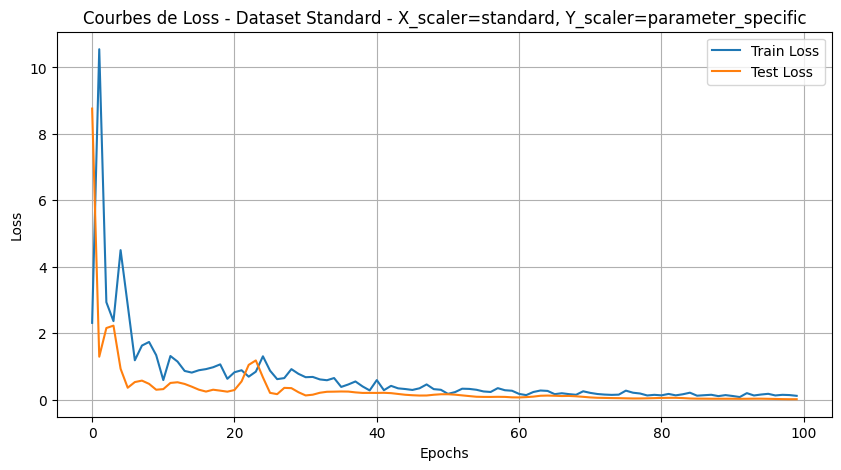

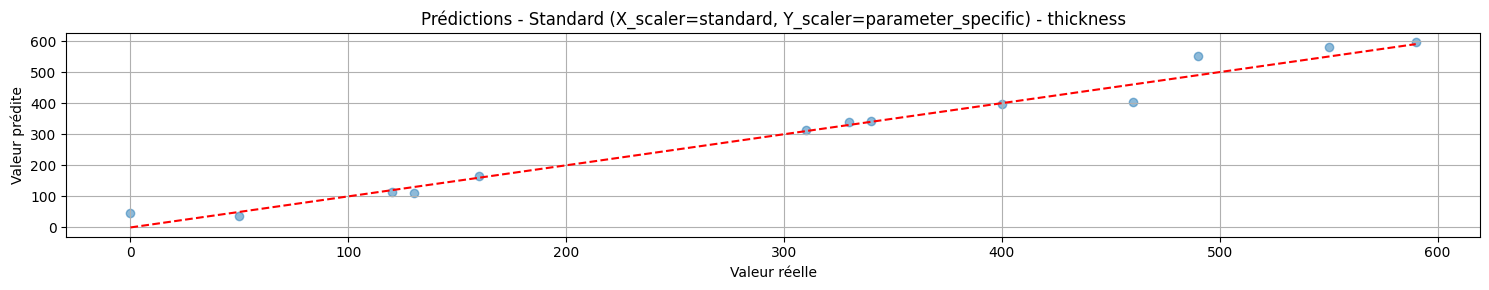


=== Entraînement sur le dataset Standard avec X_scaler=standard et Y_scaler=standard ===

=== Entraînement sur le dataset Standard (X_scaler=standard, Y_scaler=standard) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.4734, Test Loss: 0.5460
Epoch 20/100 - Train Loss: 0.7290, Test Loss: 0.4457
Epoch 30/100 - Train Loss: 0.5503, Test Loss: 0.2127
Epoch 40/100 - Train Loss: 0.4579, Test Loss: 0.1499
Epoch 50/100 - Train Loss: 0.1918, Test Loss: 0.0831
Epoch 60/100 - Train Loss: 0.2515, Test Loss: 0.1150
Early stopping à l'epoch 68
Entraînement terminé en 0.61 secondes
Meilleure loss sur le test set: 0.0454


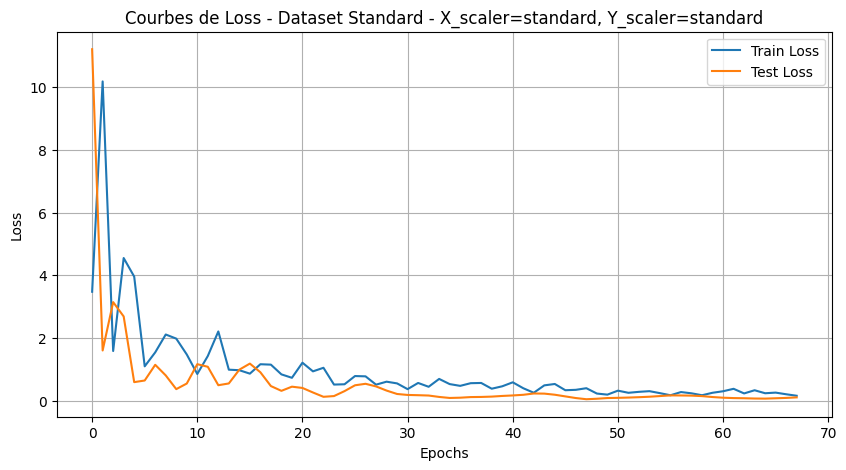

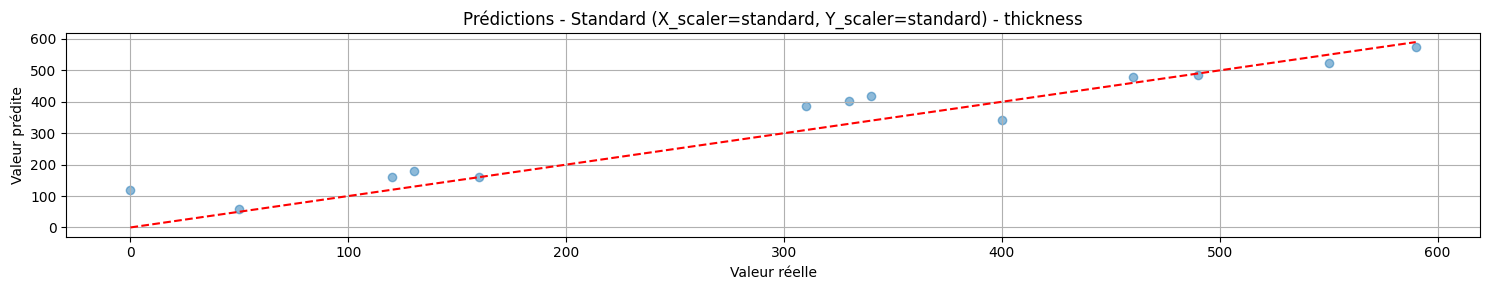


=== Entraînement sur le dataset Standard avec X_scaler=standard et Y_scaler=minmax ===

=== Entraînement sur le dataset Standard (X_scaler=standard, Y_scaler=minmax) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.6572, Test Loss: 0.6452
Epoch 20/100 - Train Loss: 1.1003, Test Loss: 0.6388
Epoch 30/100 - Train Loss: 0.4586, Test Loss: 0.0935
Epoch 40/100 - Train Loss: 0.4118, Test Loss: 0.0990
Epoch 50/100 - Train Loss: 0.3150, Test Loss: 0.0817
Epoch 60/100 - Train Loss: 0.2134, Test Loss: 0.0900
Epoch 70/100 - Train Loss: 0.1659, Test Loss: 0.0417
Epoch 80/100 - Train Loss: 0.2164, Test Loss: 0.0572
Early stopping à l'epoch 89
Entraînement terminé en 0.80 secondes
Meilleure loss sur le test set: 0.0354


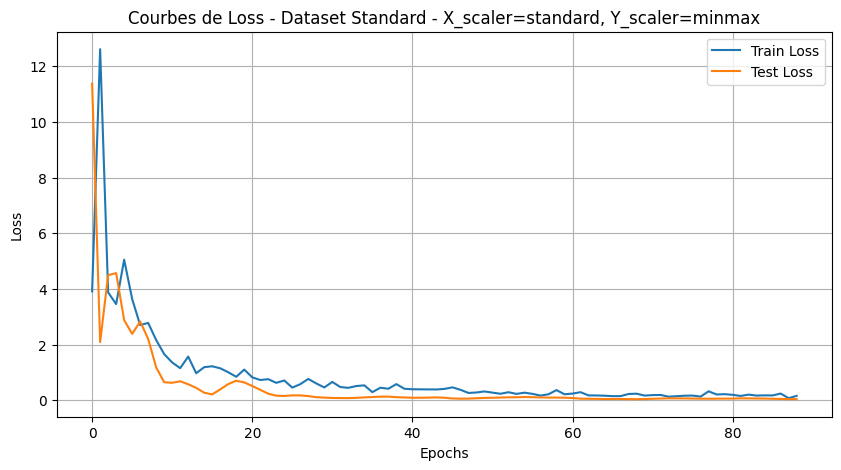

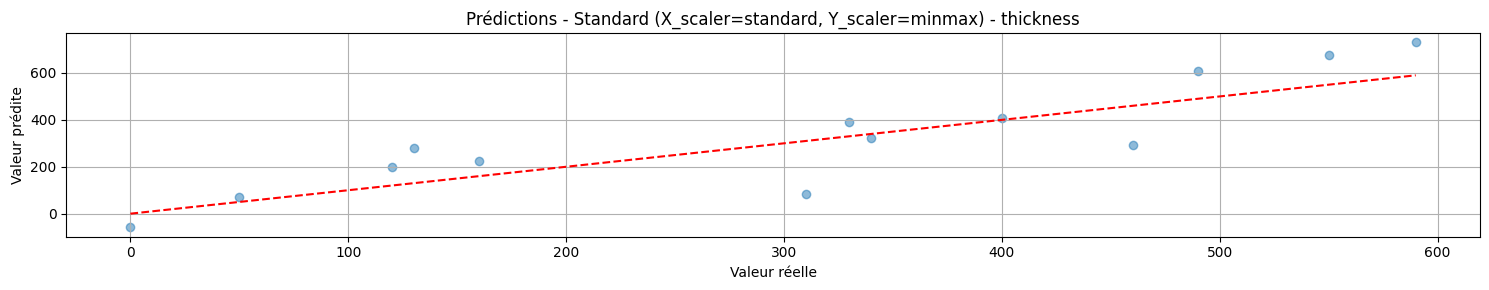


=== Entraînement sur le dataset Standard avec X_scaler=standard et Y_scaler=robust ===

=== Entraînement sur le dataset Standard (X_scaler=standard, Y_scaler=robust) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.8221, Test Loss: 0.7036
Epoch 20/100 - Train Loss: 1.2497, Test Loss: 0.3827
Epoch 30/100 - Train Loss: 0.6335, Test Loss: 0.1668
Early stopping à l'epoch 36
Entraînement terminé en 0.35 secondes
Meilleure loss sur le test set: 0.0832


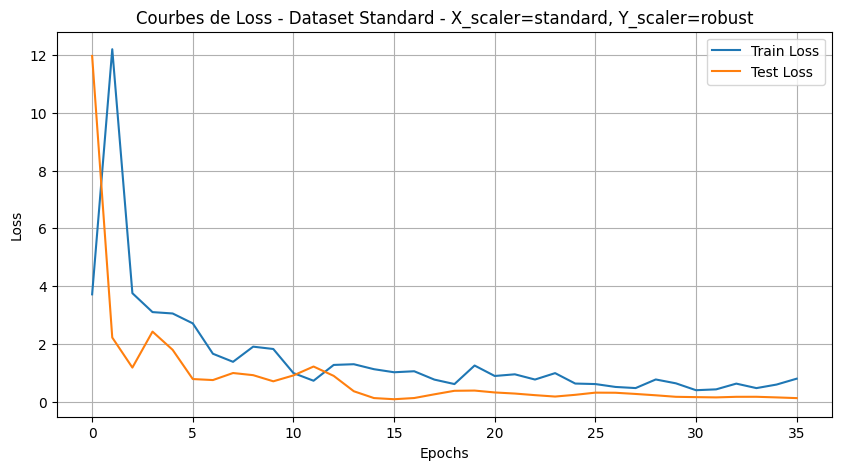

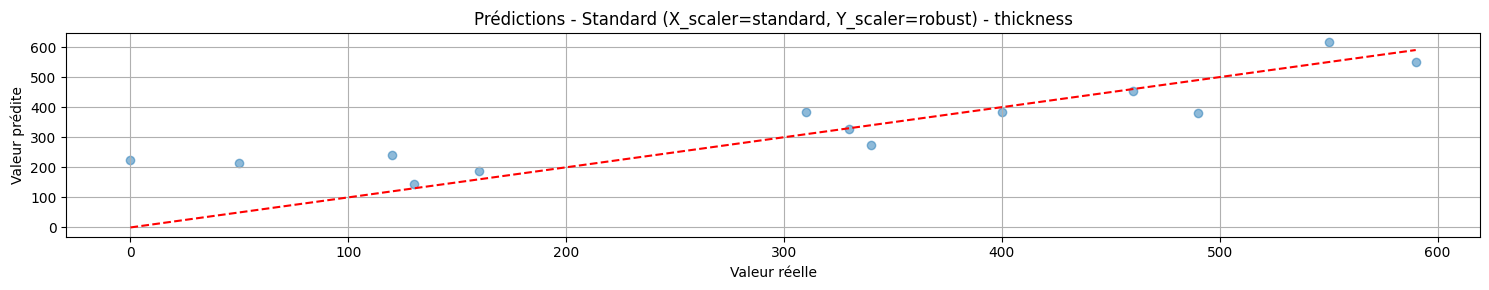


=== Entraînement sur le dataset Standard avec X_scaler=minmax et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Standard (X_scaler=minmax, Y_scaler=parameter_specific) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.4895, Test Loss: 0.8028
Epoch 20/100 - Train Loss: 0.5205, Test Loss: 0.6681
Epoch 30/100 - Train Loss: 0.2619, Test Loss: 0.1633
Epoch 40/100 - Train Loss: 0.0909, Test Loss: 0.0817
Epoch 50/100 - Train Loss: 0.0982, Test Loss: 0.0846
Epoch 60/100 - Train Loss: 0.0820, Test Loss: 0.0381
Epoch 70/100 - Train Loss: 0.0639, Test Loss: 0.0289
Epoch 80/100 - Train Loss: 0.0531, Test Loss: 0.0320
Early stopping à l'epoch 87
Entraînement terminé en 0.66 secondes
Meilleure loss sur le test set: 0.0221


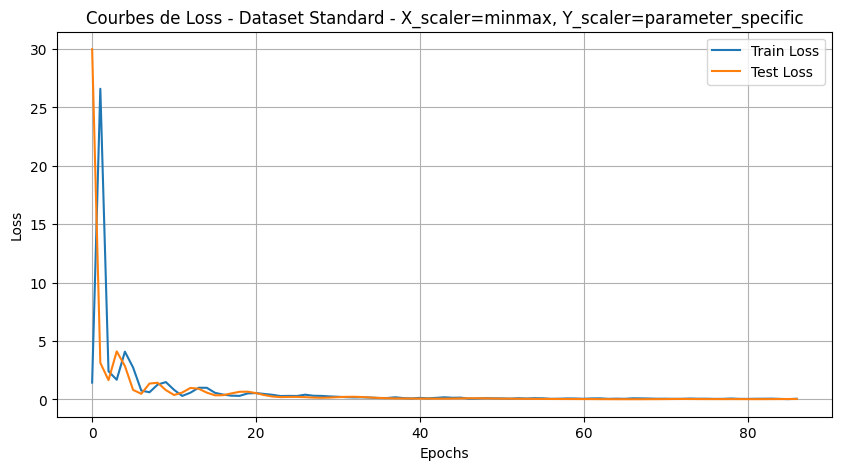

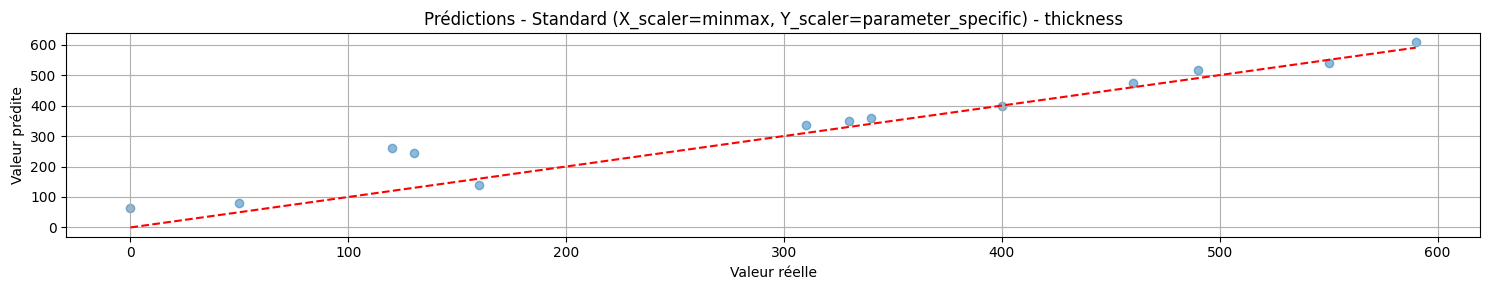


=== Entraînement sur le dataset Standard avec X_scaler=minmax et Y_scaler=standard ===

=== Entraînement sur le dataset Standard (X_scaler=minmax, Y_scaler=standard) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.0231, Test Loss: 0.8121
Epoch 20/100 - Train Loss: 0.3683, Test Loss: 0.2780
Epoch 30/100 - Train Loss: 0.1971, Test Loss: 0.0941
Epoch 40/100 - Train Loss: 0.1217, Test Loss: 0.0439
Epoch 50/100 - Train Loss: 0.1535, Test Loss: 0.0428
Epoch 60/100 - Train Loss: 0.1197, Test Loss: 0.0349
Epoch 70/100 - Train Loss: 0.1096, Test Loss: 0.0653
Epoch 80/100 - Train Loss: 0.1008, Test Loss: 0.0335
Epoch 90/100 - Train Loss: 0.0650, Test Loss: 0.0360
Early stopping à l'epoch 95
Entraînement terminé en 0.92 secondes
Meilleure loss sur le test set: 0.0223


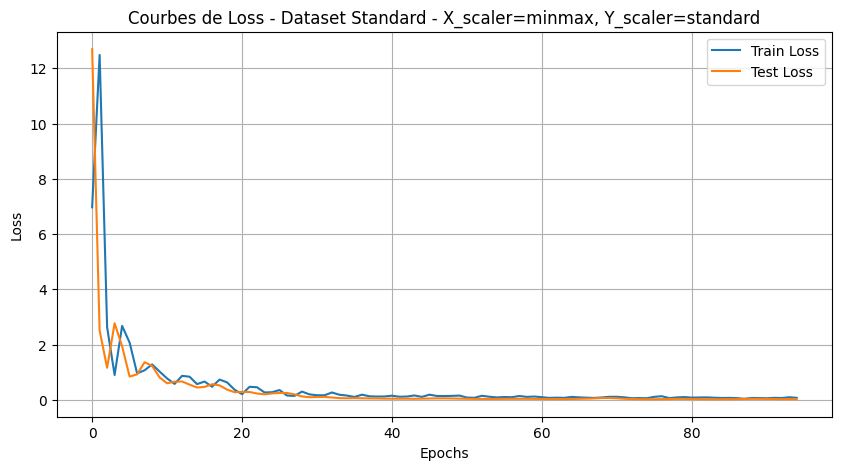

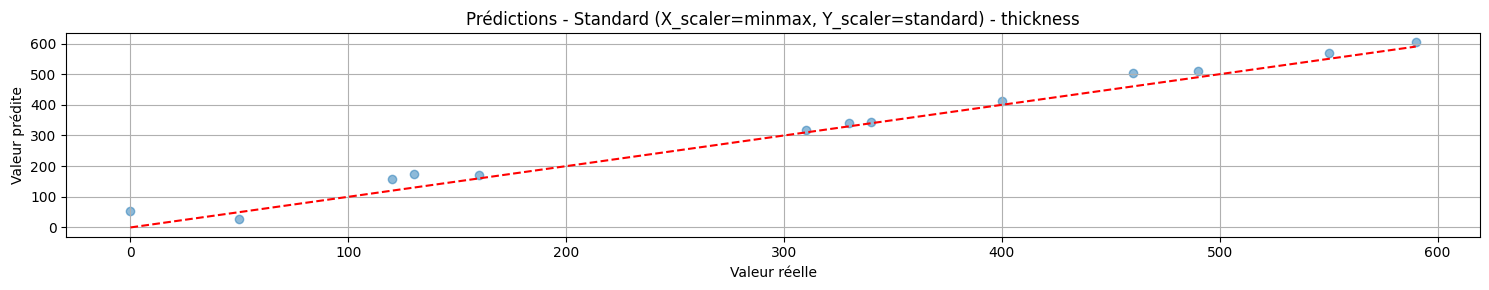


=== Entraînement sur le dataset Standard avec X_scaler=minmax et Y_scaler=minmax ===

=== Entraînement sur le dataset Standard (X_scaler=minmax, Y_scaler=minmax) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.4546, Test Loss: 0.8647
Epoch 20/100 - Train Loss: 0.3921, Test Loss: 0.0862
Epoch 30/100 - Train Loss: 0.2233, Test Loss: 0.0715
Epoch 40/100 - Train Loss: 0.0868, Test Loss: 0.0288
Epoch 50/100 - Train Loss: 0.1247, Test Loss: 0.0139
Epoch 60/100 - Train Loss: 0.0621, Test Loss: 0.0294
Epoch 70/100 - Train Loss: 0.0520, Test Loss: 0.0246
Early stopping à l'epoch 71
Entraînement terminé en 1.08 secondes
Meilleure loss sur le test set: 0.0135


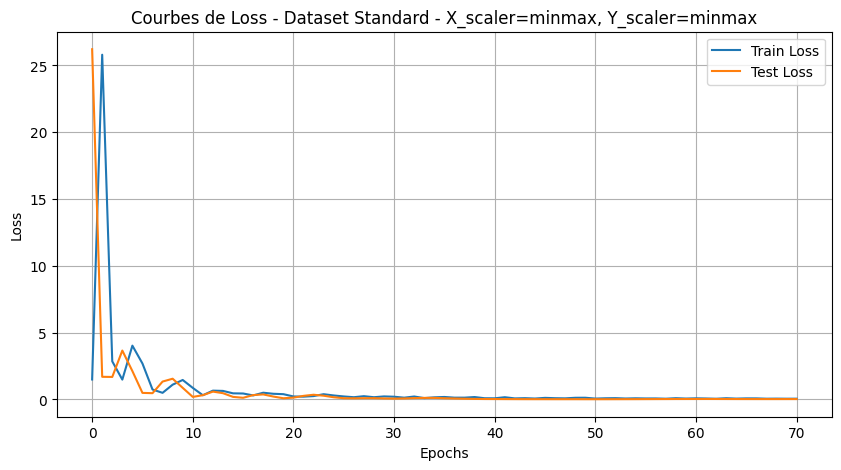

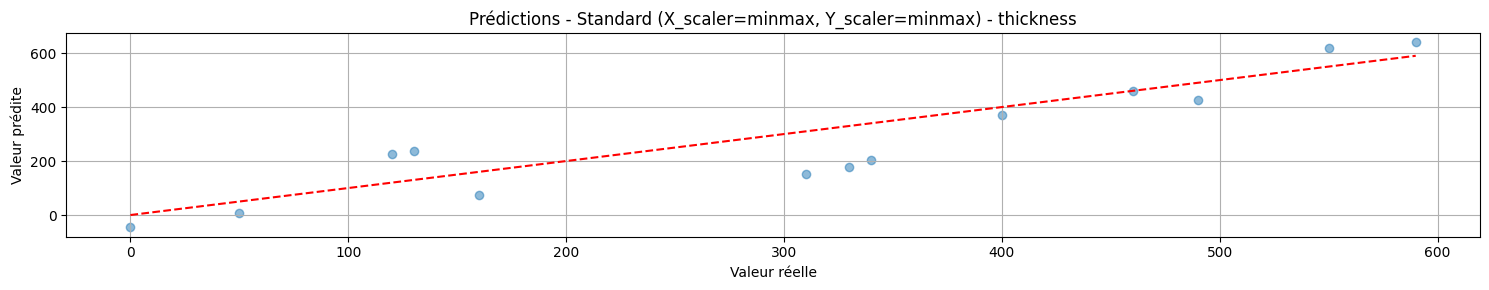


=== Entraînement sur le dataset Standard avec X_scaler=minmax et Y_scaler=robust ===

=== Entraînement sur le dataset Standard (X_scaler=minmax, Y_scaler=robust) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.4013, Test Loss: 0.5891
Epoch 20/100 - Train Loss: 0.5827, Test Loss: 0.2415
Epoch 30/100 - Train Loss: 0.1371, Test Loss: 0.1409
Epoch 40/100 - Train Loss: 0.1251, Test Loss: 0.1045
Epoch 50/100 - Train Loss: 0.1217, Test Loss: 0.0240
Epoch 60/100 - Train Loss: 0.0815, Test Loss: 0.0268
Early stopping à l'epoch 65
Entraînement terminé en 0.92 secondes
Meilleure loss sur le test set: 0.0196


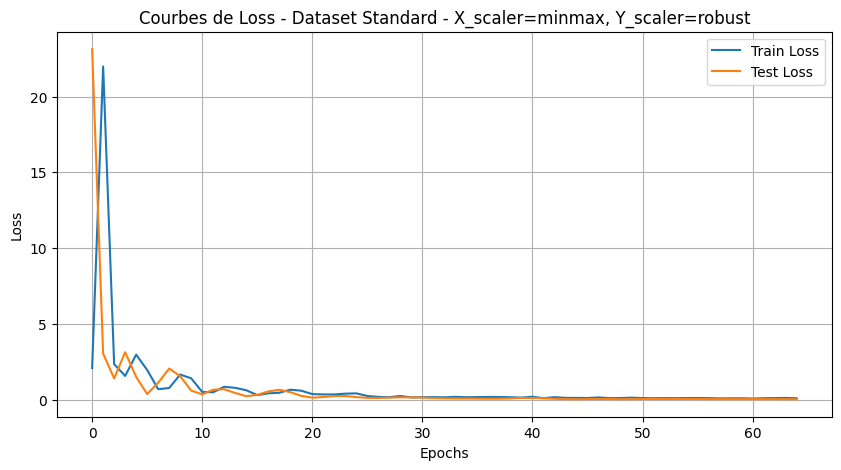

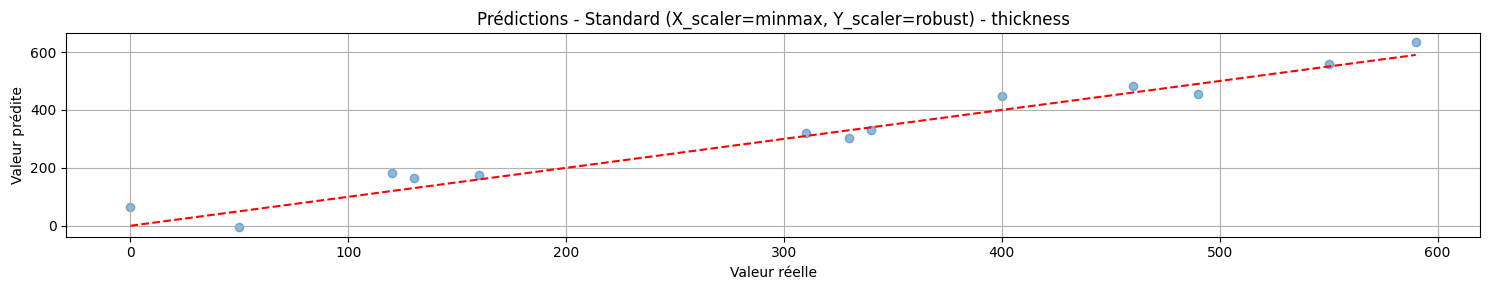


=== Entraînement sur le dataset Standard avec X_scaler=robust et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Standard (X_scaler=robust, Y_scaler=parameter_specific) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 0.9911, Test Loss: 0.4265
Epoch 20/100 - Train Loss: 0.3046, Test Loss: 0.1617
Epoch 30/100 - Train Loss: 0.2639, Test Loss: 0.0841
Epoch 40/100 - Train Loss: 0.1484, Test Loss: 0.0228
Epoch 50/100 - Train Loss: 0.1174, Test Loss: 0.0574
Epoch 60/100 - Train Loss: 0.1092, Test Loss: 0.0204
Early stopping à l'epoch 62
Entraînement terminé en 0.90 secondes
Meilleure loss sur le test set: 0.0117


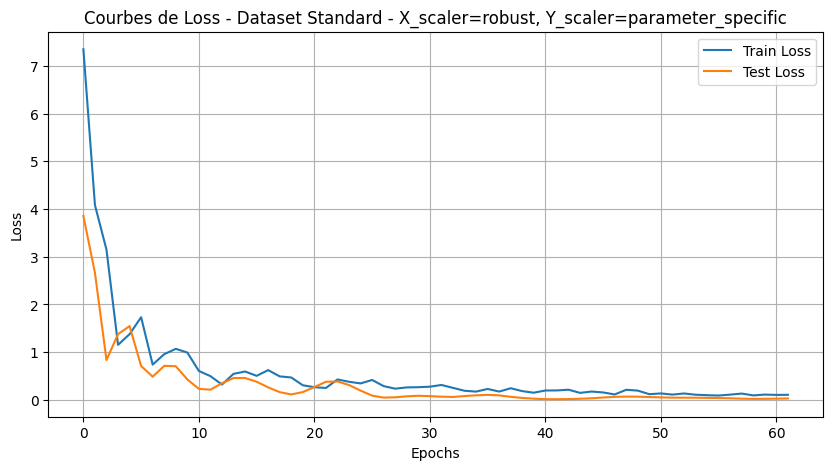

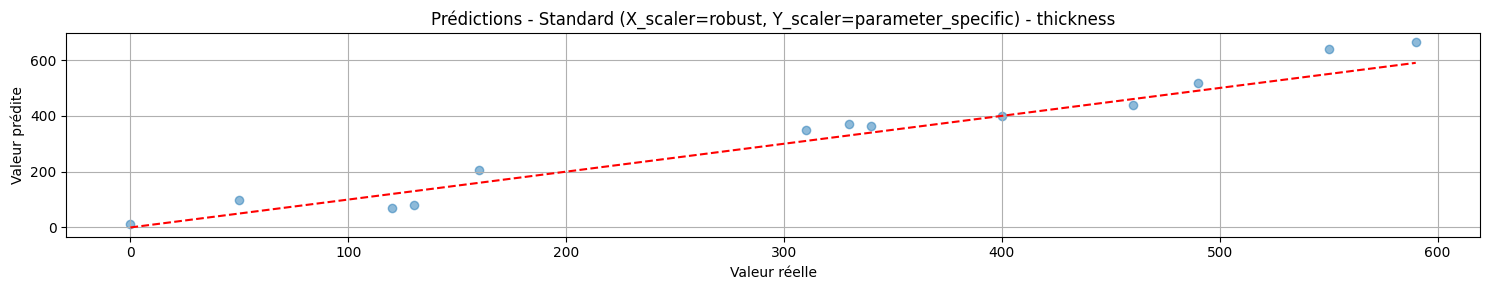


=== Entraînement sur le dataset Standard avec X_scaler=robust et Y_scaler=standard ===

=== Entraînement sur le dataset Standard (X_scaler=robust, Y_scaler=standard) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 0.6455, Test Loss: 0.5501
Epoch 20/100 - Train Loss: 0.3632, Test Loss: 0.2109
Epoch 30/100 - Train Loss: 0.1965, Test Loss: 0.1465
Epoch 40/100 - Train Loss: 0.2263, Test Loss: 0.1320
Epoch 50/100 - Train Loss: 0.1189, Test Loss: 0.0552
Epoch 60/100 - Train Loss: 0.0849, Test Loss: 0.0358
Epoch 70/100 - Train Loss: 0.0979, Test Loss: 0.0337
Epoch 80/100 - Train Loss: 0.1163, Test Loss: 0.0378
Epoch 90/100 - Train Loss: 0.1112, Test Loss: 0.0458
Early stopping à l'epoch 97
Entraînement terminé en 1.47 secondes
Meilleure loss sur le test set: 0.0195


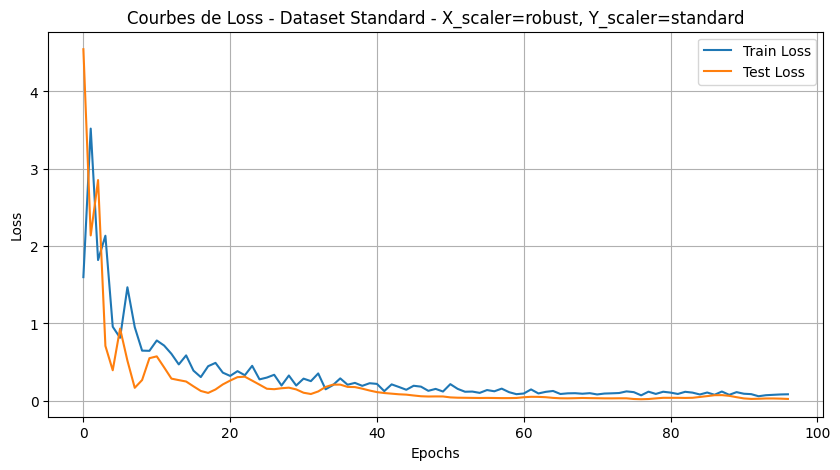

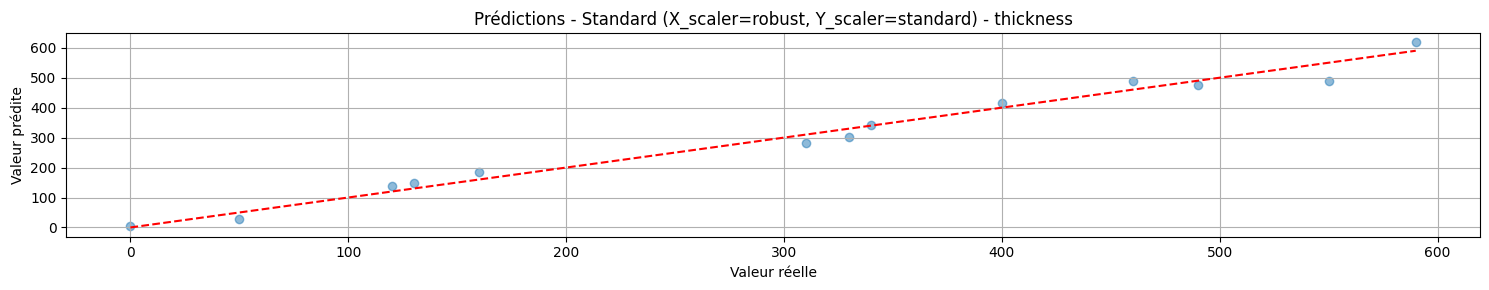


=== Entraînement sur le dataset Standard avec X_scaler=robust et Y_scaler=minmax ===

=== Entraînement sur le dataset Standard (X_scaler=robust, Y_scaler=minmax) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 0.7553, Test Loss: 0.6375
Epoch 20/100 - Train Loss: 0.3266, Test Loss: 0.2148
Epoch 30/100 - Train Loss: 0.2080, Test Loss: 0.0919
Epoch 40/100 - Train Loss: 0.1442, Test Loss: 0.0374
Epoch 50/100 - Train Loss: 0.1379, Test Loss: 0.0261
Epoch 60/100 - Train Loss: 0.0922, Test Loss: 0.0098
Epoch 70/100 - Train Loss: 0.0520, Test Loss: 0.0186
Early stopping à l'epoch 77
Entraînement terminé en 1.25 secondes
Meilleure loss sur le test set: 0.0093


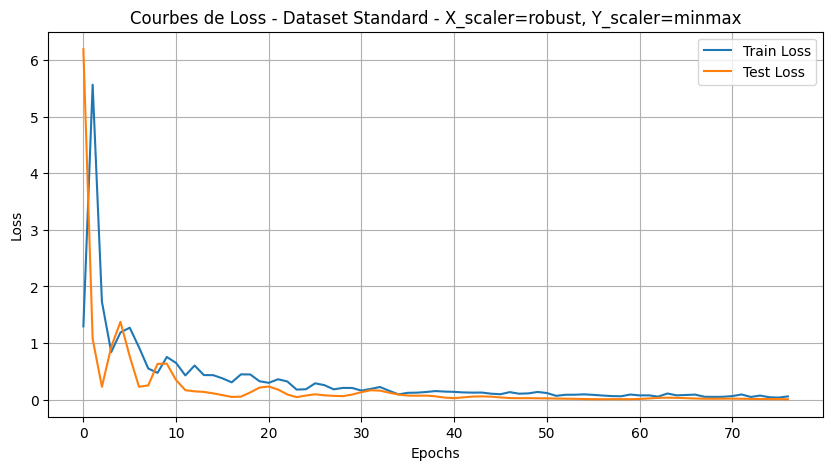

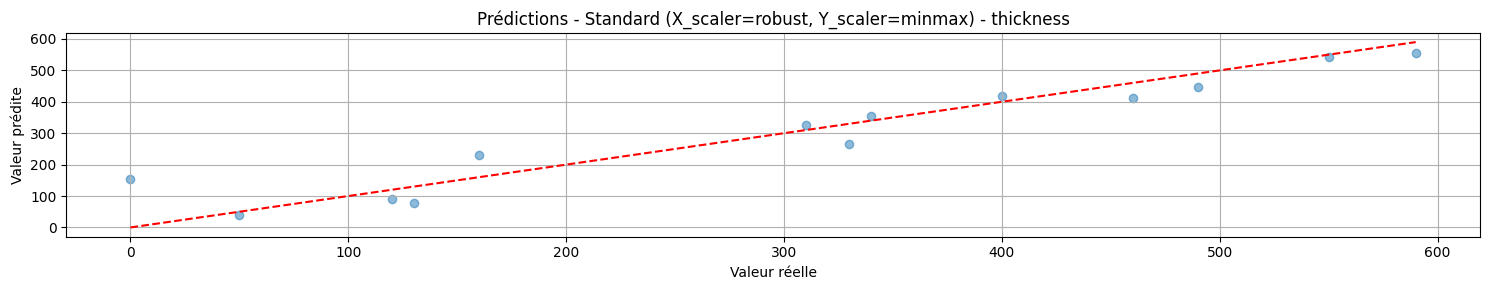


=== Entraînement sur le dataset Standard avec X_scaler=robust et Y_scaler=robust ===

=== Entraînement sur le dataset Standard (X_scaler=robust, Y_scaler=robust) ===
Taille du training set: 48
Taille du test set: 13
Paramètres à prédire: ['thickness']
Epoch 10/100 - Train Loss: 1.1179, Test Loss: 0.5558
Epoch 20/100 - Train Loss: 0.3409, Test Loss: 0.2406
Epoch 30/100 - Train Loss: 0.1635, Test Loss: 0.0761
Early stopping à l'epoch 38
Entraînement terminé en 1.07 secondes
Meilleure loss sur le test set: 0.0561


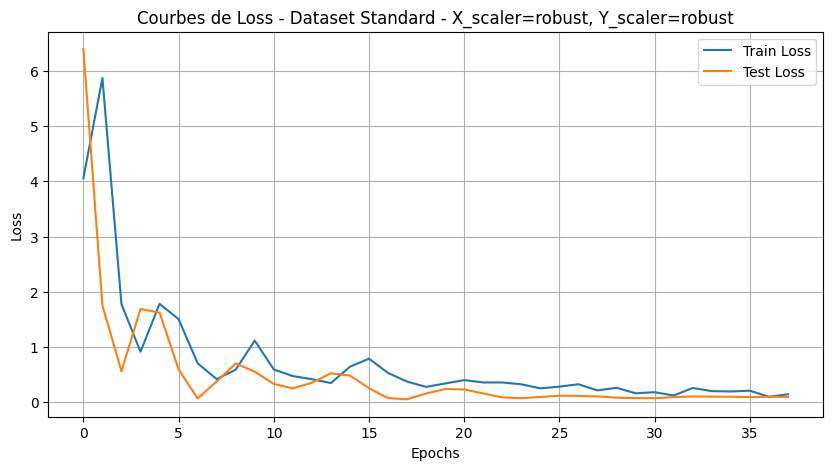

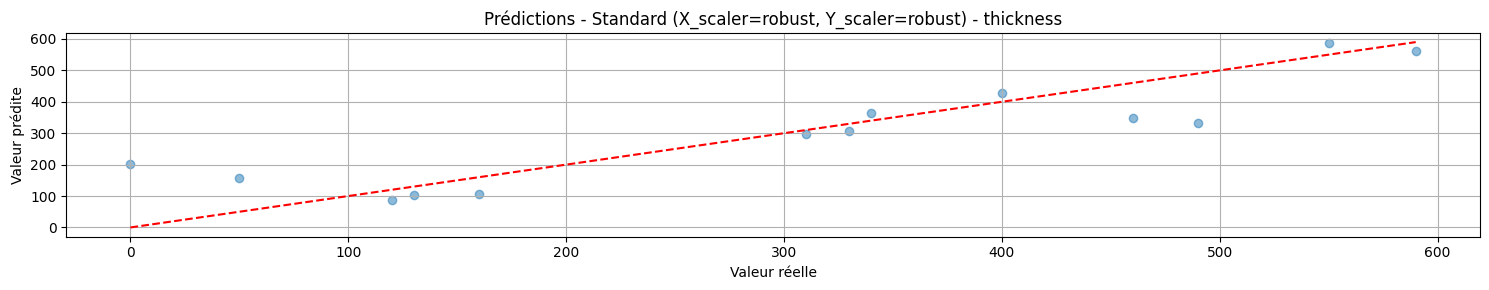


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=standard et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=standard, Y_scaler=parameter_specific) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.0716, Test Loss: 0.0278
Epoch 20/100 - Train Loss: 0.0338, Test Loss: 0.0157
Epoch 30/100 - Train Loss: 0.0250, Test Loss: 0.0130
Epoch 40/100 - Train Loss: 0.0192, Test Loss: 0.0121
Epoch 50/100 - Train Loss: 0.0161, Test Loss: 0.0112
Epoch 60/100 - Train Loss: 0.0135, Test Loss: 0.0080
Epoch 70/100 - Train Loss: 0.0119, Test Loss: 0.0080
Epoch 80/100 - Train Loss: 0.0101, Test Loss: 0.0085
Epoch 90/100 - Train Loss: 0.0093, Test Loss: 0.0095
Epoch 100/100 - Train Loss: 0.0088, Test Loss: 0.0078
Entraînement terminé en 31.48 secondes
Meilleure loss sur le test set: 0.0059


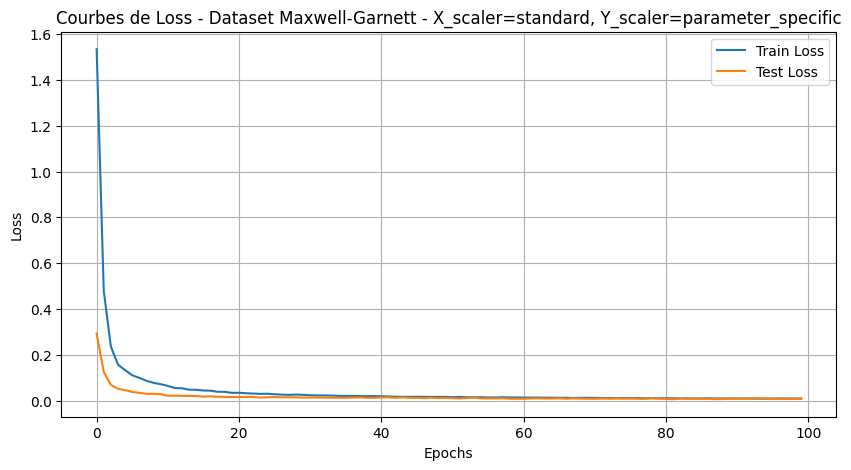

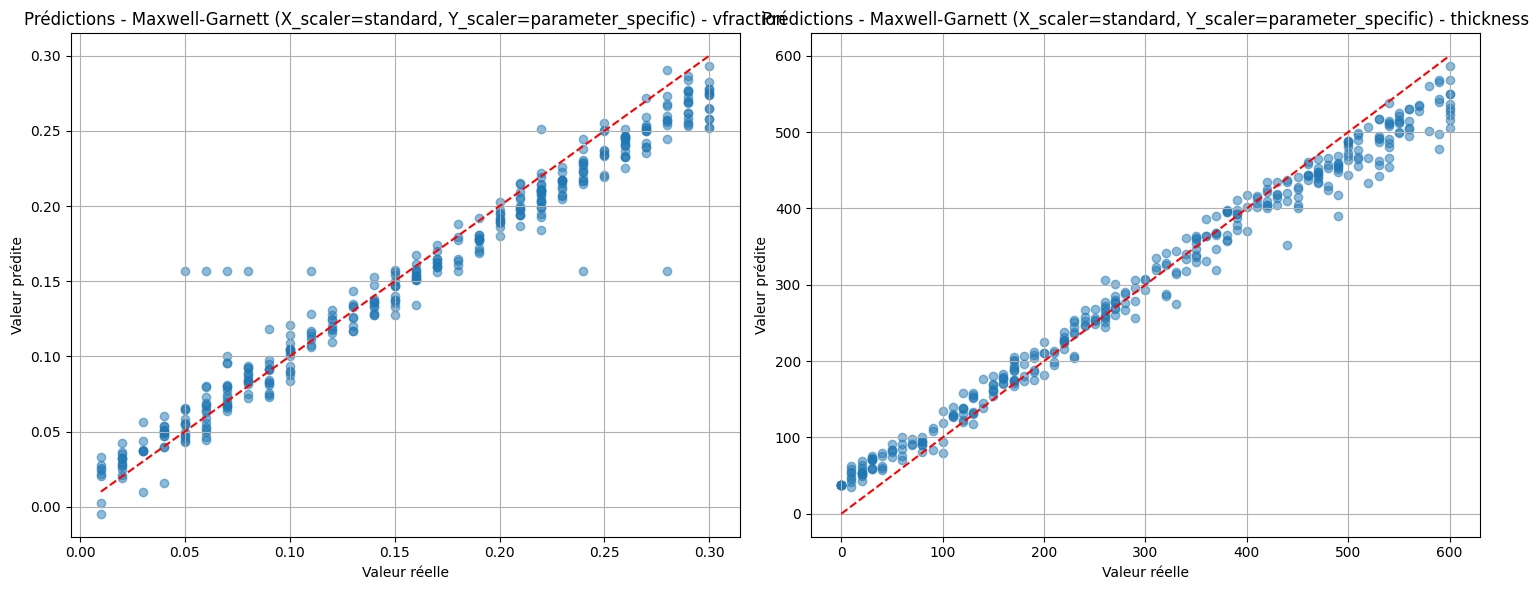


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=standard et Y_scaler=standard ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=standard, Y_scaler=standard) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.1194, Test Loss: 0.0496
Epoch 20/100 - Train Loss: 0.0676, Test Loss: 0.0390
Epoch 30/100 - Train Loss: 0.0561, Test Loss: 0.0341
Epoch 40/100 - Train Loss: 0.0428, Test Loss: 0.0335
Epoch 50/100 - Train Loss: 0.0412, Test Loss: 0.0373
Epoch 60/100 - Train Loss: 0.0334, Test Loss: 0.0334
Epoch 70/100 - Train Loss: 0.0316, Test Loss: 0.0270
Epoch 80/100 - Train Loss: 0.0293, Test Loss: 0.0298
Epoch 90/100 - Train Loss: 0.0282, Test Loss: 0.0272
Early stopping à l'epoch 92
Entraînement terminé en 18.24 secondes
Meilleure loss sur le test set: 0.0262


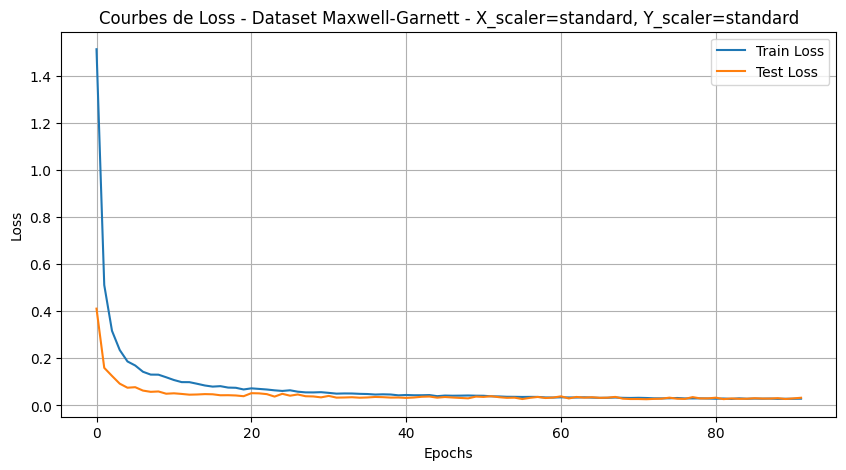

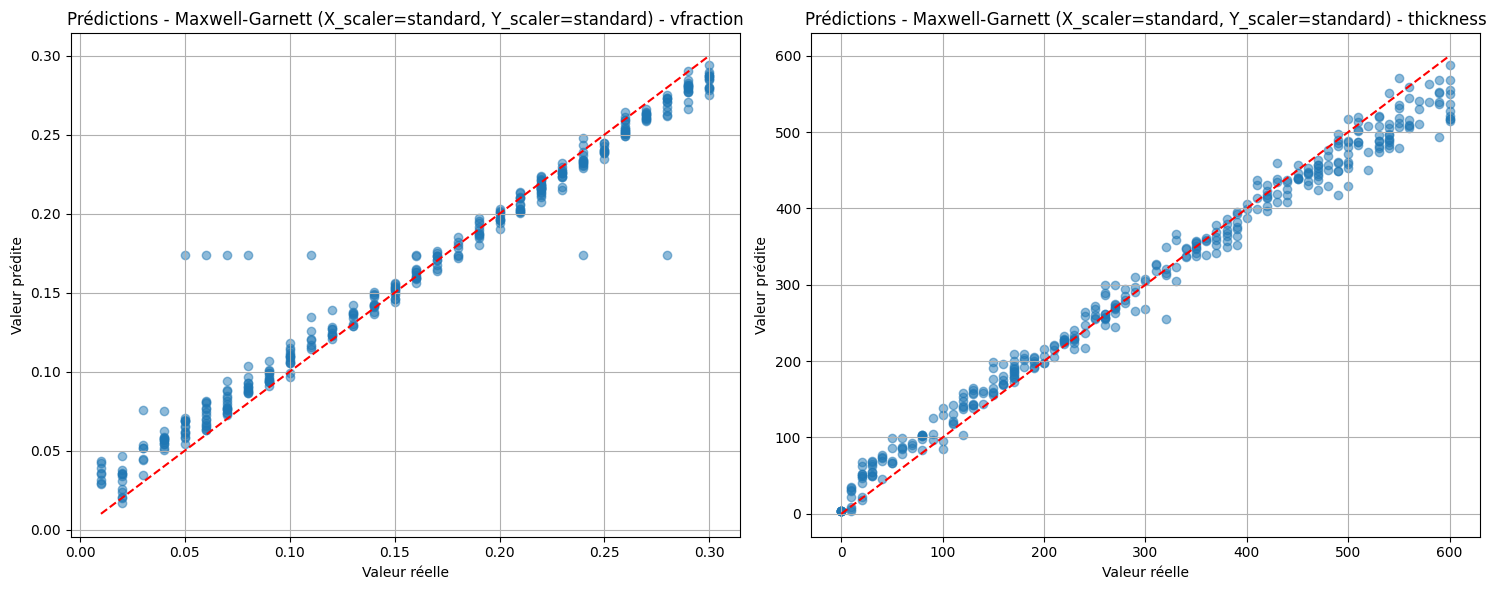


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=standard et Y_scaler=minmax ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=standard, Y_scaler=minmax) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.0521, Test Loss: 0.0174
Epoch 20/100 - Train Loss: 0.0224, Test Loss: 0.0133
Epoch 30/100 - Train Loss: 0.0152, Test Loss: 0.0107
Epoch 40/100 - Train Loss: 0.0111, Test Loss: 0.0074
Epoch 50/100 - Train Loss: 0.0094, Test Loss: 0.0073
Epoch 60/100 - Train Loss: 0.0083, Test Loss: 0.0065
Epoch 70/100 - Train Loss: 0.0074, Test Loss: 0.0067
Epoch 80/100 - Train Loss: 0.0064, Test Loss: 0.0052
Epoch 90/100 - Train Loss: 0.0057, Test Loss: 0.0053
Epoch 100/100 - Train Loss: 0.0054, Test Loss: 0.0044
Entraînement terminé en 19.10 secondes
Meilleure loss sur le test set: 0.0043


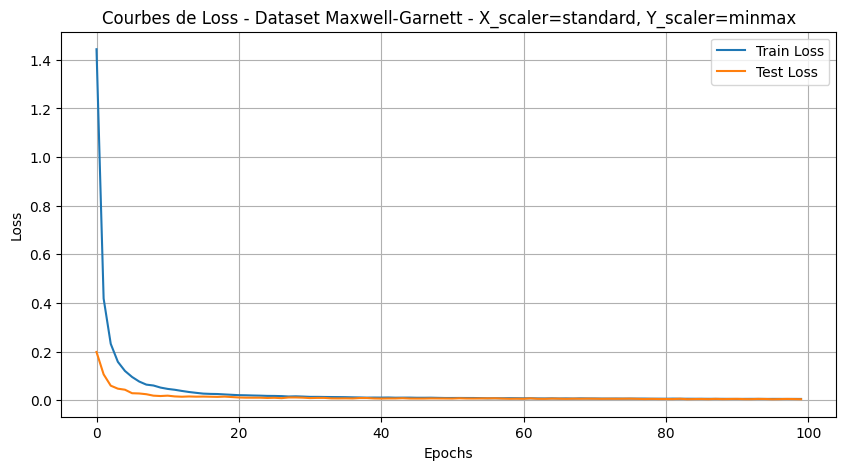

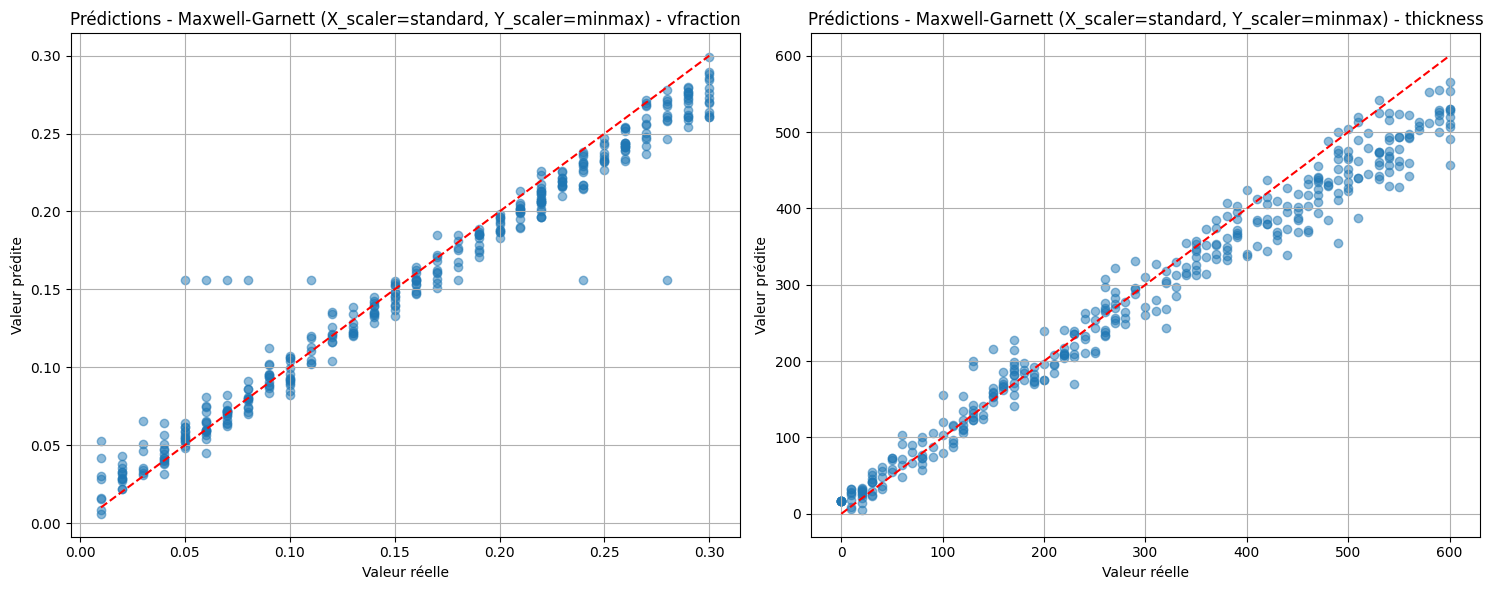


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=standard et Y_scaler=robust ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=standard, Y_scaler=robust) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.0713, Test Loss: 0.0266
Epoch 20/100 - Train Loss: 0.0400, Test Loss: 0.0236
Epoch 30/100 - Train Loss: 0.0283, Test Loss: 0.0181
Epoch 40/100 - Train Loss: 0.0226, Test Loss: 0.0182
Epoch 50/100 - Train Loss: 0.0183, Test Loss: 0.0157
Epoch 60/100 - Train Loss: 0.0169, Test Loss: 0.0158
Epoch 70/100 - Train Loss: 0.0150, Test Loss: 0.0126
Epoch 80/100 - Train Loss: 0.0137, Test Loss: 0.0118
Epoch 90/100 - Train Loss: 0.0124, Test Loss: 0.0154
Epoch 100/100 - Train Loss: 0.0126, Test Loss: 0.0108
Entraînement terminé en 19.45 secondes
Meilleure loss sur le test set: 0.0103


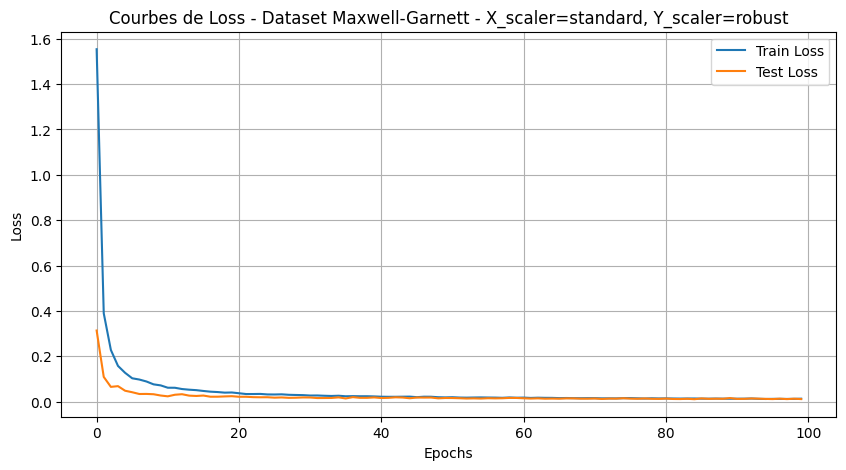

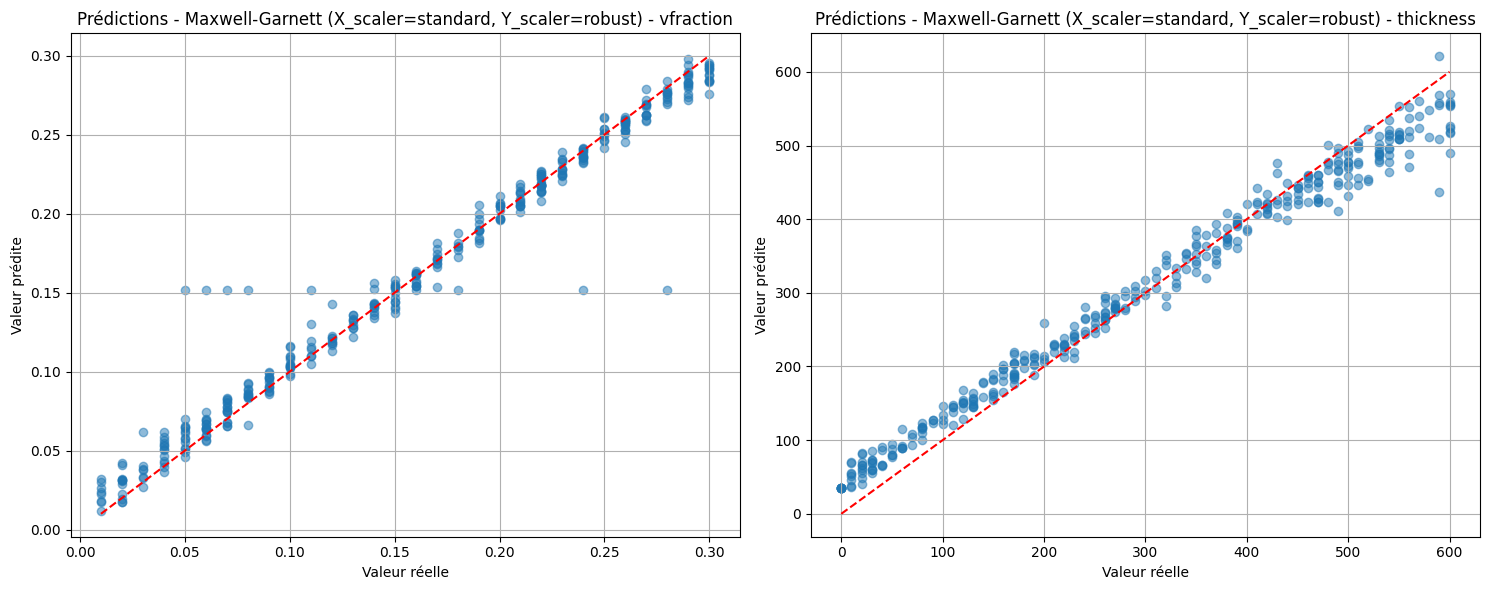


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=minmax et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=minmax, Y_scaler=parameter_specific) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.0449, Test Loss: 0.0226
Epoch 20/100 - Train Loss: 0.0218, Test Loss: 0.0107
Epoch 30/100 - Train Loss: 0.0158, Test Loss: 0.0082
Epoch 40/100 - Train Loss: 0.0129, Test Loss: 0.0066
Epoch 50/100 - Train Loss: 0.0110, Test Loss: 0.0070
Epoch 60/100 - Train Loss: 0.0096, Test Loss: 0.0064
Epoch 70/100 - Train Loss: 0.0089, Test Loss: 0.0053
Epoch 80/100 - Train Loss: 0.0081, Test Loss: 0.0049
Epoch 90/100 - Train Loss: 0.0076, Test Loss: 0.0045
Epoch 100/100 - Train Loss: 0.0073, Test Loss: 0.0045
Entraînement terminé en 20.58 secondes
Meilleure loss sur le test set: 0.0035


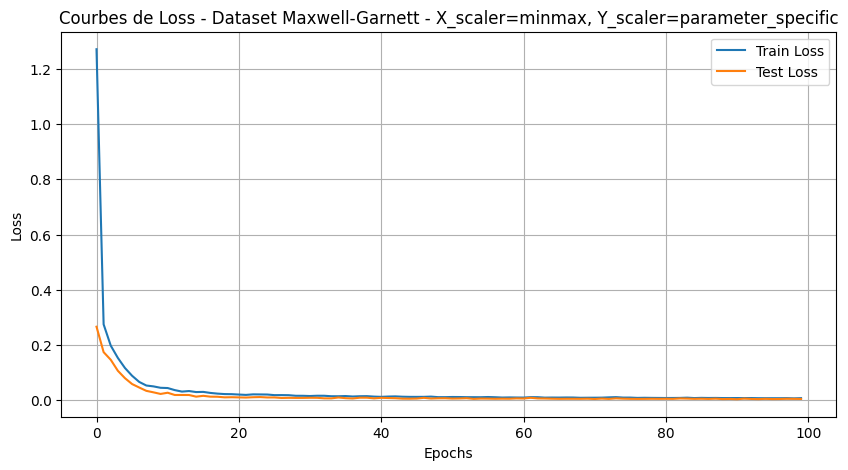

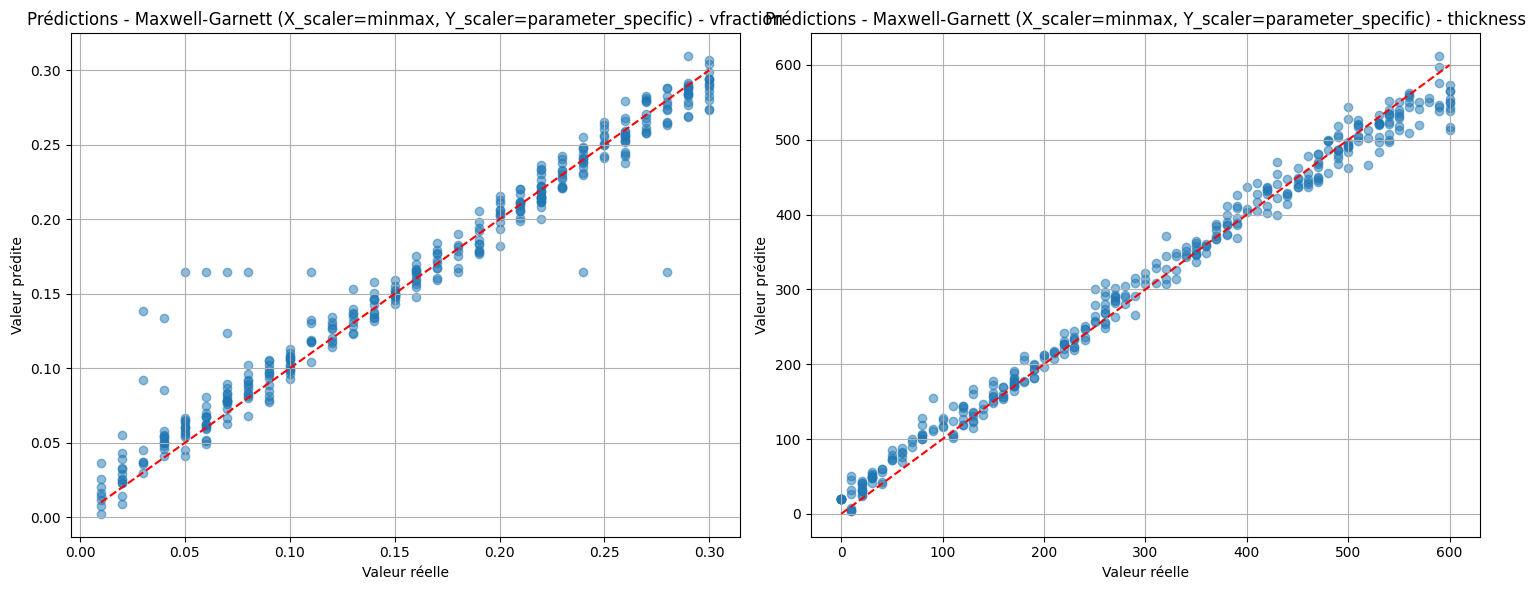


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=minmax et Y_scaler=standard ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=minmax, Y_scaler=standard) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.1037, Test Loss: 0.0648
Epoch 20/100 - Train Loss: 0.0625, Test Loss: 0.0403
Epoch 30/100 - Train Loss: 0.0490, Test Loss: 0.0311
Epoch 40/100 - Train Loss: 0.0417, Test Loss: 0.0267
Epoch 50/100 - Train Loss: 0.0443, Test Loss: 0.0330
Epoch 60/100 - Train Loss: 0.0384, Test Loss: 0.0245
Epoch 70/100 - Train Loss: 0.0362, Test Loss: 0.0261
Epoch 80/100 - Train Loss: 0.0379, Test Loss: 0.0265
Epoch 90/100 - Train Loss: 0.0334, Test Loss: 0.0261
Epoch 100/100 - Train Loss: 0.0294, Test Loss: 0.0209
Entraînement terminé en 19.19 secondes
Meilleure loss sur le test set: 0.0204


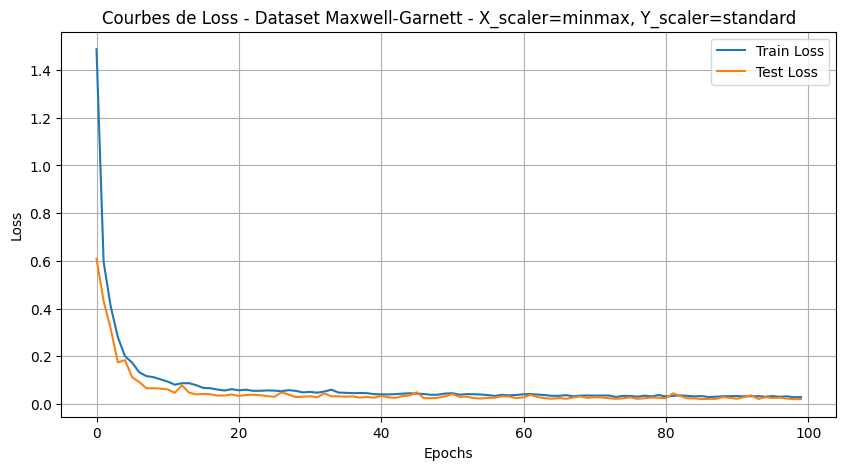

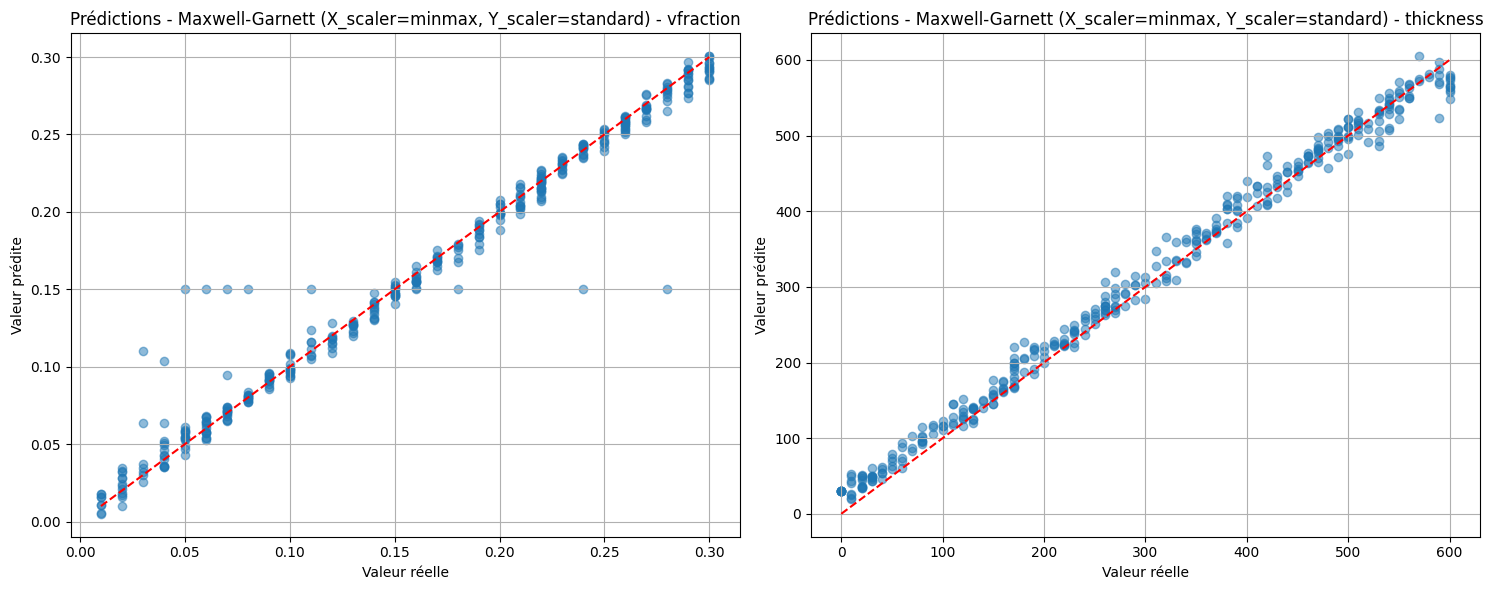


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=minmax et Y_scaler=minmax ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=minmax, Y_scaler=minmax) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.0231, Test Loss: 0.0118
Epoch 20/100 - Train Loss: 0.0121, Test Loss: 0.0053
Epoch 30/100 - Train Loss: 0.0088, Test Loss: 0.0054
Epoch 40/100 - Train Loss: 0.0081, Test Loss: 0.0049
Epoch 50/100 - Train Loss: 0.0068, Test Loss: 0.0035
Epoch 60/100 - Train Loss: 0.0054, Test Loss: 0.0038
Epoch 70/100 - Train Loss: 0.0060, Test Loss: 0.0041
Epoch 80/100 - Train Loss: 0.0047, Test Loss: 0.0037
Epoch 90/100 - Train Loss: 0.0047, Test Loss: 0.0033
Epoch 100/100 - Train Loss: 0.0046, Test Loss: 0.0046
Entraînement terminé en 23.61 secondes
Meilleure loss sur le test set: 0.0026


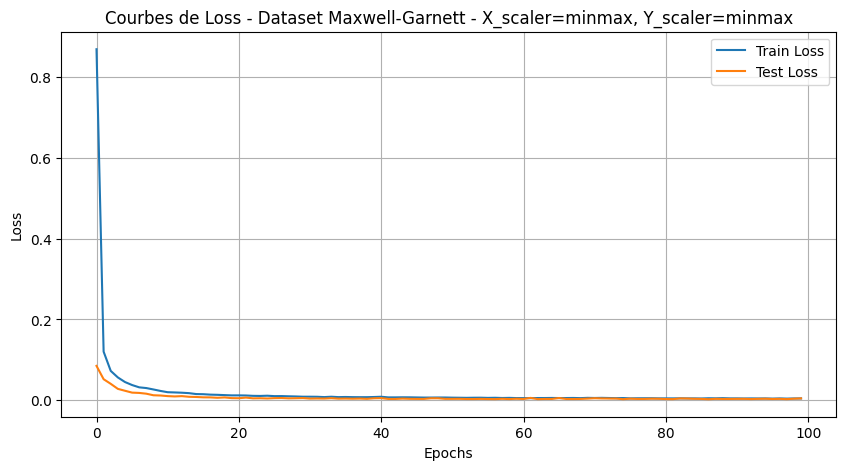

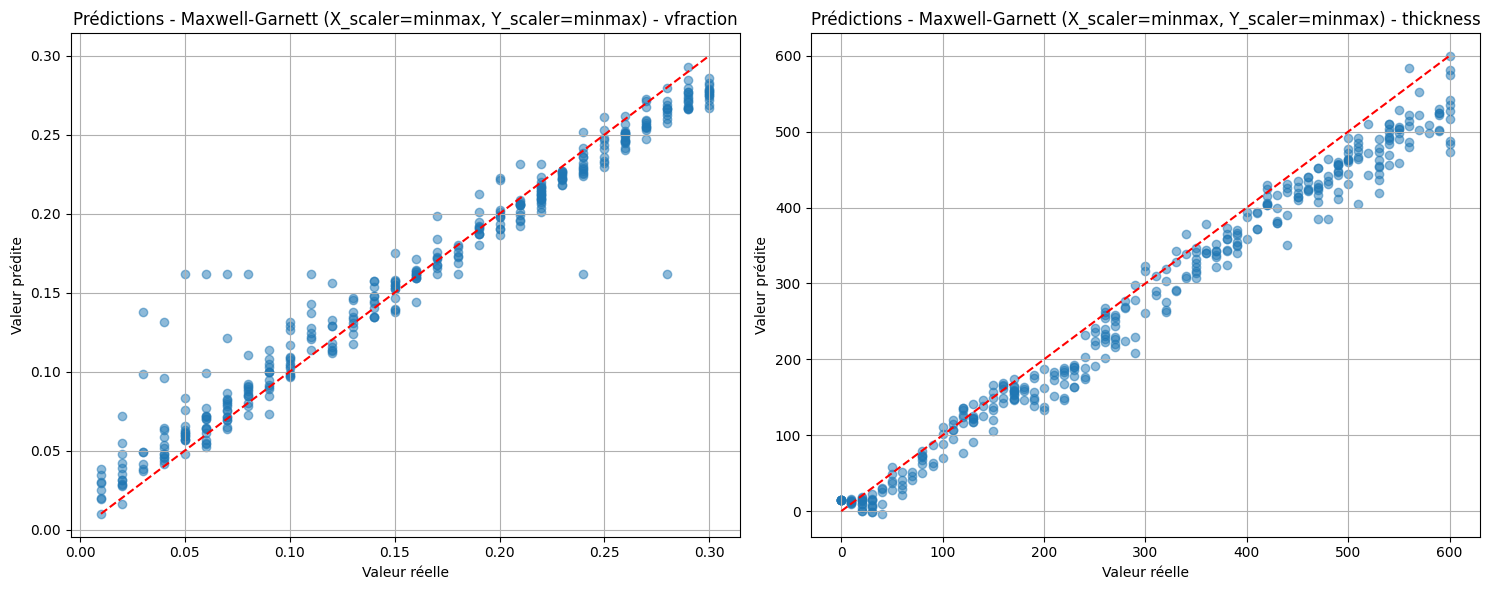


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=minmax et Y_scaler=robust ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=minmax, Y_scaler=robust) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.0458, Test Loss: 0.0239
Epoch 20/100 - Train Loss: 0.0278, Test Loss: 0.0182
Epoch 30/100 - Train Loss: 0.0198, Test Loss: 0.0179
Epoch 40/100 - Train Loss: 0.0179, Test Loss: 0.0119
Epoch 50/100 - Train Loss: 0.0177, Test Loss: 0.0096
Epoch 60/100 - Train Loss: 0.0148, Test Loss: 0.0110
Epoch 70/100 - Train Loss: 0.0136, Test Loss: 0.0096
Epoch 80/100 - Train Loss: 0.0121, Test Loss: 0.0082
Epoch 90/100 - Train Loss: 0.0132, Test Loss: 0.0106
Epoch 100/100 - Train Loss: 0.0149, Test Loss: 0.0098
Entraînement terminé en 30.13 secondes
Meilleure loss sur le test set: 0.0079


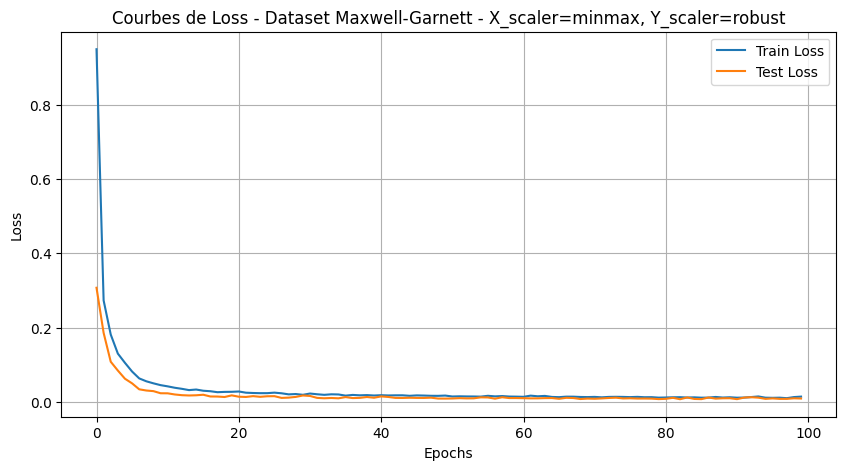

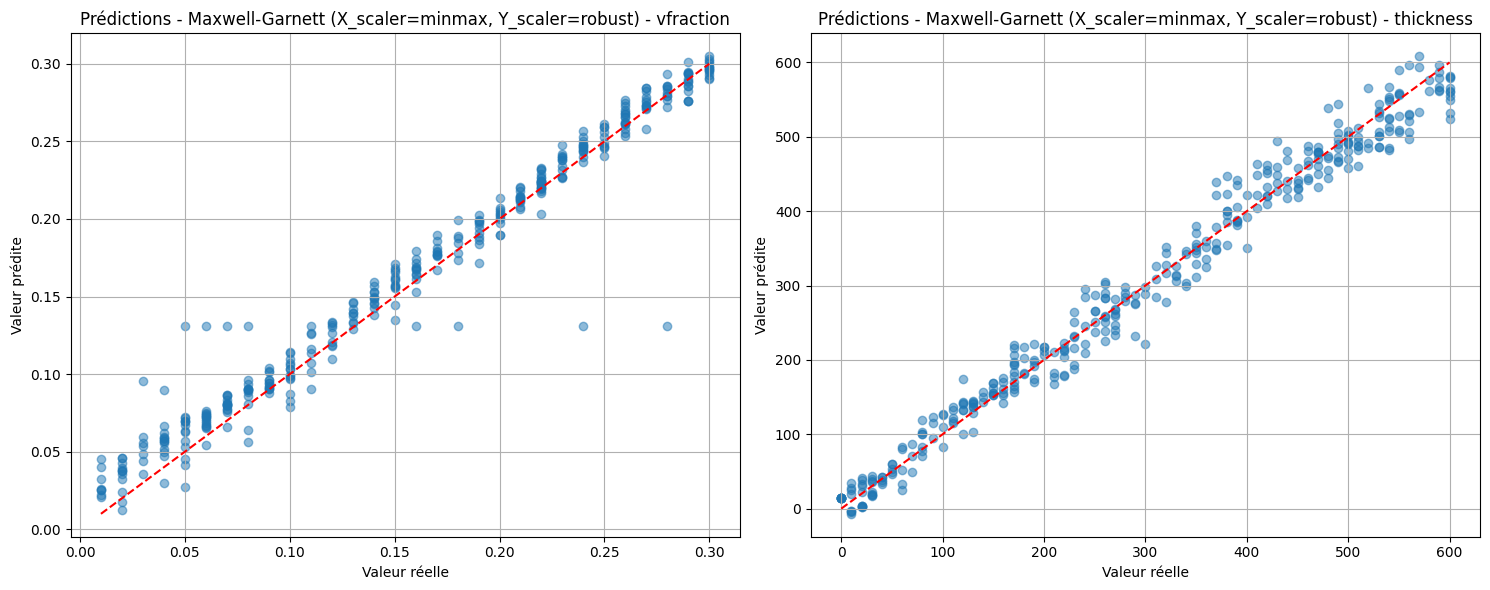


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=robust et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=robust, Y_scaler=parameter_specific) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.1154, Test Loss: 0.0451
Epoch 20/100 - Train Loss: 0.0561, Test Loss: 0.0275
Epoch 30/100 - Train Loss: 0.0361, Test Loss: 0.0244
Epoch 40/100 - Train Loss: 0.0288, Test Loss: 0.0223
Epoch 50/100 - Train Loss: 0.0213, Test Loss: 0.0180
Epoch 60/100 - Train Loss: 0.0186, Test Loss: 0.0155
Epoch 70/100 - Train Loss: 0.0151, Test Loss: 0.0162
Epoch 80/100 - Train Loss: 0.0141, Test Loss: 0.0126
Epoch 90/100 - Train Loss: 0.0130, Test Loss: 0.0136
Epoch 100/100 - Train Loss: 0.0109, Test Loss: 0.0122
Entraînement terminé en 22.11 secondes
Meilleure loss sur le test set: 0.0118


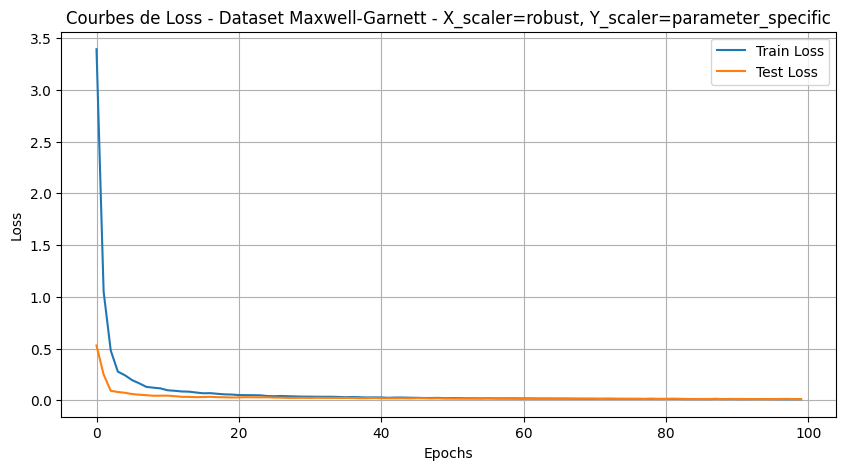

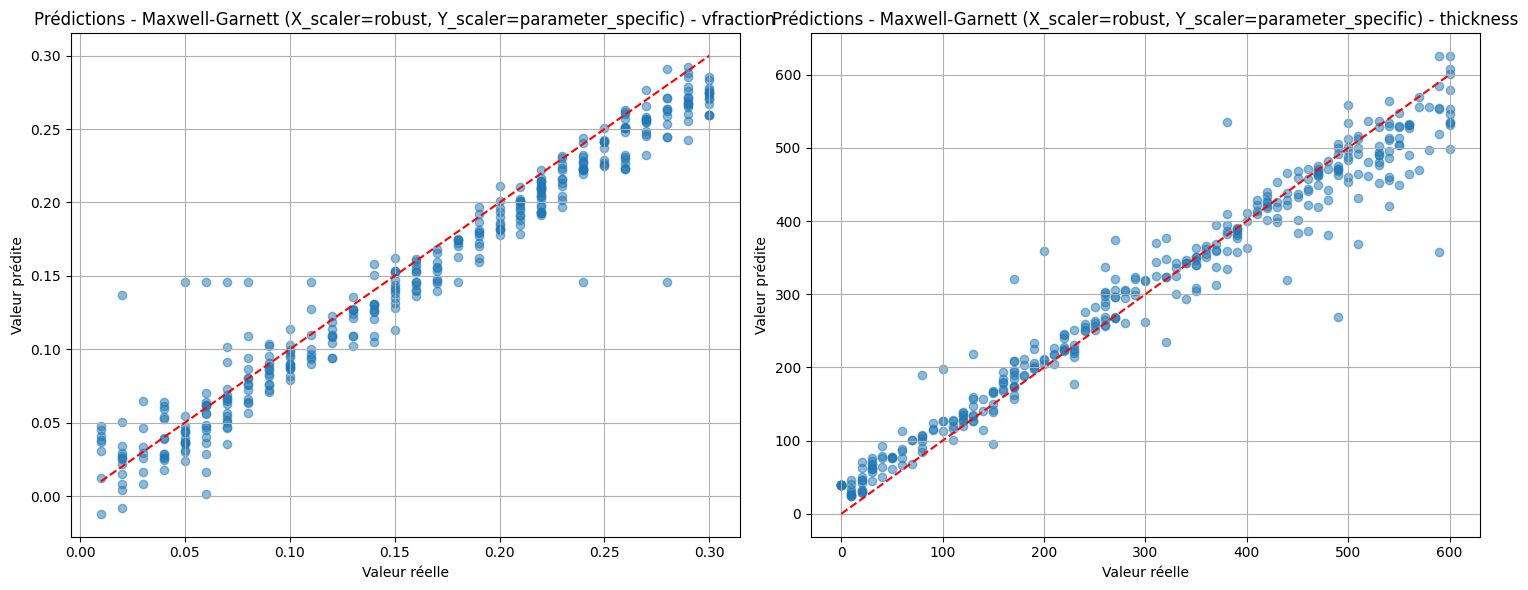


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=robust et Y_scaler=standard ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=robust, Y_scaler=standard) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.1729, Test Loss: 0.0839
Epoch 20/100 - Train Loss: 0.0953, Test Loss: 0.0620
Epoch 30/100 - Train Loss: 0.0717, Test Loss: 0.0524
Epoch 40/100 - Train Loss: 0.0590, Test Loss: 0.0607
Epoch 50/100 - Train Loss: 0.0471, Test Loss: 0.0468
Epoch 60/100 - Train Loss: 0.0438, Test Loss: 0.0434
Epoch 70/100 - Train Loss: 0.0413, Test Loss: 0.0407
Epoch 80/100 - Train Loss: 0.0363, Test Loss: 0.0415
Epoch 90/100 - Train Loss: 0.0350, Test Loss: 0.0408
Epoch 100/100 - Train Loss: 0.0322, Test Loss: 0.0379
Entraînement terminé en 28.08 secondes
Meilleure loss sur le test set: 0.0346


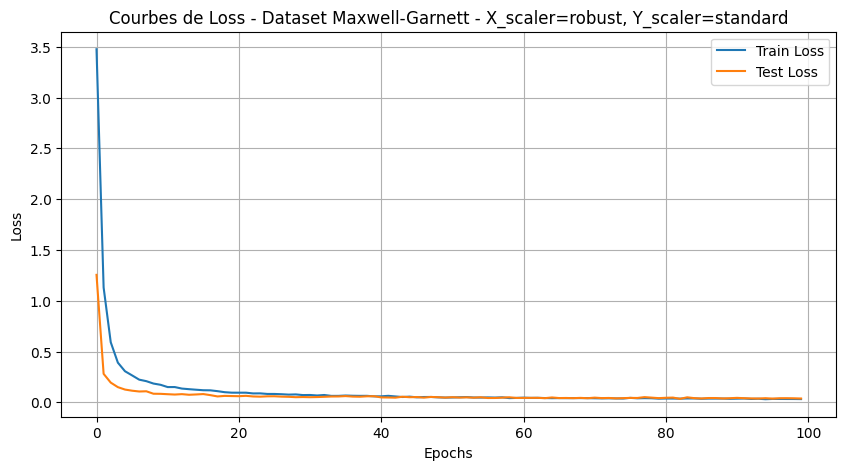

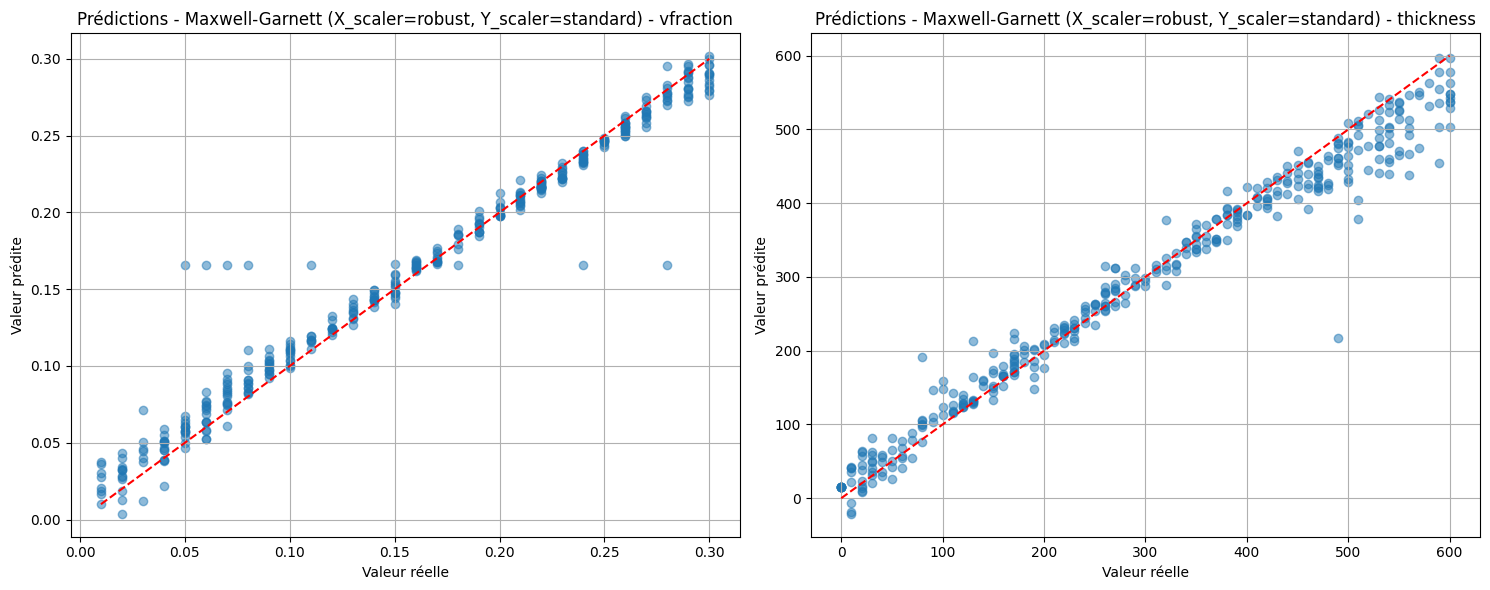


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=robust et Y_scaler=minmax ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=robust, Y_scaler=minmax) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.0857, Test Loss: 0.0306
Epoch 20/100 - Train Loss: 0.0410, Test Loss: 0.0203
Epoch 30/100 - Train Loss: 0.0242, Test Loss: 0.0169
Epoch 40/100 - Train Loss: 0.0171, Test Loss: 0.0129
Epoch 50/100 - Train Loss: 0.0143, Test Loss: 0.0111
Epoch 60/100 - Train Loss: 0.0116, Test Loss: 0.0117
Epoch 70/100 - Train Loss: 0.0097, Test Loss: 0.0102
Epoch 80/100 - Train Loss: 0.0095, Test Loss: 0.0101
Epoch 90/100 - Train Loss: 0.0081, Test Loss: 0.0082
Epoch 100/100 - Train Loss: 0.0071, Test Loss: 0.0066
Entraînement terminé en 21.85 secondes
Meilleure loss sur le test set: 0.0066


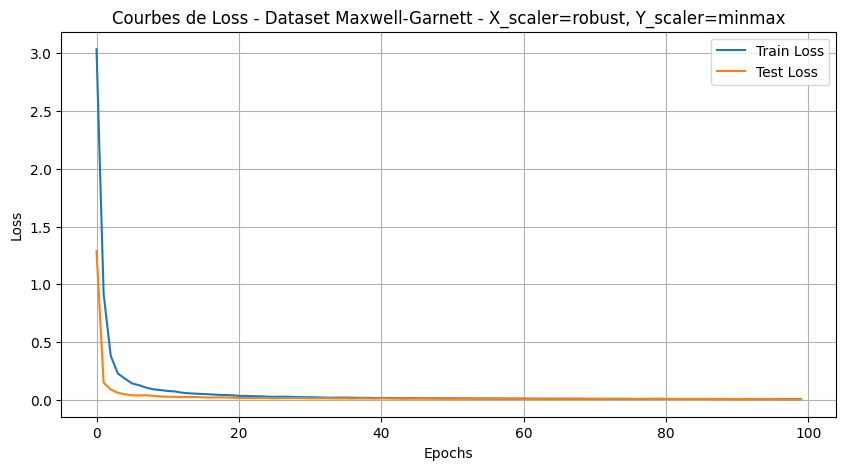

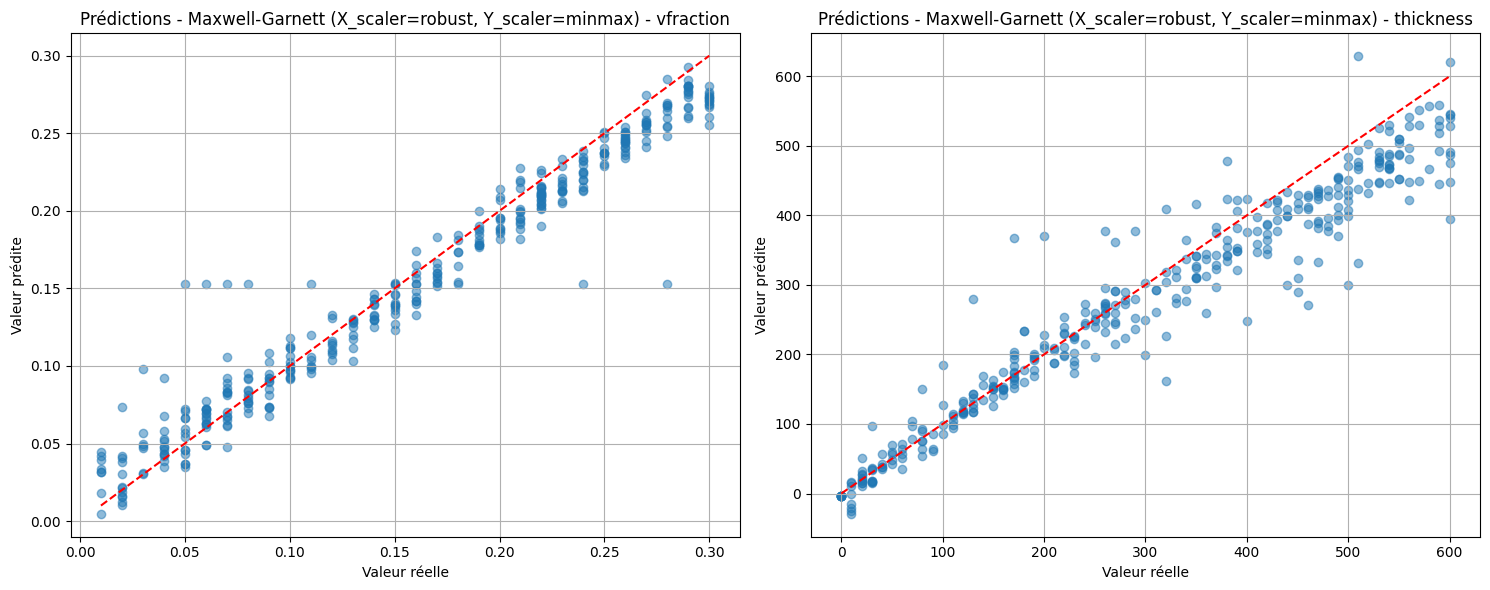


=== Entraînement sur le dataset Maxwell-Garnett avec X_scaler=robust et Y_scaler=robust ===

=== Entraînement sur le dataset Maxwell-Garnett (X_scaler=robust, Y_scaler=robust) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['vfraction', 'thickness']
Epoch 10/100 - Train Loss: 0.1156, Test Loss: 0.0409
Epoch 20/100 - Train Loss: 0.0622, Test Loss: 0.0273
Epoch 30/100 - Train Loss: 0.0417, Test Loss: 0.0255
Epoch 40/100 - Train Loss: 0.0327, Test Loss: 0.0234
Epoch 50/100 - Train Loss: 0.0286, Test Loss: 0.0203
Epoch 60/100 - Train Loss: 0.0226, Test Loss: 0.0188
Epoch 70/100 - Train Loss: 0.0198, Test Loss: 0.0180
Epoch 80/100 - Train Loss: 0.0175, Test Loss: 0.0168
Epoch 90/100 - Train Loss: 0.0174, Test Loss: 0.0183
Epoch 100/100 - Train Loss: 0.0145, Test Loss: 0.0142
Entraînement terminé en 23.02 secondes
Meilleure loss sur le test set: 0.0135


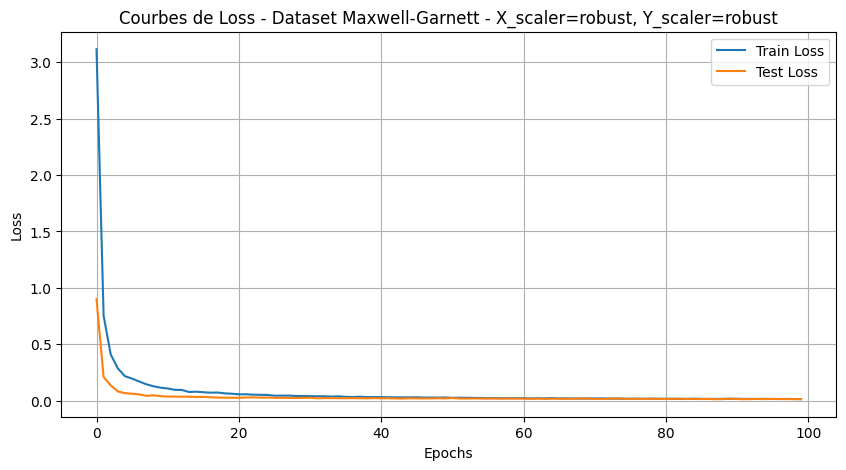

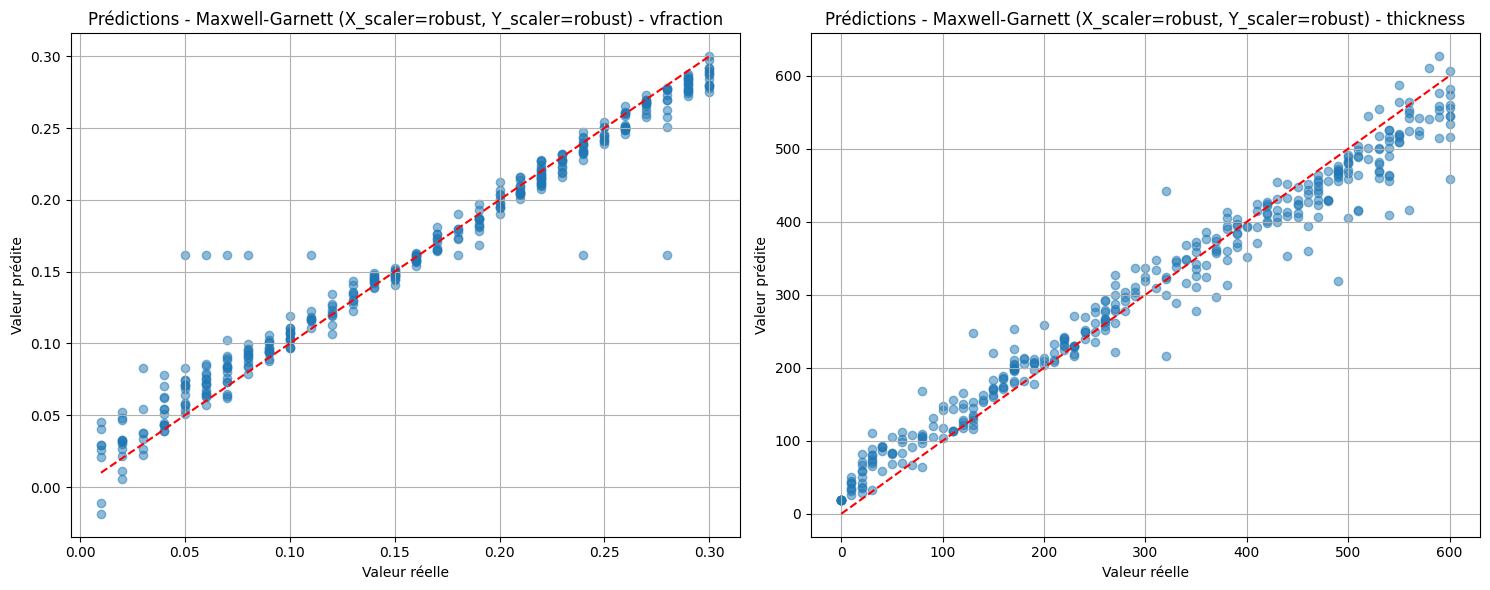


=== Entraînement sur le dataset Lorentz avec X_scaler=standard et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Lorentz (X_scaler=standard, Y_scaler=parameter_specific) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 803.5684, Test Loss: 371.6594
Epoch 20/100 - Train Loss: 663.9373, Test Loss: 326.2171
Epoch 30/100 - Train Loss: 542.9360, Test Loss: 269.7402
Epoch 40/100 - Train Loss: 648.3359, Test Loss: 264.3650
Epoch 50/100 - Train Loss: 516.8504, Test Loss: 238.7945
Epoch 60/100 - Train Loss: 437.5995, Test Loss: 291.1889
Epoch 70/100 - Train Loss: 453.9802, Test Loss: 266.5442
Epoch 80/100 - Train Loss: 459.5456, Test Loss: 240.0764
Epoch 90/100 - Train Loss: 531.9714, Test Loss: 256.6321
Early stopping à l'epoch 96
Entraînement terminé en 21.17 secondes
Meilleure loss sur le test set: 190.3148


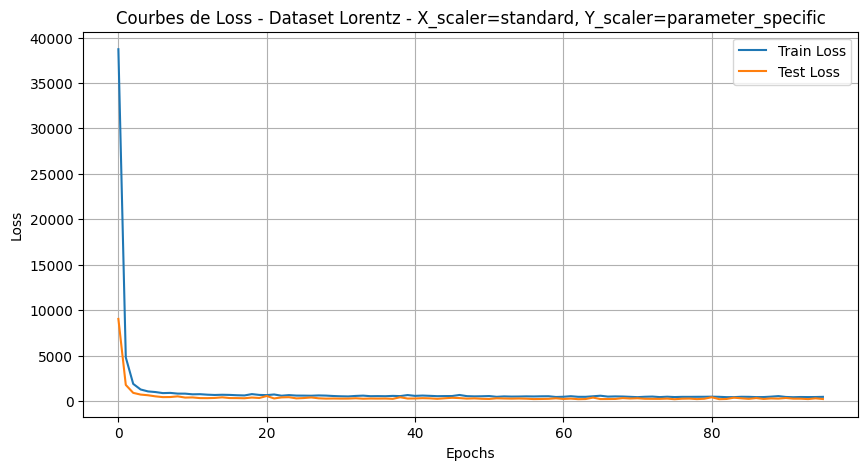

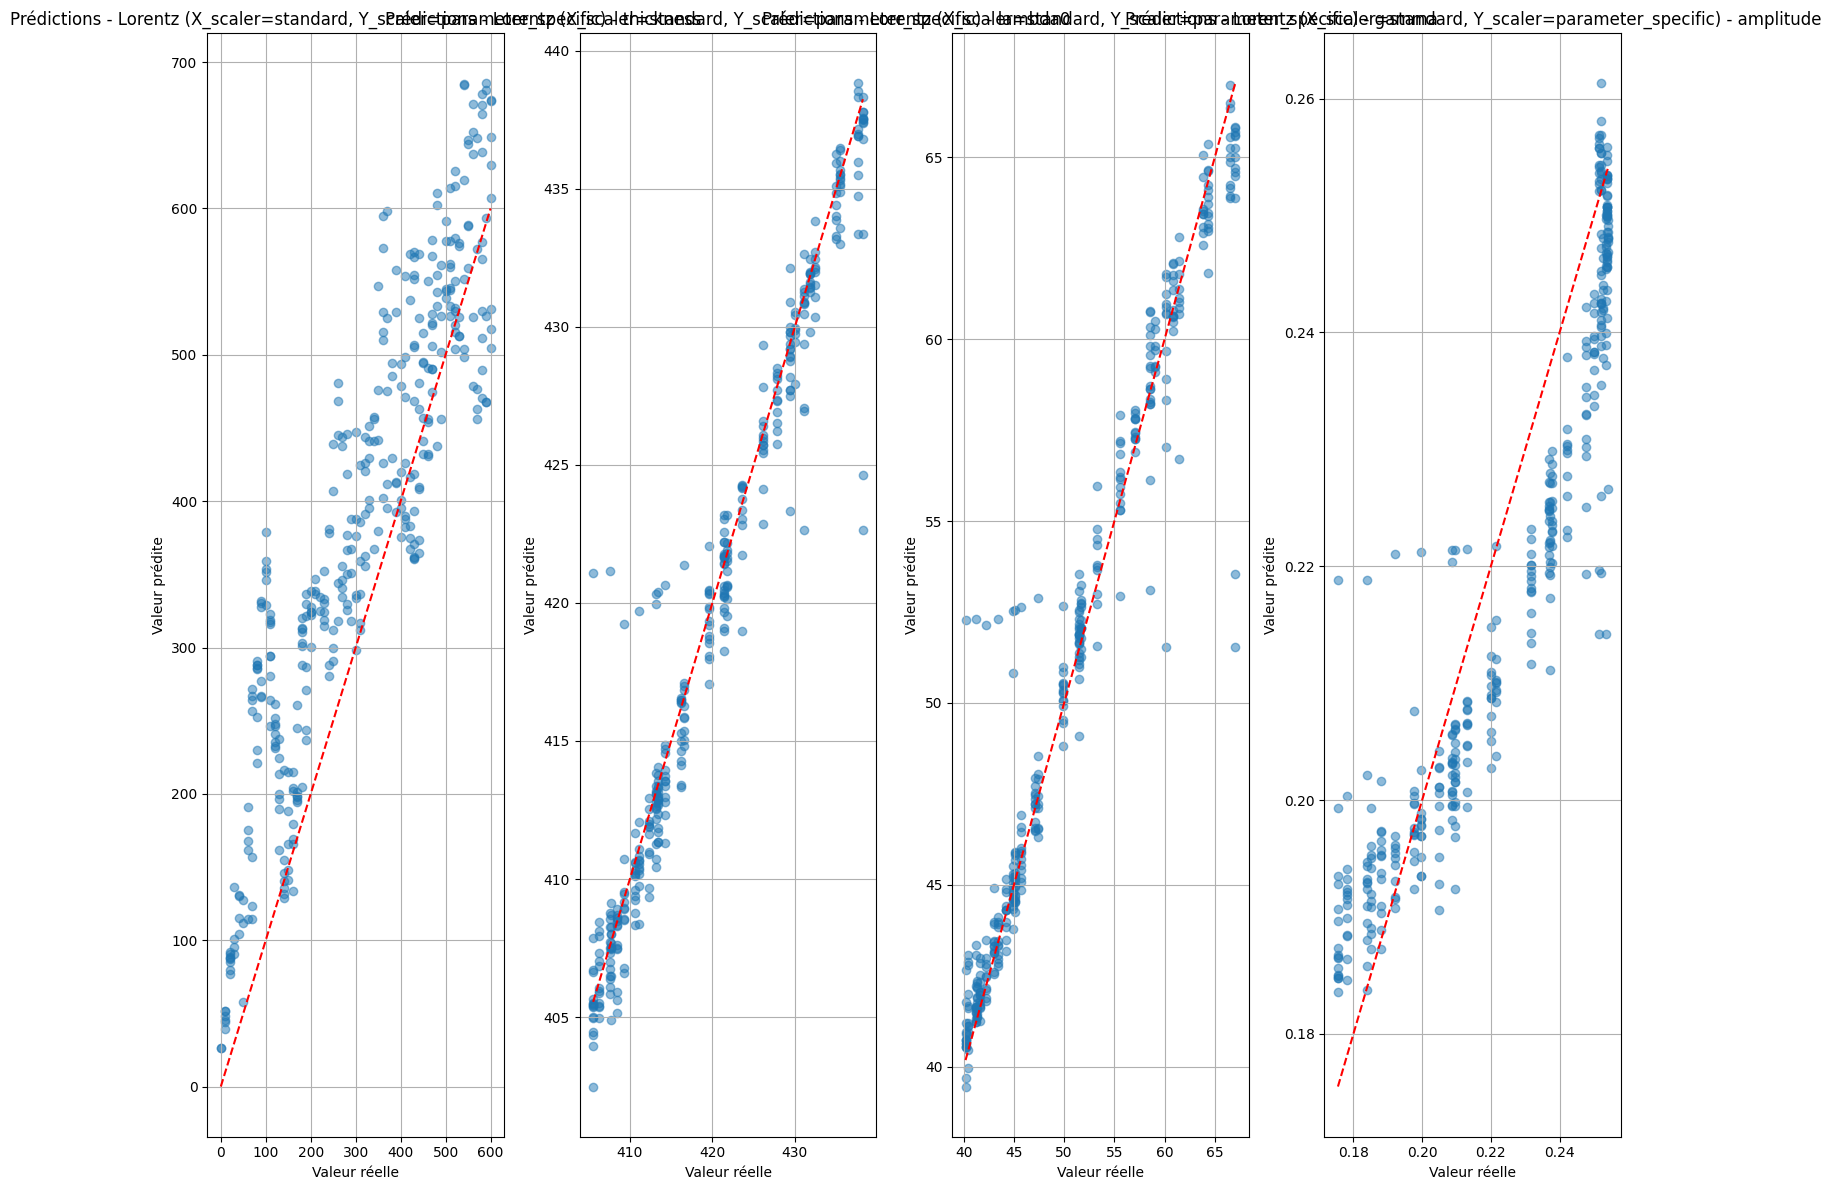


=== Entraînement sur le dataset Lorentz avec X_scaler=standard et Y_scaler=standard ===

=== Entraînement sur le dataset Lorentz (X_scaler=standard, Y_scaler=standard) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 0.1458, Test Loss: 0.0757
Epoch 20/100 - Train Loss: 0.1090, Test Loss: 0.0590
Epoch 30/100 - Train Loss: 0.0867, Test Loss: 0.0589
Epoch 40/100 - Train Loss: 0.0763, Test Loss: 0.0528
Epoch 50/100 - Train Loss: 0.0832, Test Loss: 0.0420
Epoch 60/100 - Train Loss: 0.0626, Test Loss: 0.0413
Epoch 70/100 - Train Loss: 0.0741, Test Loss: 0.0470
Epoch 80/100 - Train Loss: 0.0549, Test Loss: 0.0434
Epoch 90/100 - Train Loss: 0.0509, Test Loss: 0.0429
Epoch 100/100 - Train Loss: 0.0520, Test Loss: 0.0374
Entraînement terminé en 21.29 secondes
Meilleure loss sur le test set: 0.0327


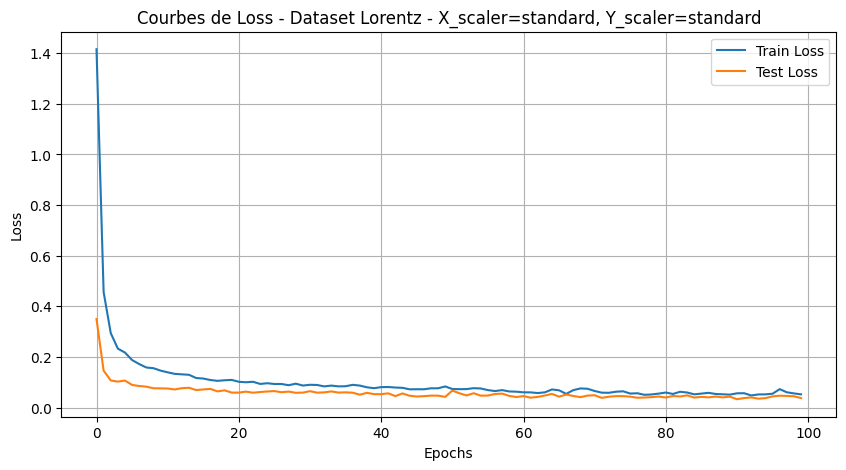

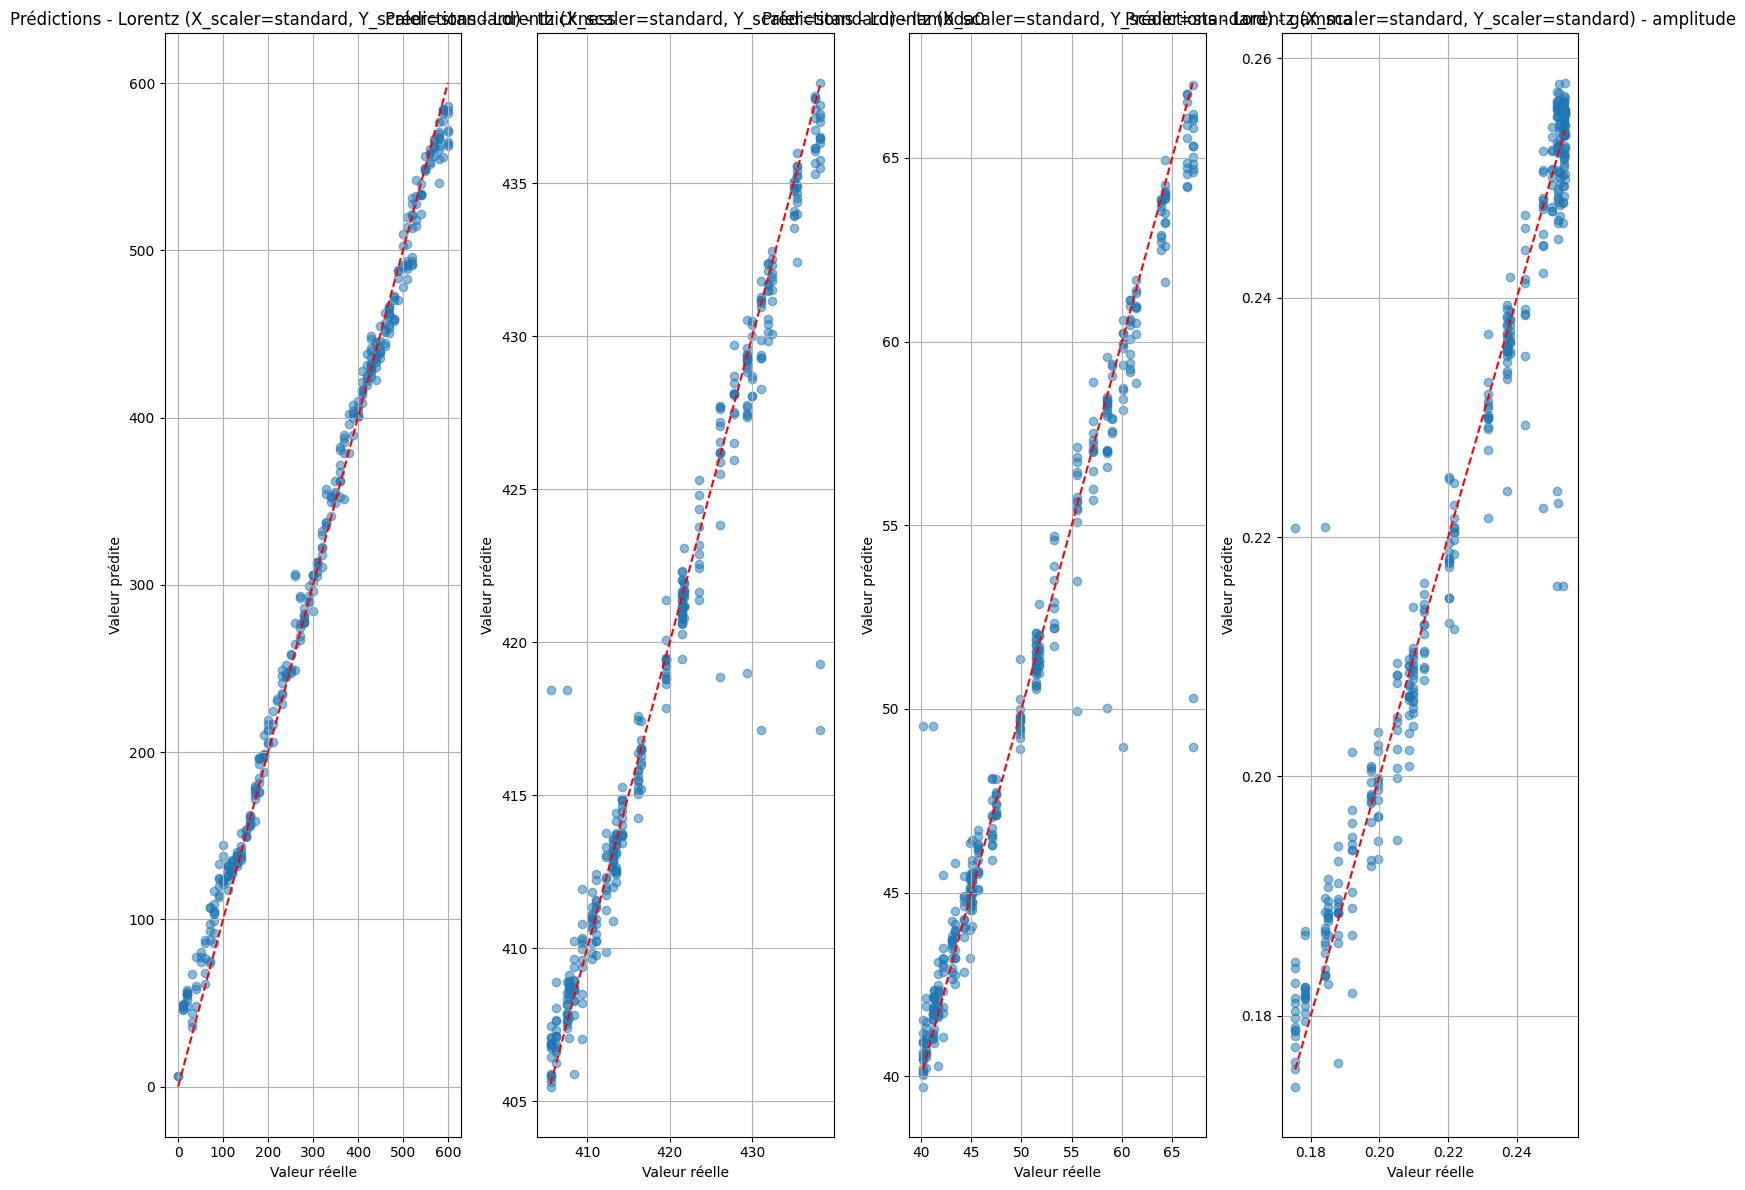


=== Entraînement sur le dataset Lorentz avec X_scaler=standard et Y_scaler=minmax ===

=== Entraînement sur le dataset Lorentz (X_scaler=standard, Y_scaler=minmax) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 0.0425, Test Loss: 0.0159
Epoch 20/100 - Train Loss: 0.0224, Test Loss: 0.0121
Epoch 30/100 - Train Loss: 0.0174, Test Loss: 0.0097
Epoch 40/100 - Train Loss: 0.0137, Test Loss: 0.0083
Epoch 50/100 - Train Loss: 0.0119, Test Loss: 0.0084
Epoch 60/100 - Train Loss: 0.0107, Test Loss: 0.0066
Epoch 70/100 - Train Loss: 0.0101, Test Loss: 0.0068
Epoch 80/100 - Train Loss: 0.0098, Test Loss: 0.0055
Epoch 90/100 - Train Loss: 0.0086, Test Loss: 0.0058
Epoch 100/100 - Train Loss: 0.0082, Test Loss: 0.0049
Entraînement terminé en 21.39 secondes
Meilleure loss sur le test set: 0.0047


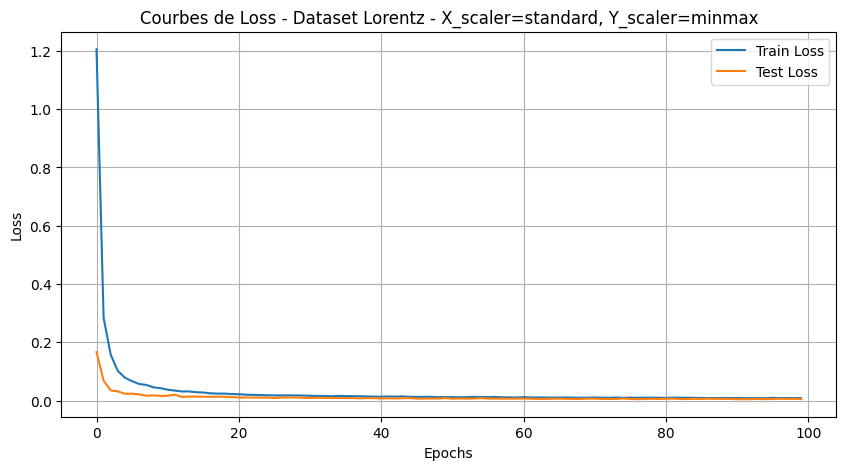

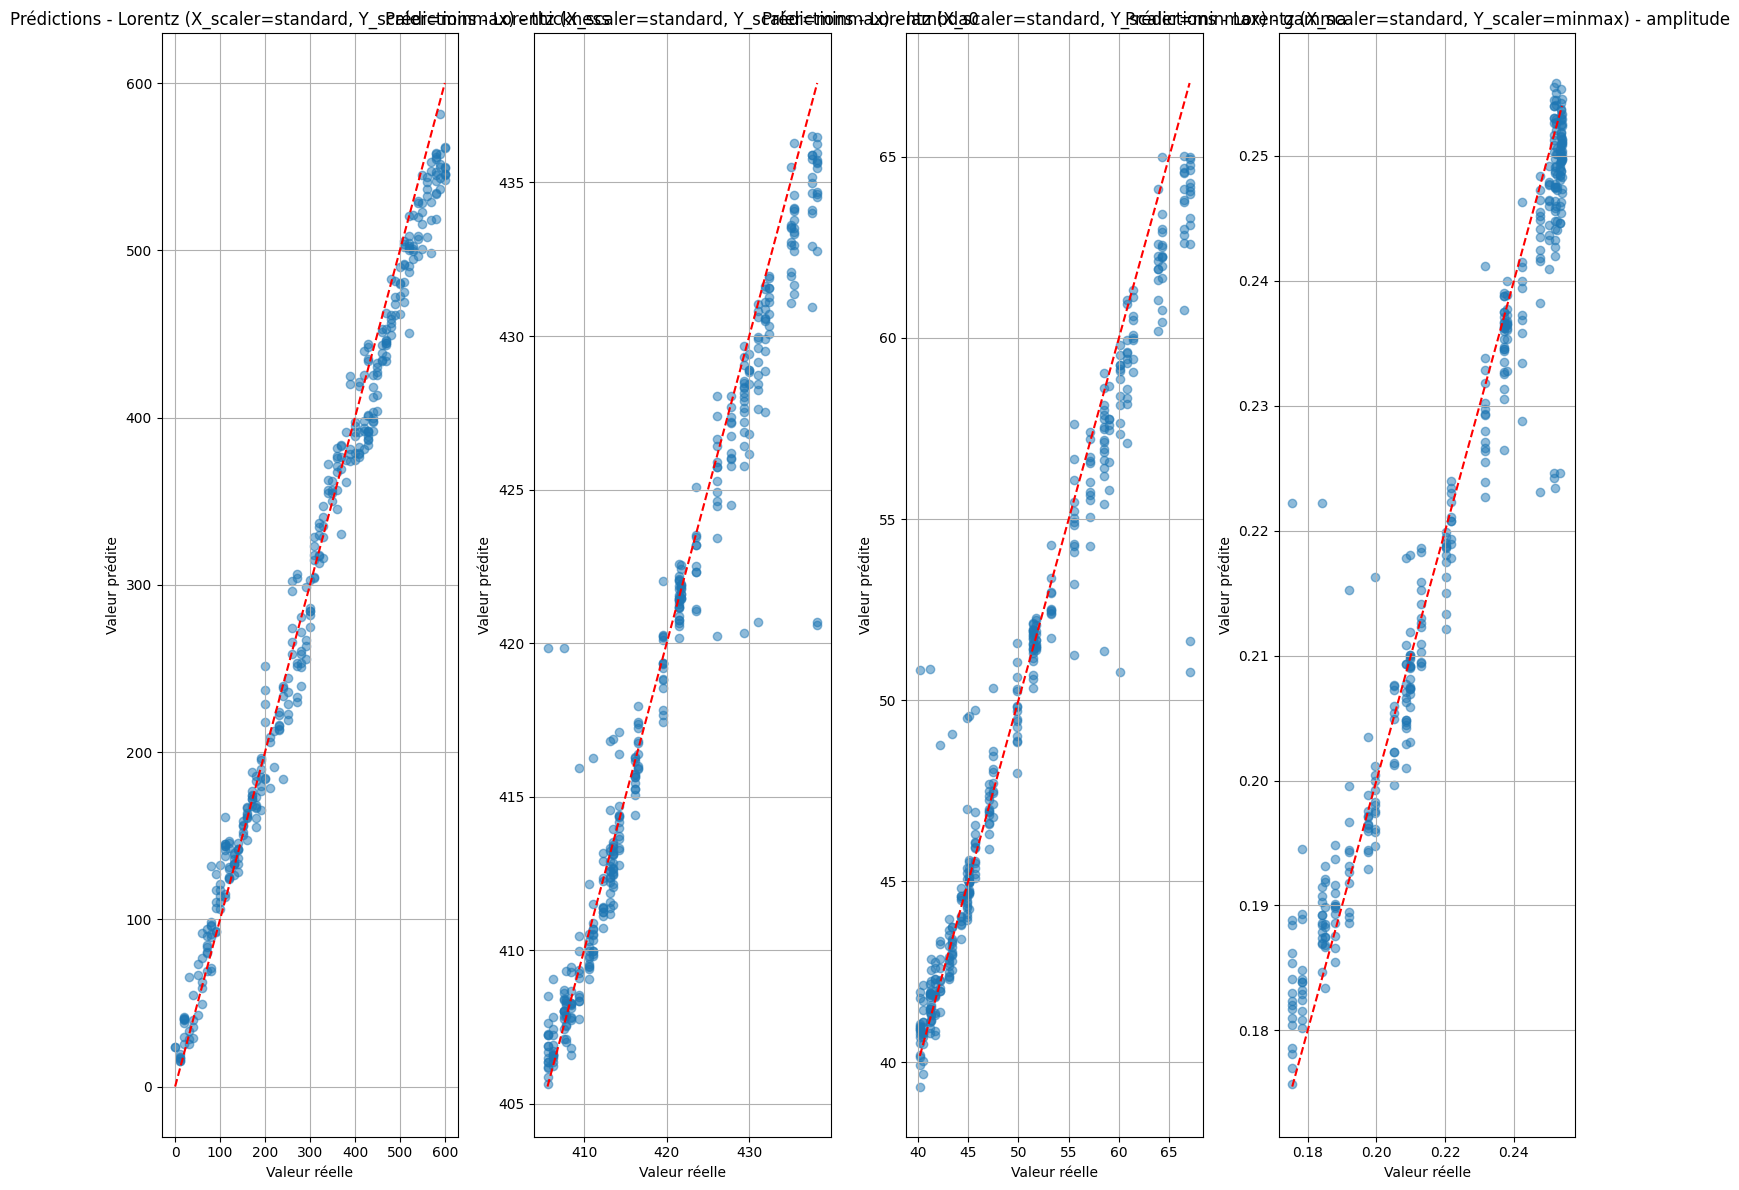


=== Entraînement sur le dataset Lorentz avec X_scaler=standard et Y_scaler=robust ===

=== Entraînement sur le dataset Lorentz (X_scaler=standard, Y_scaler=robust) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 0.0680, Test Loss: 0.0266
Epoch 20/100 - Train Loss: 0.0425, Test Loss: 0.0241
Epoch 30/100 - Train Loss: 0.0341, Test Loss: 0.0197
Epoch 40/100 - Train Loss: 0.0322, Test Loss: 0.0216
Epoch 50/100 - Train Loss: 0.0265, Test Loss: 0.0155
Epoch 60/100 - Train Loss: 0.0228, Test Loss: 0.0154
Epoch 70/100 - Train Loss: 0.0216, Test Loss: 0.0151
Epoch 80/100 - Train Loss: 0.0189, Test Loss: 0.0125
Epoch 90/100 - Train Loss: 0.0200, Test Loss: 0.0121
Epoch 100/100 - Train Loss: 0.0193, Test Loss: 0.0154
Entraînement terminé en 21.78 secondes
Meilleure loss sur le test set: 0.0118


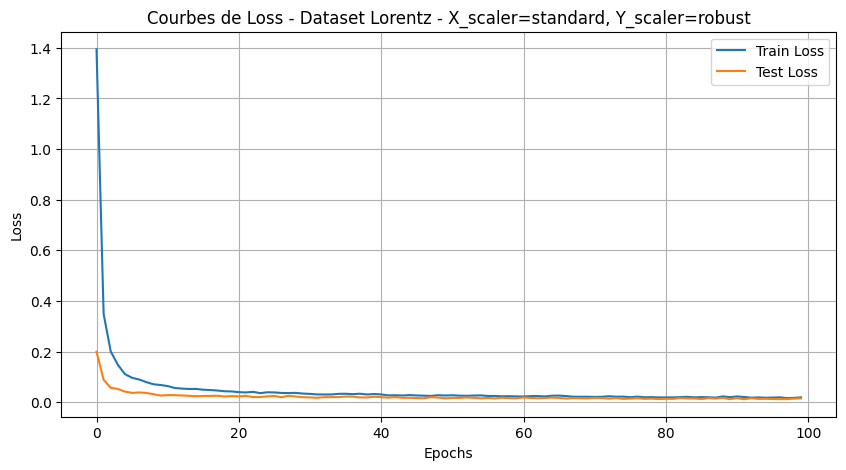

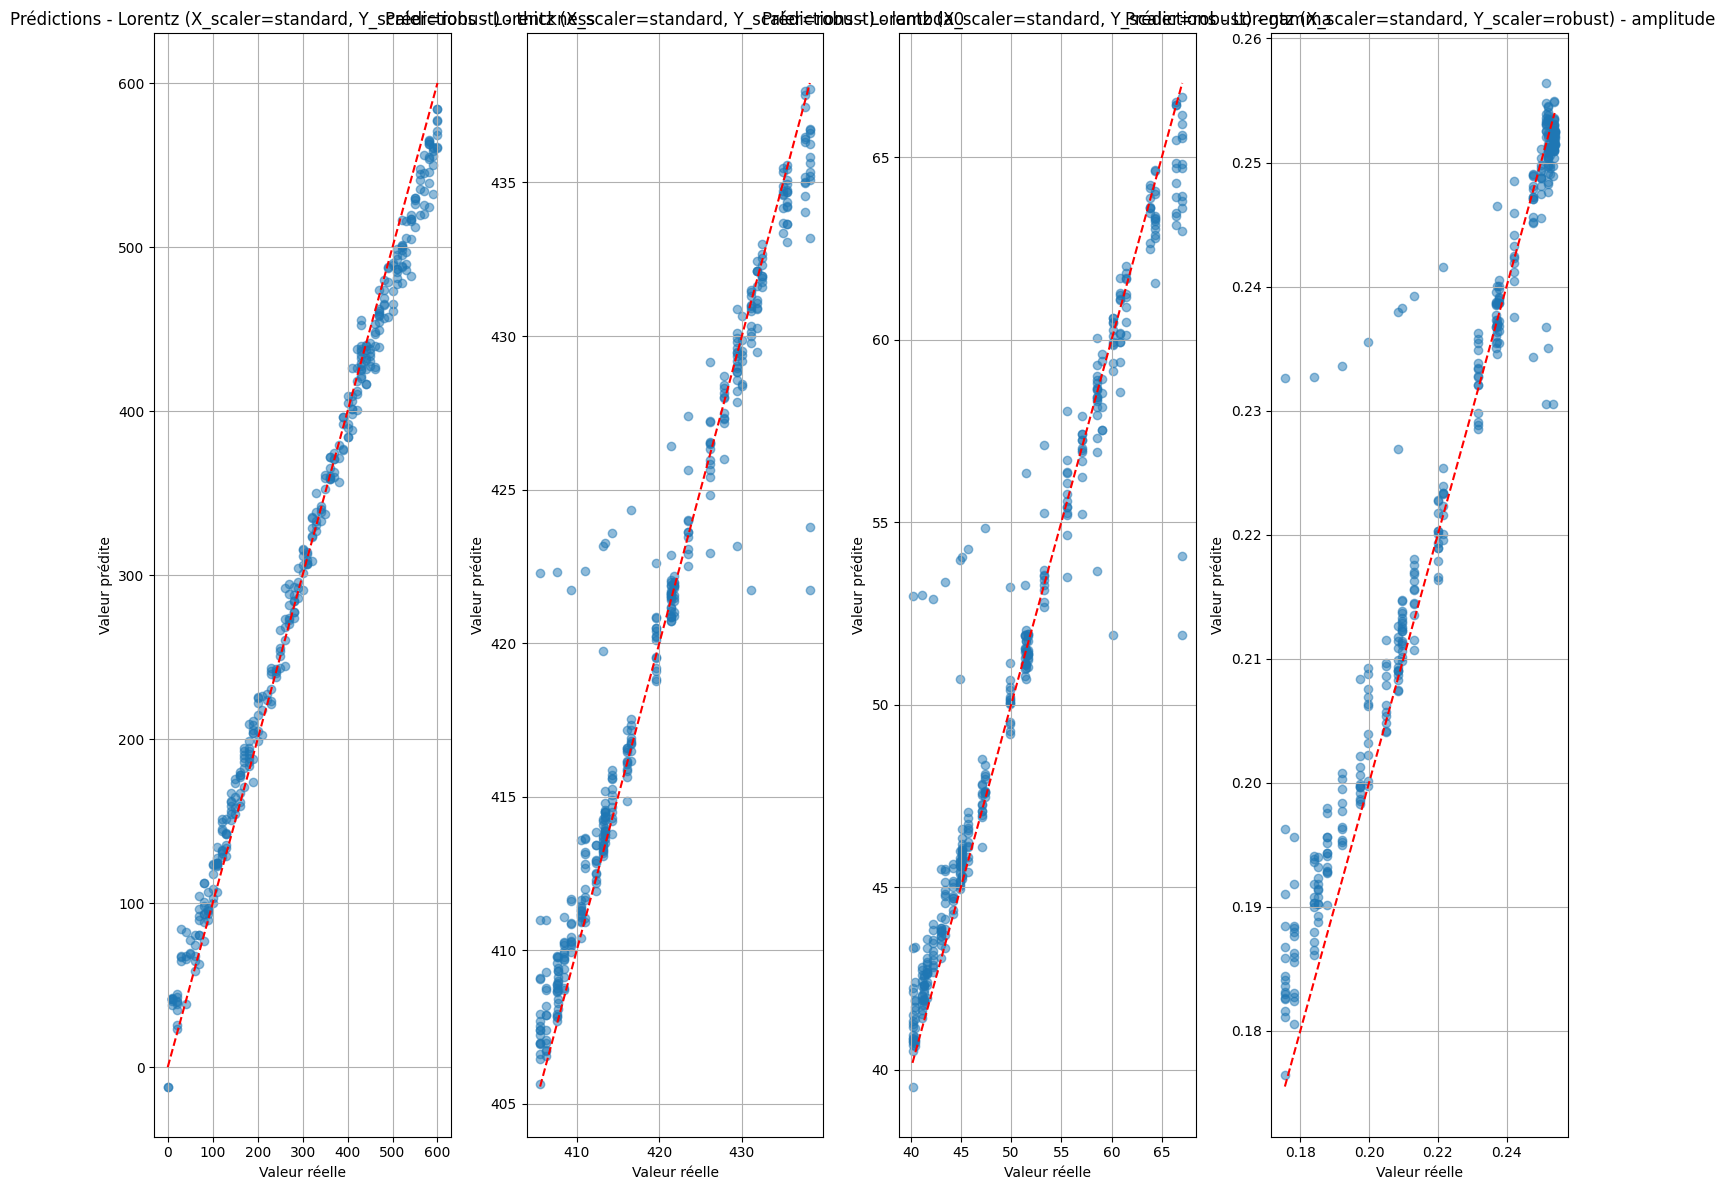


=== Entraînement sur le dataset Lorentz avec X_scaler=minmax et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Lorentz (X_scaler=minmax, Y_scaler=parameter_specific) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 3700.5089, Test Loss: 3100.5930
Epoch 20/100 - Train Loss: 2128.1538, Test Loss: 1872.9576
Epoch 30/100 - Train Loss: 1104.1458, Test Loss: 760.9449
Epoch 40/100 - Train Loss: 843.0780, Test Loss: 535.1971
Epoch 50/100 - Train Loss: 763.9329, Test Loss: 474.6302
Epoch 60/100 - Train Loss: 708.4000, Test Loss: 536.3043
Epoch 70/100 - Train Loss: 717.1579, Test Loss: 579.3418
Epoch 80/100 - Train Loss: 637.4437, Test Loss: 382.9041
Epoch 90/100 - Train Loss: 563.3796, Test Loss: 355.9355
Epoch 100/100 - Train Loss: 536.6866, Test Loss: 566.7119
Entraînement terminé en 21.71 secondes
Meilleure loss sur le test set: 330.5724


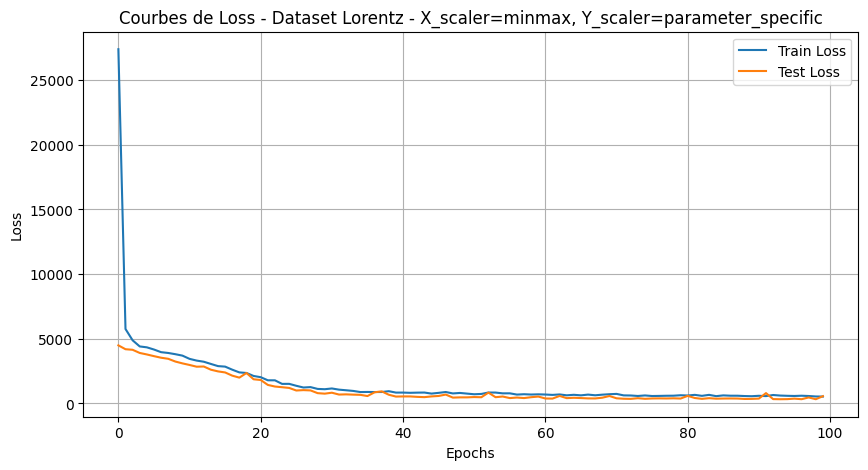

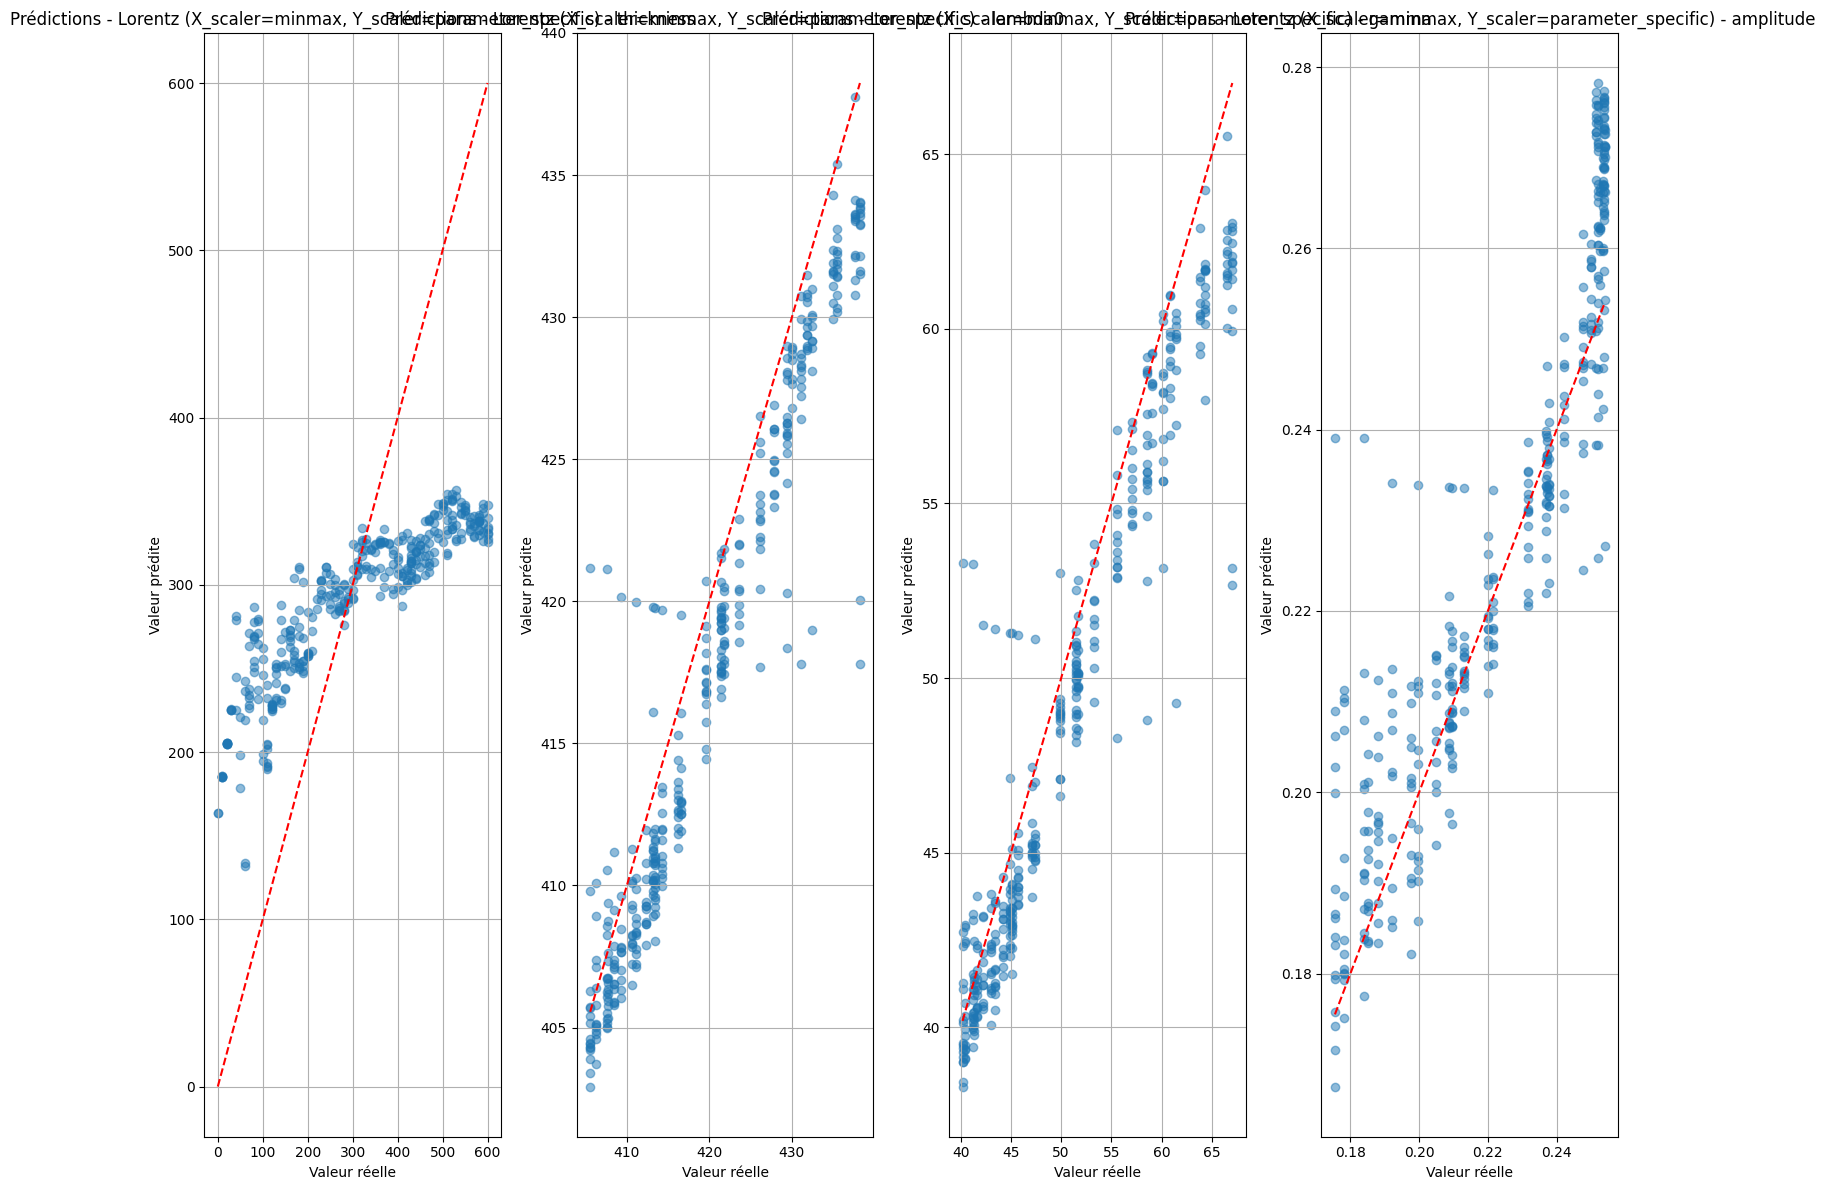


=== Entraînement sur le dataset Lorentz avec X_scaler=minmax et Y_scaler=standard ===

=== Entraînement sur le dataset Lorentz (X_scaler=minmax, Y_scaler=standard) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 0.1814, Test Loss: 0.1191
Epoch 20/100 - Train Loss: 0.1399, Test Loss: 0.1049
Epoch 30/100 - Train Loss: 0.1197, Test Loss: 0.0796
Epoch 40/100 - Train Loss: 0.0999, Test Loss: 0.0682
Epoch 50/100 - Train Loss: 0.0887, Test Loss: 0.0691
Epoch 60/100 - Train Loss: 0.0929, Test Loss: 0.0557
Early stopping à l'epoch 63
Entraînement terminé en 13.65 secondes
Meilleure loss sur le test set: 0.0546


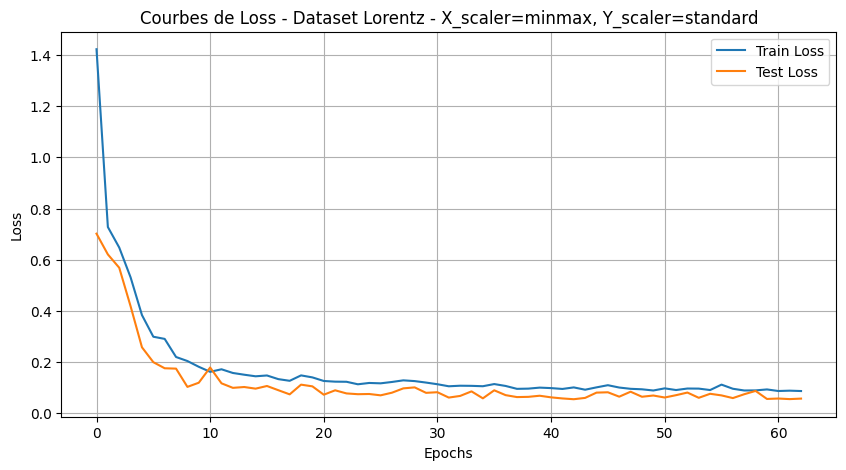

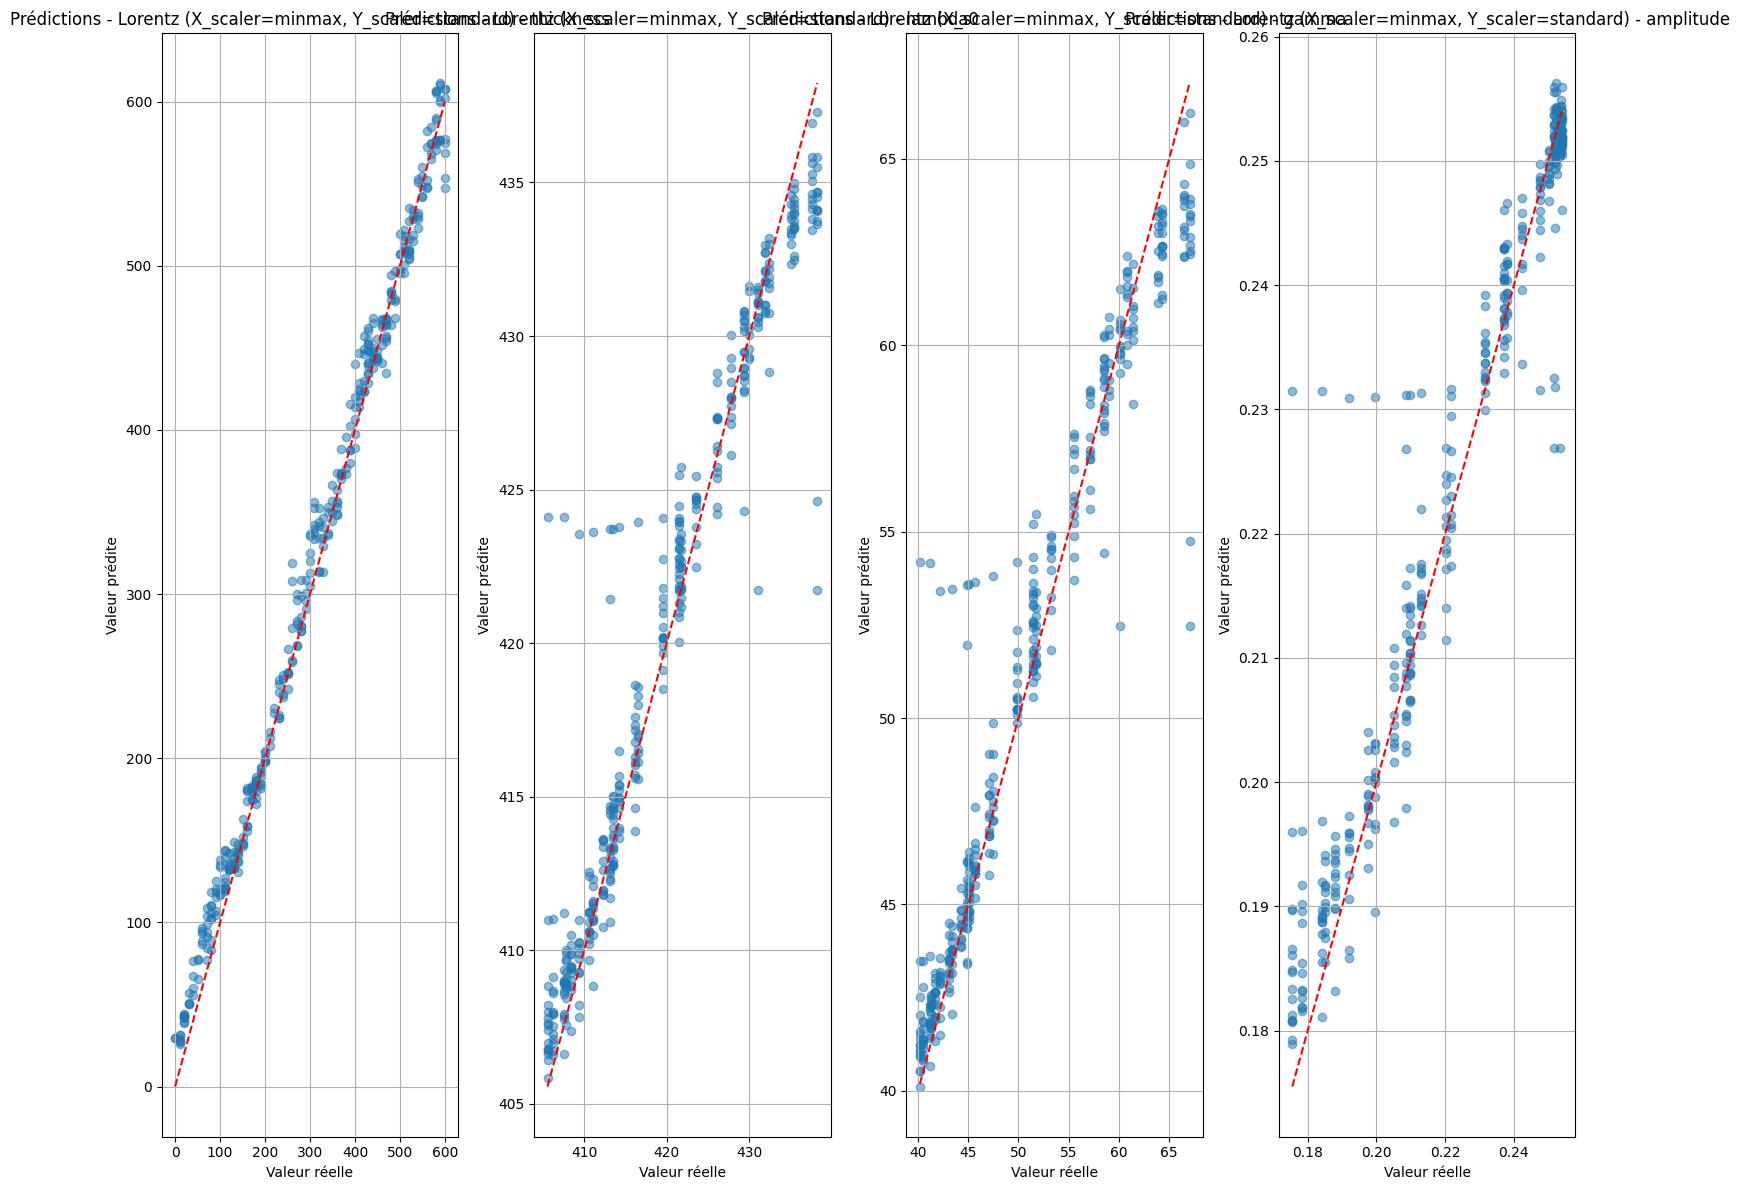


=== Entraînement sur le dataset Lorentz avec X_scaler=minmax et Y_scaler=minmax ===

=== Entraînement sur le dataset Lorentz (X_scaler=minmax, Y_scaler=minmax) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 0.0407, Test Loss: 0.0285
Epoch 20/100 - Train Loss: 0.0200, Test Loss: 0.0110
Epoch 30/100 - Train Loss: 0.0164, Test Loss: 0.0091
Epoch 40/100 - Train Loss: 0.0138, Test Loss: 0.0095
Epoch 50/100 - Train Loss: 0.0144, Test Loss: 0.0077
Epoch 60/100 - Train Loss: 0.0122, Test Loss: 0.0073
Epoch 70/100 - Train Loss: 0.0120, Test Loss: 0.0069
Epoch 80/100 - Train Loss: 0.0109, Test Loss: 0.0080
Epoch 90/100 - Train Loss: 0.0104, Test Loss: 0.0075
Epoch 100/100 - Train Loss: 0.0116, Test Loss: 0.0076
Entraînement terminé en 21.78 secondes
Meilleure loss sur le test set: 0.0055


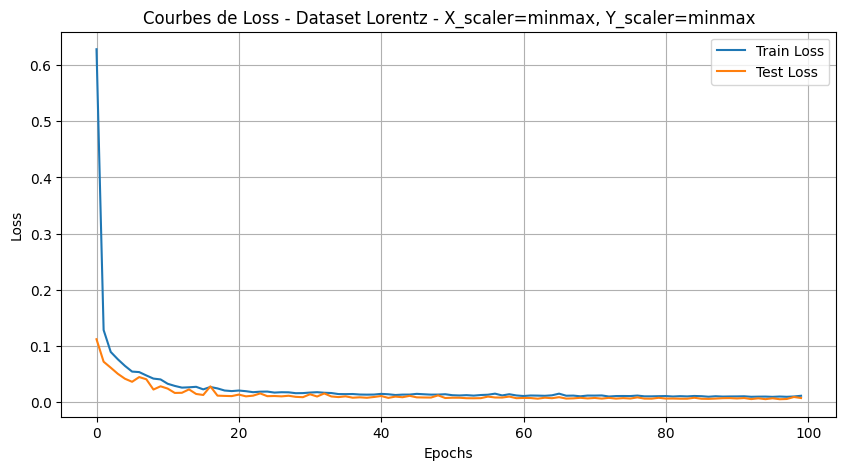

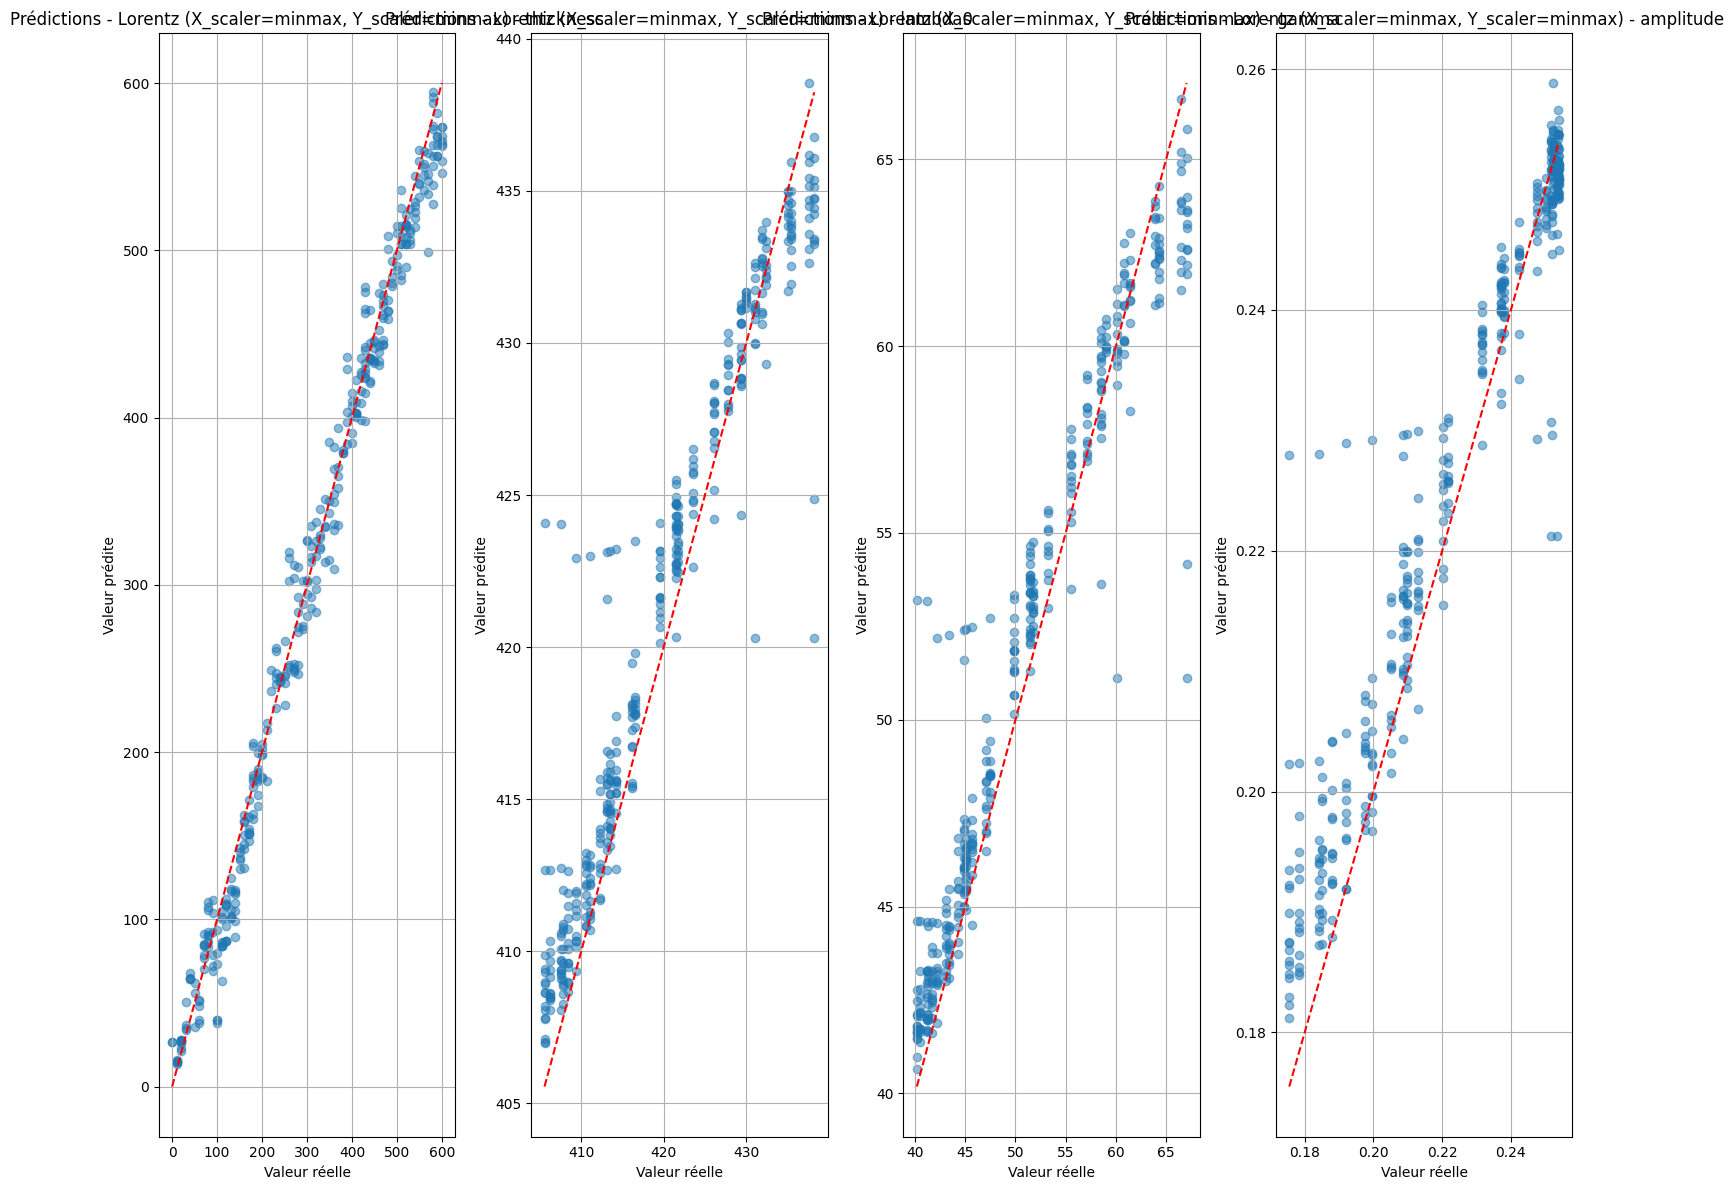


=== Entraînement sur le dataset Lorentz avec X_scaler=minmax et Y_scaler=robust ===

=== Entraînement sur le dataset Lorentz (X_scaler=minmax, Y_scaler=robust) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 0.0845, Test Loss: 0.0539
Epoch 20/100 - Train Loss: 0.0469, Test Loss: 0.0252
Epoch 30/100 - Train Loss: 0.0382, Test Loss: 0.0221
Epoch 40/100 - Train Loss: 0.0329, Test Loss: 0.0228
Epoch 50/100 - Train Loss: 0.0330, Test Loss: 0.0198
Epoch 60/100 - Train Loss: 0.0332, Test Loss: 0.0184
Epoch 70/100 - Train Loss: 0.0277, Test Loss: 0.0230
Epoch 80/100 - Train Loss: 0.0285, Test Loss: 0.0185
Early stopping à l'epoch 89
Entraînement terminé en 19.40 secondes
Meilleure loss sur le test set: 0.0154


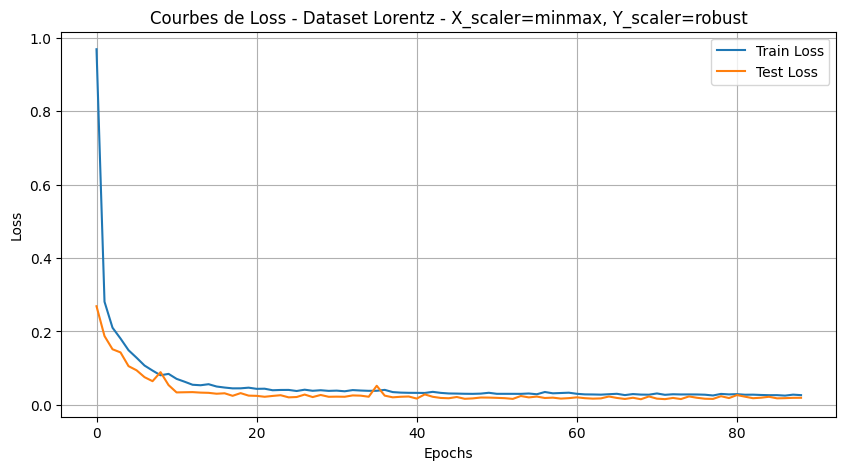

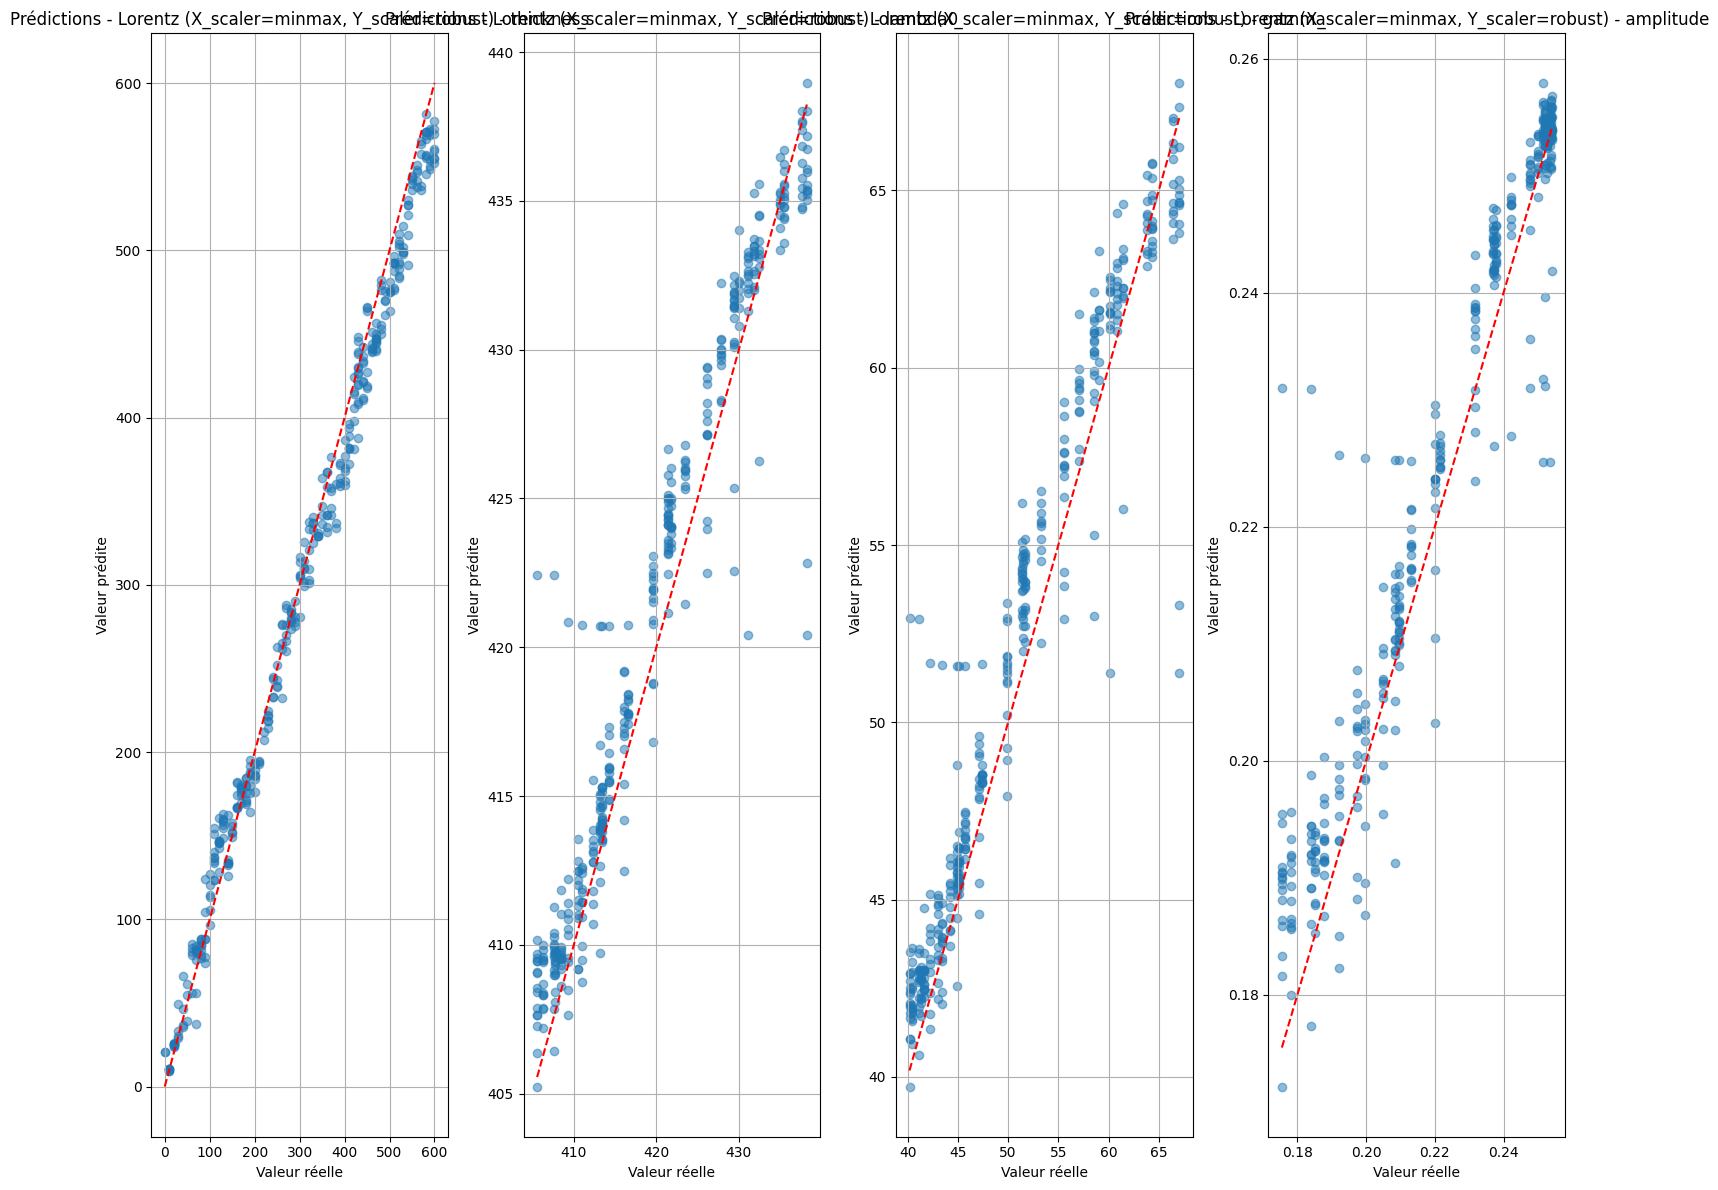


=== Entraînement sur le dataset Lorentz avec X_scaler=robust et Y_scaler=parameter_specific ===

=== Entraînement sur le dataset Lorentz (X_scaler=robust, Y_scaler=parameter_specific) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 986.5565, Test Loss: 422.5735
Epoch 20/100 - Train Loss: 1090.5871, Test Loss: 677.2732
Epoch 30/100 - Train Loss: 723.3232, Test Loss: 417.1084
Early stopping à l'epoch 39
Entraînement terminé en 8.76 secondes
Meilleure loss sur le test set: 291.9111


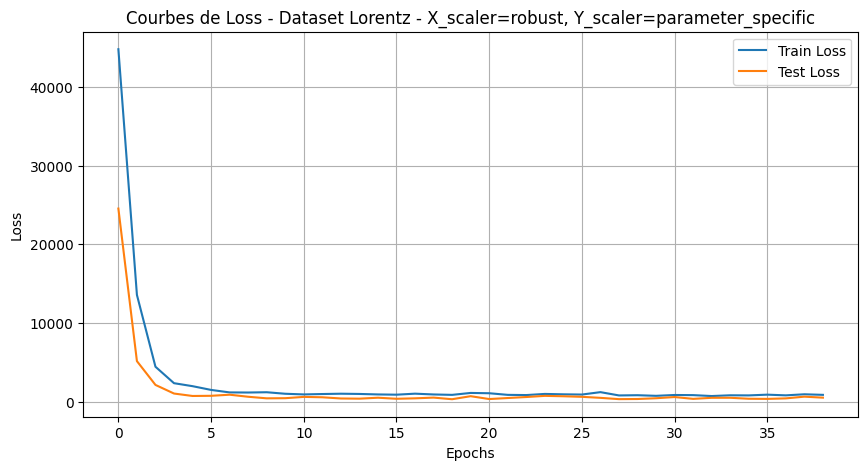

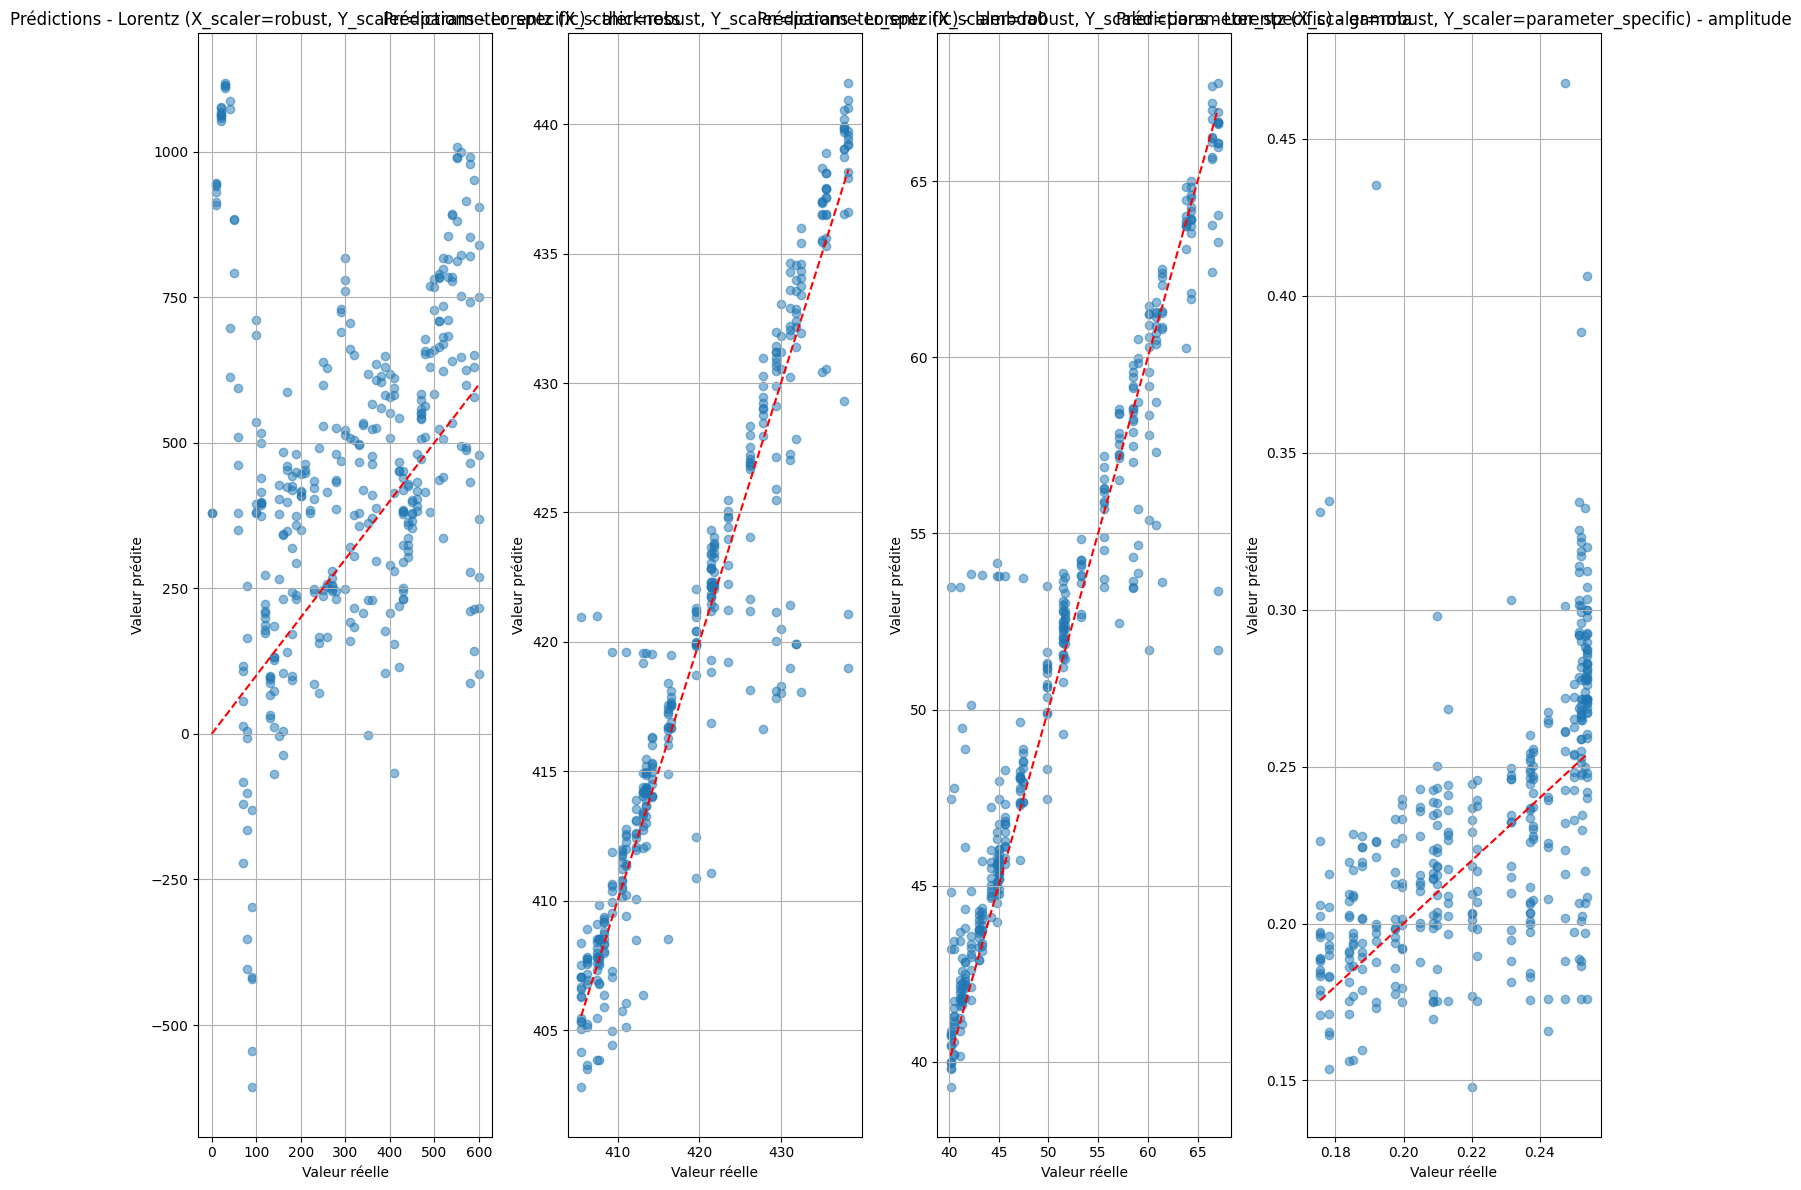


=== Entraînement sur le dataset Lorentz avec X_scaler=robust et Y_scaler=standard ===

=== Entraînement sur le dataset Lorentz (X_scaler=robust, Y_scaler=standard) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 2.7590, Test Loss: 0.5535
Epoch 20/100 - Train Loss: 1.0086, Test Loss: 0.2666
Epoch 30/100 - Train Loss: 0.5664, Test Loss: 0.1774
Epoch 40/100 - Train Loss: 0.4157, Test Loss: 0.1474
Epoch 50/100 - Train Loss: 0.3350, Test Loss: 0.1229
Epoch 60/100 - Train Loss: 0.2847, Test Loss: 0.1195
Epoch 70/100 - Train Loss: 0.2352, Test Loss: 0.1177
Epoch 80/100 - Train Loss: 0.2010, Test Loss: 0.1073
Epoch 90/100 - Train Loss: 0.1864, Test Loss: 0.0925
Epoch 100/100 - Train Loss: 0.1605, Test Loss: 0.0950
Entraînement terminé en 22.45 secondes
Meilleure loss sur le test set: 0.0925


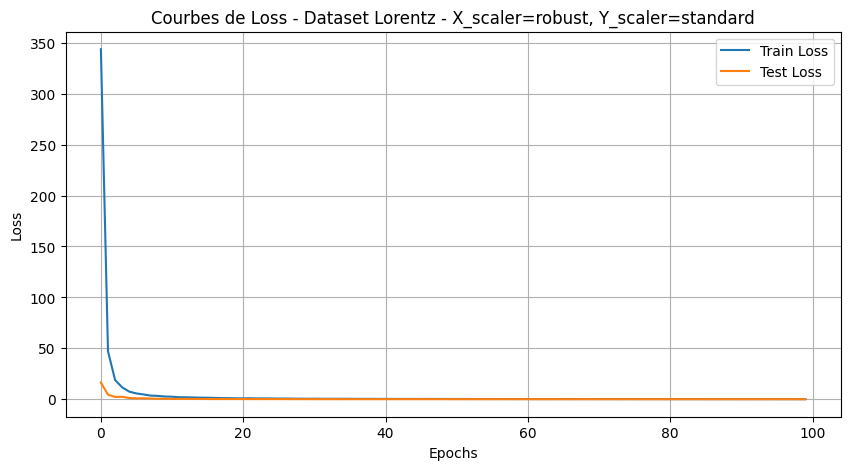

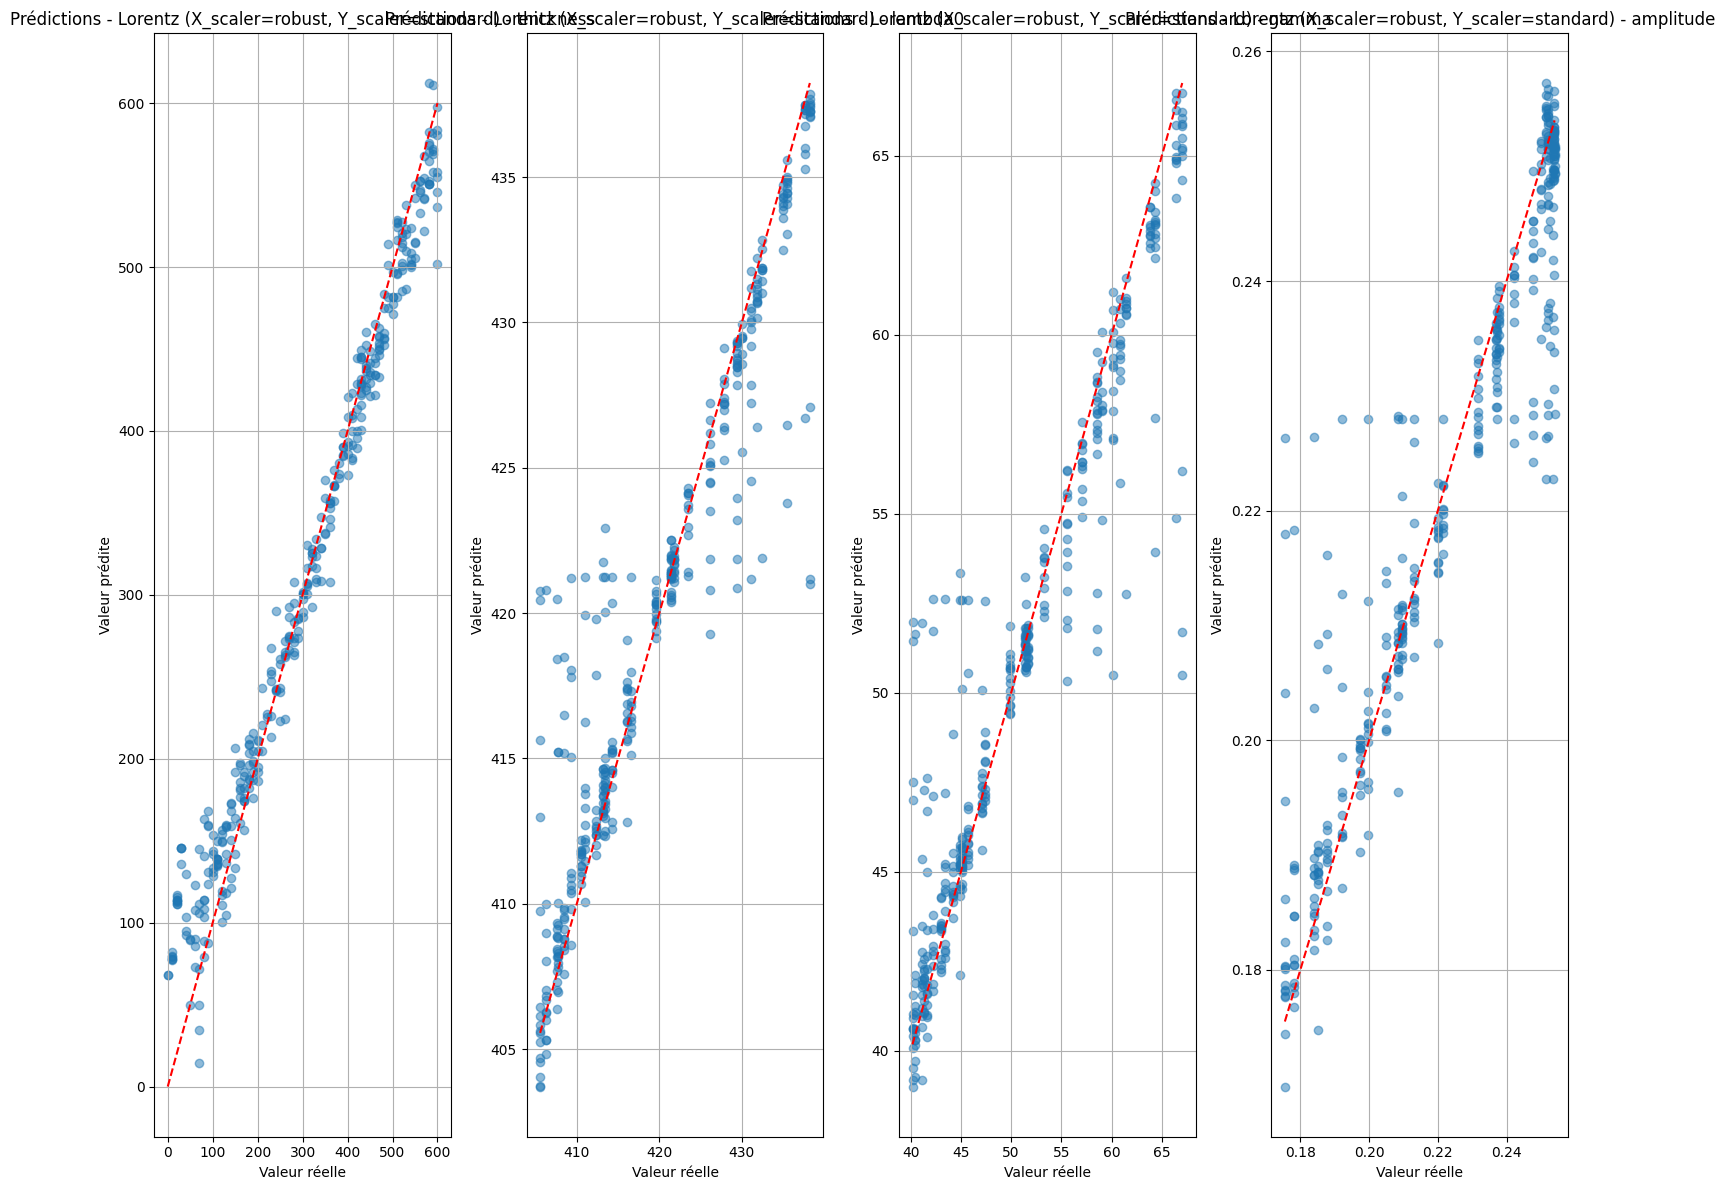


=== Entraînement sur le dataset Lorentz avec X_scaler=robust et Y_scaler=minmax ===

=== Entraînement sur le dataset Lorentz (X_scaler=robust, Y_scaler=minmax) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 2.3458, Test Loss: 0.5200
Epoch 20/100 - Train Loss: 0.8655, Test Loss: 0.1103
Epoch 30/100 - Train Loss: 0.4140, Test Loss: 0.0734
Epoch 40/100 - Train Loss: 0.2737, Test Loss: 0.0469
Epoch 50/100 - Train Loss: 0.1938, Test Loss: 0.0369
Epoch 60/100 - Train Loss: 0.1340, Test Loss: 0.0290
Epoch 70/100 - Train Loss: 0.0961, Test Loss: 0.0256
Epoch 80/100 - Train Loss: 0.0895, Test Loss: 0.0227
Epoch 90/100 - Train Loss: 0.0708, Test Loss: 0.0202
Epoch 100/100 - Train Loss: 0.0623, Test Loss: 0.0188
Entraînement terminé en 22.03 secondes
Meilleure loss sur le test set: 0.0183


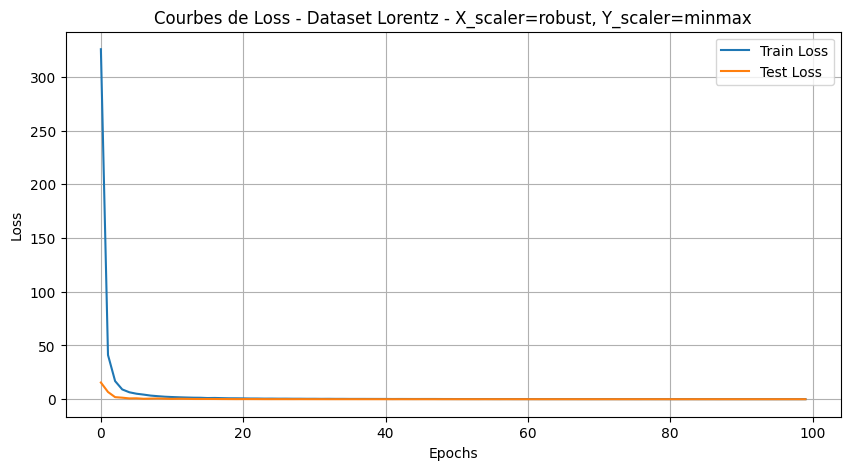

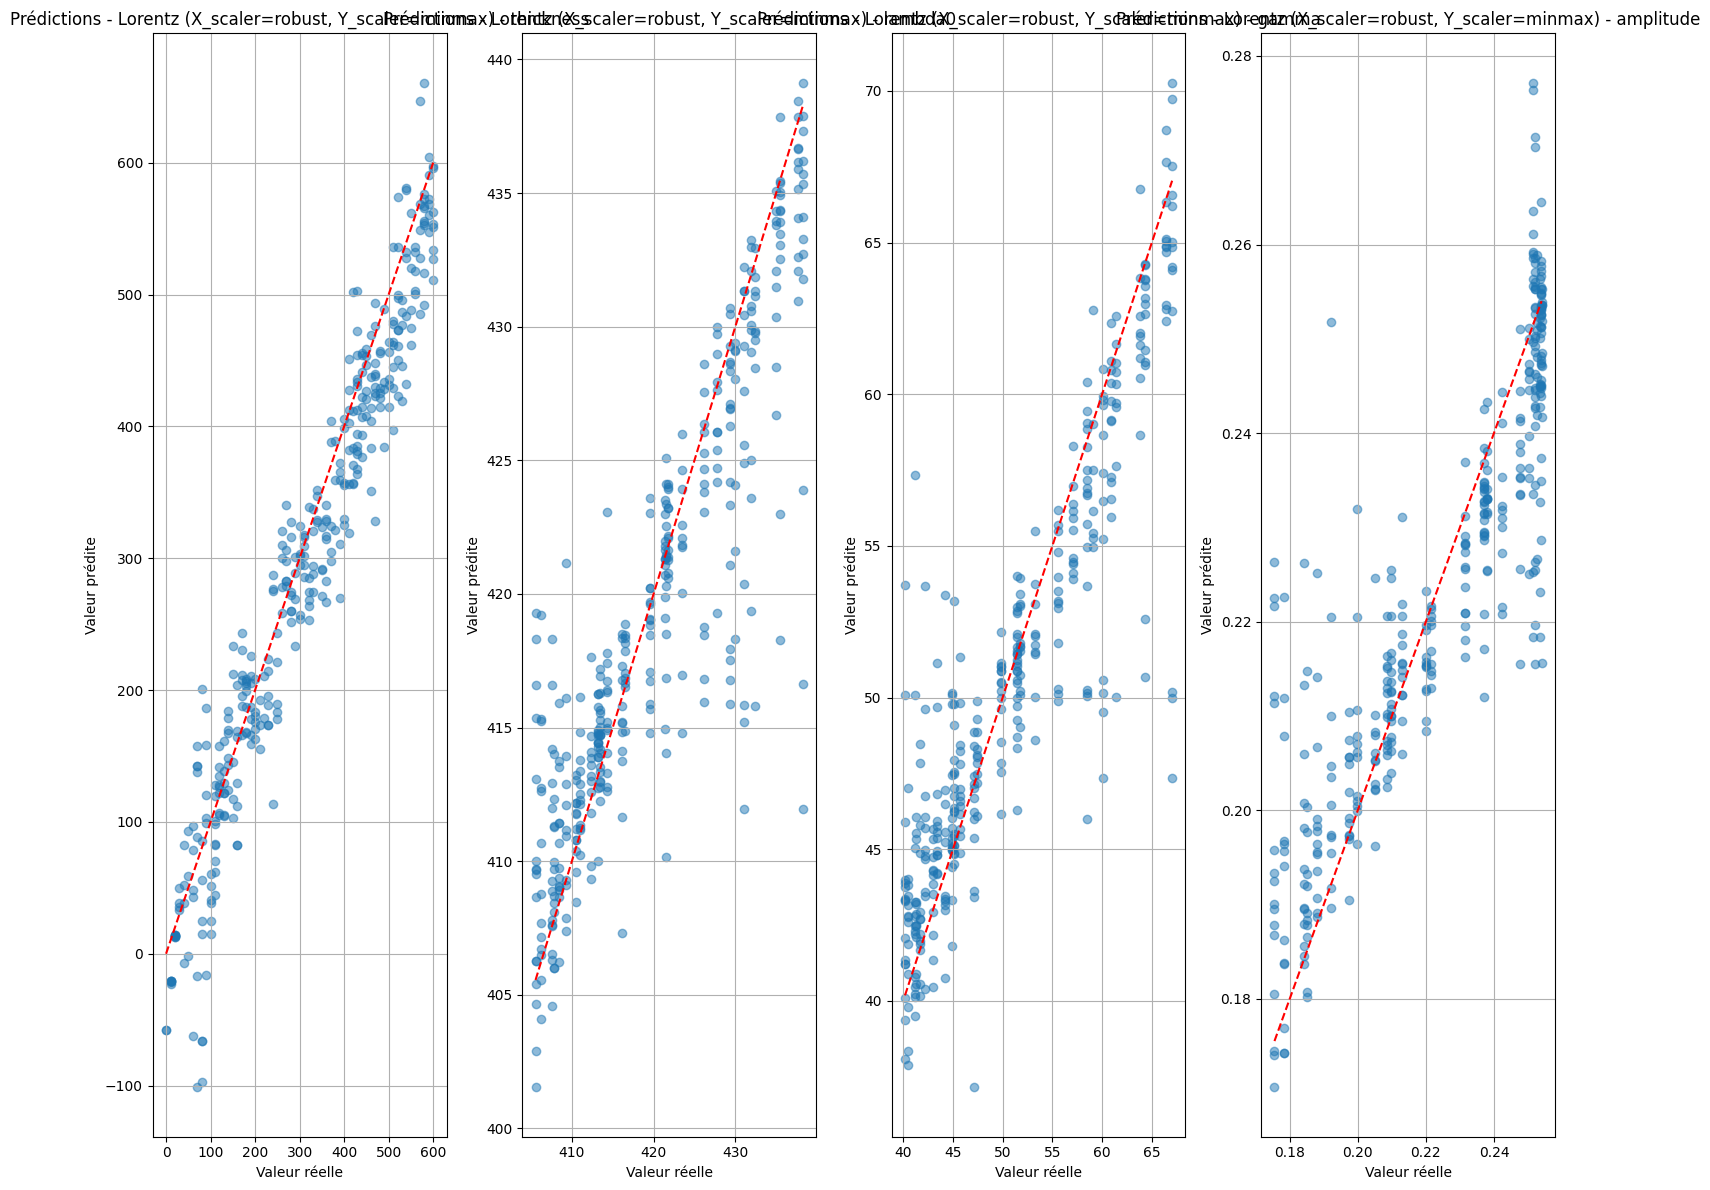


=== Entraînement sur le dataset Lorentz avec X_scaler=robust et Y_scaler=robust ===

=== Entraînement sur le dataset Lorentz (X_scaler=robust, Y_scaler=robust) ===
Taille du training set: 1464
Taille du test set: 366
Paramètres à prédire: ['thickness', 'lambda0', 'gamma', 'amplitude']
Epoch 10/100 - Train Loss: 2.6341, Test Loss: 0.3720
Epoch 20/100 - Train Loss: 1.0729, Test Loss: 0.2310
Epoch 30/100 - Train Loss: 0.5282, Test Loss: 0.1169
Epoch 40/100 - Train Loss: 0.3425, Test Loss: 0.0917
Epoch 50/100 - Train Loss: 0.2511, Test Loss: 0.0697
Epoch 60/100 - Train Loss: 0.1970, Test Loss: 0.0609
Epoch 70/100 - Train Loss: 0.1593, Test Loss: 0.0470
Epoch 80/100 - Train Loss: 0.1217, Test Loss: 0.0447
Epoch 90/100 - Train Loss: 0.1122, Test Loss: 0.0415
Epoch 100/100 - Train Loss: 0.1005, Test Loss: 0.0355
Entraînement terminé en 22.16 secondes
Meilleure loss sur le test set: 0.0353


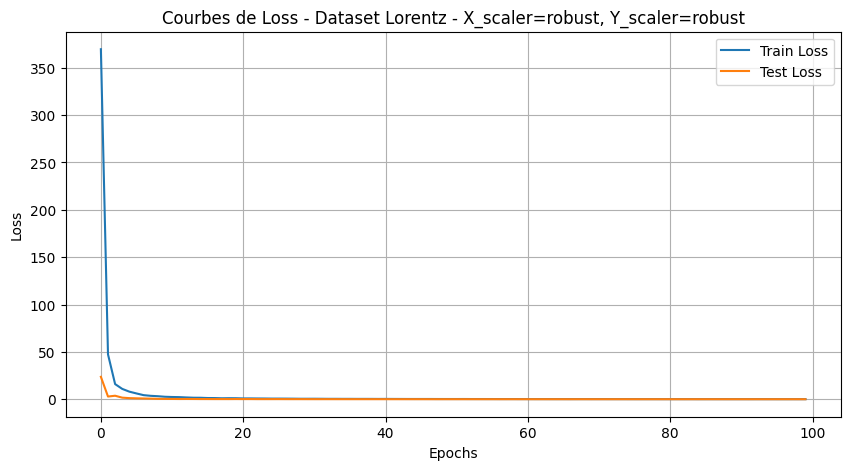

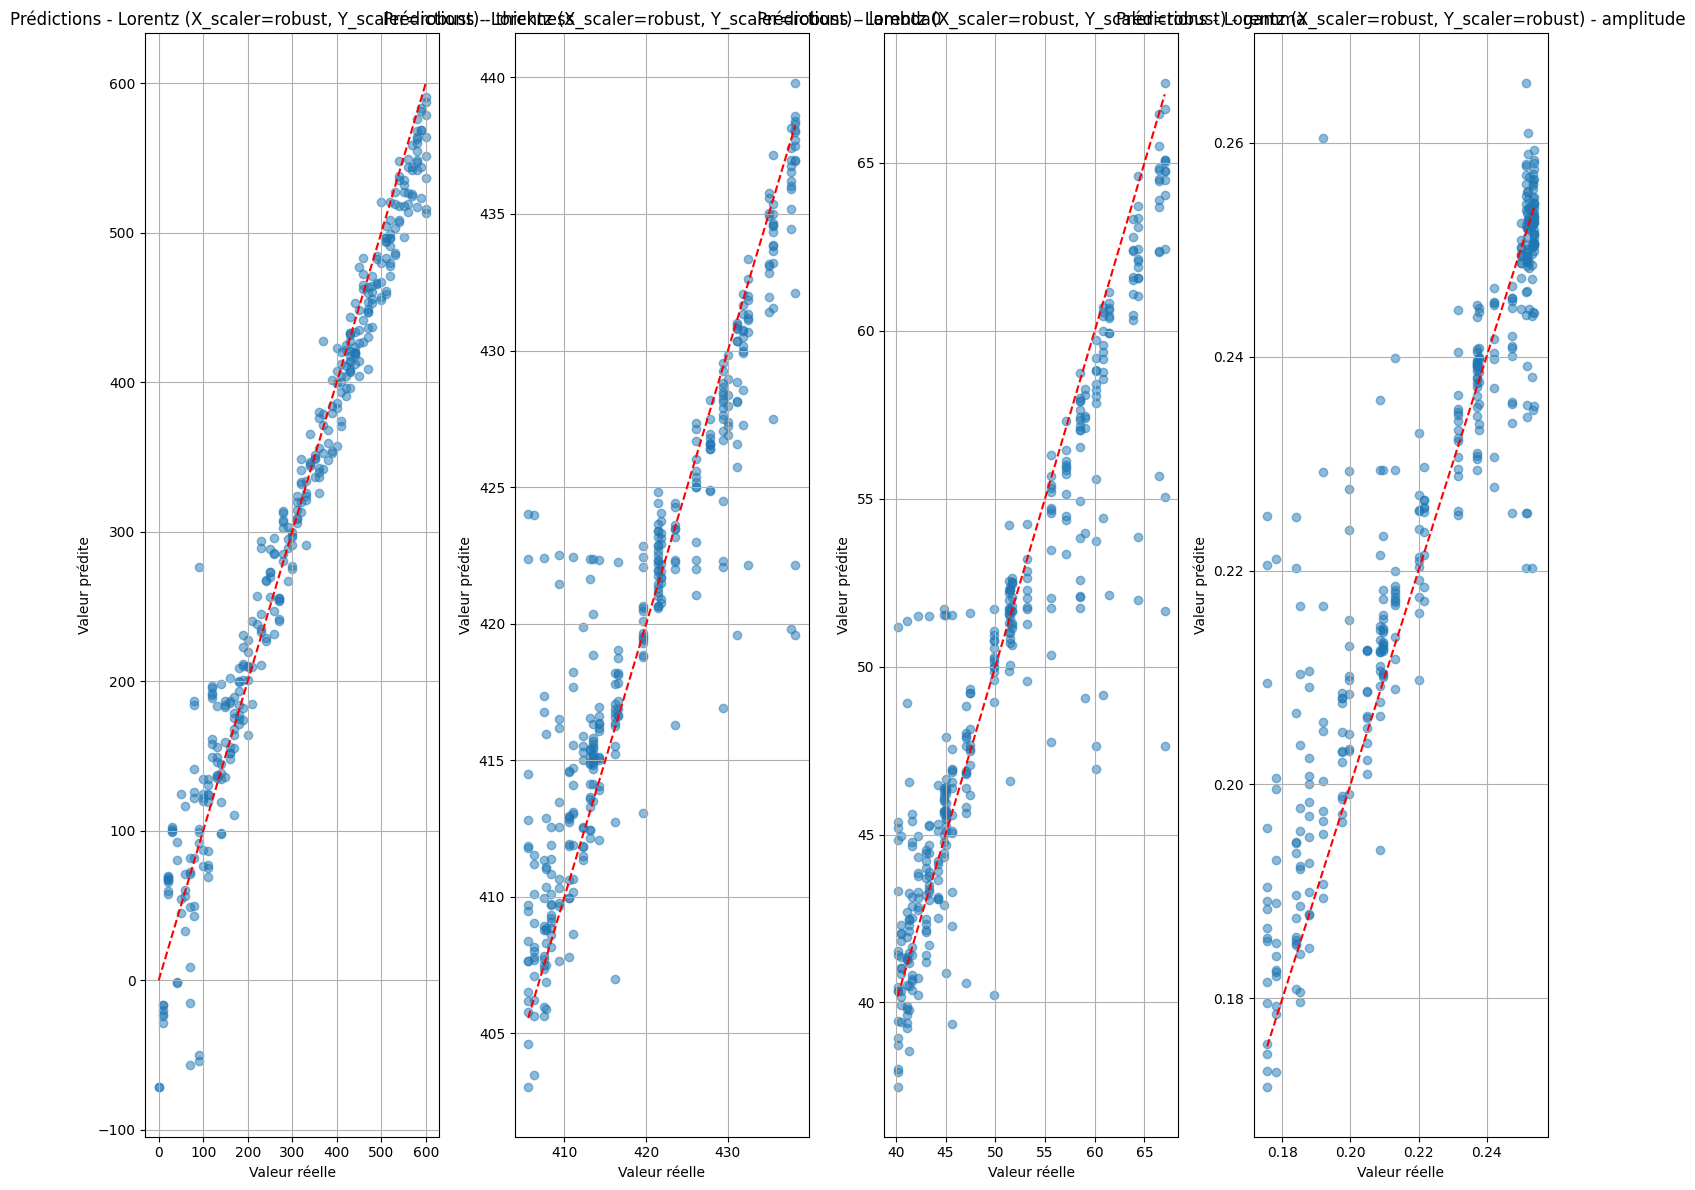


=== Résultats comparatifs ===
Standard_X_standard_Y_parameter_specific:
- Meilleure test loss: 0.0109
- Temps d'entraînement: 1.41s
- Nombre d'epochs effectifs: 100
--------------------------------------------------
Standard_X_standard_Y_standard:
- Meilleure test loss: 0.0454
- Temps d'entraînement: 0.61s
- Nombre d'epochs effectifs: 68
--------------------------------------------------
Standard_X_standard_Y_minmax:
- Meilleure test loss: 0.0354
- Temps d'entraînement: 0.80s
- Nombre d'epochs effectifs: 89
--------------------------------------------------
Standard_X_standard_Y_robust:
- Meilleure test loss: 0.0832
- Temps d'entraînement: 0.35s
- Nombre d'epochs effectifs: 36
--------------------------------------------------
Standard_X_minmax_Y_parameter_specific:
- Meilleure test loss: 0.0221
- Temps d'entraînement: 0.66s
- Nombre d'epochs effectifs: 87
--------------------------------------------------
Standard_X_minmax_Y_standard:
- Meilleure test loss: 0.0223
- Temps d'entraînem

In [18]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

# Configuration commune des hyperparamètres
COMMON_HYPERPARAMS = {
    'hidden_dims': [256, 256, 256],  # Architecture du réseau
    'activation': 'leaky_relu',
    'dropout_rate': 0.1,
    'batch_size': 64,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'epochs': 100,
    'patience': 20  # Pour l'early stopping
}

def train_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                param_names, dataset_name, hyperparams):
    """
    Entraîne un modèle sur un dataset spécifique avec les hyperparamètres donnés
    """
    # Création des DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
    
    # Initialisation du modèle
    model = FlexibleNN(
        input_dim=X_train_tensor.shape[1],
        output_dim=y_train_tensor.shape[1],
        hidden_dims=hyperparams['hidden_dims'],
        activation=hyperparams['activation'],
        dropout_rate=hyperparams['dropout_rate']
    )
    
    # Optimiseur et fonction de perte
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=hyperparams['learning_rate'], 
        weight_decay=hyperparams['weight_decay']
    )
    criterion = nn.MSELoss()
    
    # Early stopping
    best_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    # Historique des losses
    train_losses = []
    test_losses = []
    
    print(f"\n=== Entraînement sur le dataset {dataset_name} ===")
    print(f"Taille du training set: {len(X_train_tensor)}")
    print(f"Taille du test set: {len(X_test_tensor)}")
    print(f"Paramètres à prédire: {param_names}")
    
    start_time = time.time()
    
    for epoch in range(hyperparams['epochs']):
        # Mode entraînement
        model.train()
        epoch_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * batch_X.size(0)
        
        # Calcul de la loss moyenne sur l'epoch
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Évaluation sur le test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            epoch_test_loss = criterion(test_outputs, y_test_tensor).item()
        test_losses.append(epoch_test_loss)
        
        # Early stopping et sauvegarde du meilleur modèle
        if epoch_test_loss < best_loss:
            best_loss = epoch_test_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= hyperparams['patience']:
                print(f"Early stopping à l'epoch {epoch+1}")
                break
        
        # Affichage progressif
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{hyperparams['epochs']} - Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
    
    # Temps d'entraînement
    training_time = time.time() - start_time
    print(f"Entraînement terminé en {training_time:.2f} secondes")
    print(f"Meilleure loss sur le test set: {best_loss:.4f}")
    
    # Chargement du meilleur modèle
    model.load_state_dict(best_model)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'training_time': training_time,
        'best_test_loss': best_loss
    }

# Préparation des données pour les trois datasets
datasets = {
    'Standard': {
        'X_train': X_train_std,
        'X_test': X_test_std,
        'y_train': y_train_std,
        'y_test': y_test_std,
        'param_names': labels_std
    },
    'Maxwell-Garnett': {
        'X_train': X_train_mg,
        'X_test': X_test_mg,
        'y_train': y_train_mg,
        'y_test': y_test_mg,
        'param_names': labels_mg
    },
    'Lorentz': {
        'X_train': X_train_lor,
        'X_test': X_test_lor,
        'y_train': y_train_lor,
        'y_test': y_test_lor,
        'param_names': labels_lor
    }
}


# Types de scalers possibles pour X et y
x_scaler_types = ['standard', 'minmax', 'robust']
y_scaler_types = ['parameter_specific', 'standard', 'minmax', 'robust']

# Dictionnaire pour stocker les résultats
results = {}

# Entraînement des modèles sur les trois datasets avec toutes les combinaisons de scalers
for name, data in datasets.items():
    for x_scaler in x_scaler_types:
        for y_scaler in y_scaler_types:
            print(f"\n=== Entraînement sur le dataset {name} avec X_scaler={x_scaler} et Y_scaler={y_scaler} ===")
            
            # Prétraitement des données
            processed_data = preprocess_and_convert(
                data['X_train'], data['X_test'],
                data['y_train'], data['y_test'],
                data['param_names'],
                scale_y=True,
                x_scaler_type=x_scaler,
                y_scaler_type=y_scaler
            )
            
            # Entraînement du modèle
            result = train_model(
                processed_data['X_train'],
                processed_data['y_train'],
                processed_data['X_test'],
                processed_data['y_test'],
                data['param_names'],
                f"{name} (X_scaler={x_scaler}, Y_scaler={y_scaler})",
                COMMON_HYPERPARAMS
            )
            
            # Ajout des informations supplémentaires
            result['scaler_X'] = processed_data['scaler_X']
            result['scaler_y'] = processed_data['scaler_y']
            result['param_names'] = data['param_names']
            results[f"{name}_X_{x_scaler}_Y_{y_scaler}"] = result
            
            # Affichage des courbes
            plot_losses(result['train_losses'], result['test_losses'], f"Dataset {name} - X_scaler={x_scaler}, Y_scaler={y_scaler}")
            plot_predictions(
                result['model'],
                processed_data['X_test'],
                processed_data['y_test'],
                processed_data['scaler_y'],
                data['param_names'],
                f"Prédictions - {name} (X_scaler={x_scaler}, Y_scaler={y_scaler})"
            )

# Affichage comparatif des résultats
print("\n=== Résultats comparatifs ===")
for key, res in results.items():
    print(f"{key}:")
    print(f"- Meilleure test loss: {res['best_test_loss']:.4f}")
    print(f"- Temps d'entraînement: {res['training_time']:.2f}s")
    print(f"- Nombre d'epochs effectifs: {len(res['train_losses'])}")
    print("-" * 50)